In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup

# Bilanço Çekme

In [2]:
hisseler = ["TKNSA"]
url="https://www.isyatirim.com.tr/tr-tr/analiz/hisse/Sayfalar/sirket-karti.aspx?hisse=ACSEL"
r = requests.get(url)
s = BeautifulSoup(r.text, "html.parser") # string olarak htm kodlarına ulaştık

# class' select olan ve id'si ddlAddCompare olan butun ic alanını alabileceğimiz yapı:
s1 = s.find("select", id="ddlAddCompare")
c1 = s1.findChild("optgroup").findAll("option")

#for a in c1:
    #hisseler.append(a.string)

for i in hisseler:
    hisse = i
    tarihler = []
    yıllar = []
    donemler = []

    url1 ="https://www.isyatirim.com.tr/tr-tr/analiz/hisse/Sayfalar/sirket-karti.aspx?hisse="+hisse
    r1 = requests.get(url1)
    soup=BeautifulSoup(r1.text, "html.parser")
    #donemleri kazıma
    secim = soup.find("select",id="ddlMaliTabloFirst")
    secim2 = soup.find("select", id="ddlMaliTabloGroup") # XI_29 veya UFRS yapılarını almak için
    try: # hata varsa atla (Bazı hisse senedi kodlarında donem verisi mevcut değil hata almamak için try blogu kullandık.)
        cocuklar = secim.findChildren("option") # selectin altındaki option grupları çocuklar olarak adlandırılır
        grup = secim2.findChild("option")["value"] #select sınıfının altında tek option var ondan dolayı child value degerini aldık linke atamak için
        
        for i in cocuklar:
            tarihler.append(i.string.rsplit("/"))
            # Yılları ve Dönemleri parçalayıp linkdeki parametrelere gondermemiz lazım:
        for j in tarihler:
            yıllar.append(j[0])
            donemler.append(j[1])
        
        ## Kurgu kısmı:
        if len(tarihler) >=4: # ilk 4 donemi cekebilmek icin, 4 den az donem varsa gelmesin..
            parametreler=(
                ("companyCode", hisse),
                ("exchange","TRY"),
                ("financialGroup", grup),
                ("year1",yıllar[0]),
                ("period1", donemler[0]),
                ("year2",yıllar[1]),
                ("period2", donemler[1]),
                ("year3",yıllar[2]),
                ("period3", donemler[2]),
                ("year4",yıllar[3]),
                ("period4", donemler[3])
            )
        
            url2 = "https://www.isyatirim.com.tr/_layouts/15/IsYatirim.Website/Common/Data.aspx/MaliTablo"
            r2 = requests.get(url2, params= parametreler).json()["value"] # ilk donem için json yapısında bilancolara eriştik
            veri = pd.DataFrame.from_dict(r2) # sozlukten dataframe'e cevir.
            veri.drop(columns = ["itemCode", "itemDescEng"], inplace= True)
        else:
            continue
    except AttributeError:
        continue
    del tarihler[0:4]
    tumveri=[veri]
    # sonraki donemleri almak için ilk 4 tarih silinir ve donem ve yıllarada bu uygulanır:
    for _ in range(0, int(len(tarihler)+1)):
        if len(tarihler) == len(yıllar):
            del tarihler[0:4]
        else:
            yıllar = []
            donemler = []
            for j in tarihler:
                yıllar.append(j[0])
                donemler.append(j[1])
            if len(tarihler) >= 4:
                parametreler2=(
                    ("companyCode", hisse),
                    ("exchange","TRY"),
                    ("financialGroup", grup),
                    ("year1",yıllar[0]),
                    ("period1", donemler[0]),
                    ("year2",yıllar[1]),
                    ("period2", donemler[1]),
                    ("year3",yıllar[2]),
                    ("period3", donemler[2]),
                    ("year4",yıllar[3]),
                    ("period4", donemler[3])
                )
        
                r3 = requests.get(url2, params= parametreler2).json()["value"] # ilk donem için json yapısında bilancolara eriştik
                veri2 = pd.DataFrame.from_dict(r3) # sozlukten dataframe'e cevir.
                try:
                    veri2.drop(columns = ["itemCode", "itemDescTr", "itemDescEng"], inplace= True)
                    tumveri.append(veri2)
                except KeyError:
                    continue
            veri3 = pd.concat(tumveri, axis=1)
            baslik = ["Bilanço"]
            for i in cocuklar:
                baslik.append(i.string)

            baslikfark = len(baslik)-len(veri3.columns)
            if baslikfark != 0:
                del baslik[-baslikfark:]
            
            veri3 = veri3.set_axis(baslik, axis=1)
            veri3[baslik[1:]] = veri3[baslik[1:]].astype(float)
            veri3.fillna(0,inplace=True)
            veri3.to_excel("C:/Users/okand/Desktop/Mali Tablolar Analizi/{}.xlsx".format(hisse), index=False)

In [3]:
pd.options.display.max_rows=999
pd.options.display.max_columns=999
pd.options.display.float_format = '{:,.2f}'.format

# Çeyreklik ve Yıllık Verilerin Hazırlanması

In [4]:
veri=pd.read_excel("C:/Users/okand/Desktop/Mali Tablolar Analizi/TKNSA.xlsx")
veri=veri.set_index("Bilanço")
x=0
while True:
    for i in veri.columns:
        if i != "2018/3":
            x+=1
            continue
        elif i == "2018/3":
            x+=1
            break
        break
    break
veri=veri.loc[::,veri.columns[0:x]]
veri.head()

,2023/3,2022/12,2022/9,2022/6,2022/3,2021/12,2021/9,2021/6,2021/3,2020/12,2020/9,2020/6,2020/3,2019/12,2019/9,2019/6,2019/3,2018/12,2018/9,2018/6,2018/3
Bilanço,,,,,,,,,,,,,,,,,,,,,
Dönen Varlıklar,5760428000,5438562000,4897601000,3434232000,2969045000,2623534000,1781450000,1635830000,1408056000,1565441000,1373087000,1177577000,996801000,994466000,719033000,816878000,723189000,592569000,656428000,679485000,577857000
Nakit ve Nakit Benzerleri,958021000,1604179000,834314000,520824000,552670000,709408000,118269000,65040000,29987000,392201000,264263000,325051000,48389000,37267000,22143000,49920000,42418000,26987000,38221000,24772000,20731000
Finansal Yatırımlar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Ticari Alacaklar,527834000,441042000,308536000,264020000,186331000,155925000,123574000,129897000,106416000,103297000,86787000,87635000,60877000,66362000,74225000,87917000,60965000,65775000,84404000,95645000,63997000
Finans Sektörü Faaliyetlerinden Alacaklar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
veri=veri.reset_index()
veri.loc[13,"Bilanço"]="Ticari Alacaklar_2"
veri.loc[14,"Bilanço"]="Finans Sektörü Faaliyetlerinden Alacaklar_2"
veri.loc[15,"Bilanço"]="Diğer Alacaklar_2"
veri.loc[16,"Bilanço"]="Müşteri Sözleşmelerinden Doğan Varlıklar_2"
veri.loc[17,"Bilanço"]="Finansal Yatırımlar_2"
veri.loc[19,"Bilanço"]="Canlı Varlıklar_2"
veri.loc[21,"Bilanço"]="Stoklar_2"
veri.loc[45,"Bilanço"]="Finansal Borçlar_2"
veri.loc[46,"Bilanço"]="Diğer Finansal Yükümlülükler_2"
veri.loc[47,"Bilanço"]="Ticari Borçlar_2"
veri.loc[48,"Bilanço"]="Diğer Borçlar_2"
veri.loc[49,"Bilanço"]="Müşteri Söz.Doğan Yük._2"
veri.loc[50,"Bilanço"]="Finans Sektörü Faaliyetlerinden Borçlar_2"
veri.loc[51,"Bilanço"]="Devlet Teşvik ve Yardımları_2"
veri.loc[52,"Bilanço"]="Ertelenmiş Gelirler (Müşteri Söz.Doğan Yük.)_2"
veri.loc[54,"Bilanço"]="Çalışanlara Sağlanan Faydalara İliş.Karş._2"
veri=veri.set_index(["Bilanço"])
veri.head()

,2023/3,2022/12,2022/9,2022/6,2022/3,2021/12,2021/9,2021/6,2021/3,2020/12,2020/9,2020/6,2020/3,2019/12,2019/9,2019/6,2019/3,2018/12,2018/9,2018/6,2018/3
Bilanço,,,,,,,,,,,,,,,,,,,,,
Dönen Varlıklar,5760428000,5438562000,4897601000,3434232000,2969045000,2623534000,1781450000,1635830000,1408056000,1565441000,1373087000,1177577000,996801000,994466000,719033000,816878000,723189000,592569000,656428000,679485000,577857000
Nakit ve Nakit Benzerleri,958021000,1604179000,834314000,520824000,552670000,709408000,118269000,65040000,29987000,392201000,264263000,325051000,48389000,37267000,22143000,49920000,42418000,26987000,38221000,24772000,20731000
Finansal Yatırımlar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Ticari Alacaklar,527834000,441042000,308536000,264020000,186331000,155925000,123574000,129897000,106416000,103297000,86787000,87635000,60877000,66362000,74225000,87917000,60965000,65775000,84404000,95645000,63997000
Finans Sektörü Faaliyetlerinden Alacaklar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
veri2=veri[veri.columns[::-1]]
veri2.head()

,2018/3,2018/6,2018/9,2018/12,2019/3,2019/6,2019/9,2019/12,2020/3,2020/6,2020/9,2020/12,2021/3,2021/6,2021/9,2021/12,2022/3,2022/6,2022/9,2022/12,2023/3
Bilanço,,,,,,,,,,,,,,,,,,,,,
Dönen Varlıklar,577857000,679485000,656428000,592569000,723189000,816878000,719033000,994466000,996801000,1177577000,1373087000,1565441000,1408056000,1635830000,1781450000,2623534000,2969045000,3434232000,4897601000,5438562000,5760428000
Nakit ve Nakit Benzerleri,20731000,24772000,38221000,26987000,42418000,49920000,22143000,37267000,48389000,325051000,264263000,392201000,29987000,65040000,118269000,709408000,552670000,520824000,834314000,1604179000,958021000
Finansal Yatırımlar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Ticari Alacaklar,63997000,95645000,84404000,65775000,60965000,87917000,74225000,66362000,60877000,87635000,86787000,103297000,106416000,129897000,123574000,155925000,186331000,264020000,308536000,441042000,527834000
Finans Sektörü Faaliyetlerinden Alacaklar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
ceyreklik_veriler=veri
for i in range(len(ceyreklik_veriler.index)):
    for j in range(len(ceyreklik_veriler.columns)):
        if "/3" in ceyreklik_veriler.columns[j]:
            ceyreklik_veriler.loc[ceyreklik_veriler.index[i]][ceyreklik_veriler.columns[j]]=veri.loc[ceyreklik_veriler.index[i]][ceyreklik_veriler.columns[j]]
        else:
            ceyreklik_veriler.loc[ceyreklik_veriler.index[i]][ceyreklik_veriler.columns[j]]=veri.loc[ceyreklik_veriler.index[i]][ceyreklik_veriler.columns[j]]-veri.loc[ceyreklik_veriler.index[i]][ceyreklik_veriler.columns[j+1]]
        
ceyreklik_veriler.head()

C:\Users\okand\AppData\Local\Temp\ipykernel_13920\1135183724.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ceyreklik_veriler.loc[ceyreklik_veriler.index[i]][ceyreklik_veriler.columns[j]]=veri.loc[ceyreklik_veriler.index[i]][ceyreklik_veriler.columns[j]]
C:\Users\okand\AppData\Local\Temp\ipykernel_13920\1135183724.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ceyreklik_veriler.loc[ceyreklik_veriler.index[i]][ceyreklik_veriler.columns[j]]=veri.loc[ceyreklik_veriler.index[i]][ceyreklik_veriler.colu

,2023/3,2022/12,2022/9,2022/6,2022/3,2021/12,2021/9,2021/6,2021/3,2020/12,2020/9,2020/6,2020/3,2019/12,2019/9,2019/6,2019/3,2018/12,2018/9,2018/6,2018/3
Bilanço,,,,,,,,,,,,,,,,,,,,,
Dönen Varlıklar,5760428000,540961000,1463369000,465187000,2969045000,842084000,145620000,227774000,1408056000,192354000,195510000,180776000,996801000,275433000,-97845000,93689000,723189000,-63859000,-23057000,101628000,577857000
Nakit ve Nakit Benzerleri,958021000,769865000,313490000,-31846000,552670000,591139000,53229000,35053000,29987000,127938000,-60788000,276662000,48389000,15124000,-27777000,7502000,42418000,-11234000,13449000,4041000,20731000
Finansal Yatırımlar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Ticari Alacaklar,527834000,132506000,44516000,77689000,186331000,32351000,-6323000,23481000,106416000,16510000,-848000,26758000,60877000,-7863000,-13692000,26952000,60965000,-18629000,-11241000,31648000,63997000
Finans Sektörü Faaliyetlerinden Alacaklar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
ceyreklik_veriler2=ceyreklik_veriler[ceyreklik_veriler.columns[::-1]]
ceyreklik_veriler2.head()

,2018/3,2018/6,2018/9,2018/12,2019/3,2019/6,2019/9,2019/12,2020/3,2020/6,2020/9,2020/12,2021/3,2021/6,2021/9,2021/12,2022/3,2022/6,2022/9,2022/12,2023/3
Bilanço,,,,,,,,,,,,,,,,,,,,,
Dönen Varlıklar,577857000,101628000,-23057000,-63859000,723189000,93689000,-97845000,275433000,996801000,180776000,195510000,192354000,1408056000,227774000,145620000,842084000,2969045000,465187000,1463369000,540961000,5760428000
Nakit ve Nakit Benzerleri,20731000,4041000,13449000,-11234000,42418000,7502000,-27777000,15124000,48389000,276662000,-60788000,127938000,29987000,35053000,53229000,591139000,552670000,-31846000,313490000,769865000,958021000
Finansal Yatırımlar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Ticari Alacaklar,63997000,31648000,-11241000,-18629000,60965000,26952000,-13692000,-7863000,60877000,26758000,-848000,16510000,106416000,23481000,-6323000,32351000,186331000,77689000,44516000,132506000,527834000
Finans Sektörü Faaliyetlerinden Alacaklar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
yillik_veriler=ceyreklik_veriler.loc[::,ceyreklik_veriler.columns[0:len(veri.columns)-3]]
for i in range(len(yillik_veriler.index)):
    for j in range(len(yillik_veriler.columns)):
        yillik_veriler.loc[yillik_veriler.index[i]][yillik_veriler.columns[j]]=veri.loc[ceyreklik_veriler.index[i]][ceyreklik_veriler.columns[j]]\
        +veri.loc[ceyreklik_veriler.index[i]][ceyreklik_veriler.columns[j+1]]+veri.loc[ceyreklik_veriler.index[i]][ceyreklik_veriler.columns[j+2]]\
        +veri.loc[ceyreklik_veriler.index[i]][ceyreklik_veriler.columns[j+3]]
yillik_veriler.head()

C:\Users\okand\AppData\Local\Temp\ipykernel_13920\4240792564.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yillik_veriler.loc[yillik_veriler.index[i]][yillik_veriler.columns[j]]=veri.loc[ceyreklik_veriler.index[i]][ceyreklik_veriler.columns[j]]\


,2023/3,2022/12,2022/9,2022/6,2022/3,2021/12,2021/9,2021/6,2021/3,2020/12,2020/9,2020/6,2020/3,2019/12,2019/9,2019/6,2019/3,2018/12
Bilanço,,,,,,,,,,,,,,,,,,
Dönen Varlıklar,8229945000,5438562000,5739685000,4421936000,4184523000,2623534000,1973804000,2023694000,1976696000,1565441000,1648520000,1355165000,1268078000,994466000,655174000,729962000,737901000,592569000
Nakit ve Nakit Benzerleri,2009530000,1604179000,1425453000,1165192000,1232091000,709408000,246207000,132190000,373799000,392201000,279387000,312398000,43238000,37267000,10909000,52135000,48674000,26987000
Finansal Yatırımlar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Ticari Alacaklar,782545000,441042000,340887000,290048000,235840000,155925000,140084000,145559000,148836000,103297000,78924000,66080000,66274000,66362000,55596000,58047000,62743000,65775000
Finans Sektörü Faaliyetlerinden Alacaklar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
yillik_veriler2=yillik_veriler[yillik_veriler.columns[::-1]]
yillik_veriler2.head()

,2018/12,2019/3,2019/6,2019/9,2019/12,2020/3,2020/6,2020/9,2020/12,2021/3,2021/6,2021/9,2021/12,2022/3,2022/6,2022/9,2022/12,2023/3
Bilanço,,,,,,,,,,,,,,,,,,
Dönen Varlıklar,592569000,737901000,729962000,655174000,994466000,1268078000,1355165000,1648520000,1565441000,1976696000,2023694000,1973804000,2623534000,4184523000,4421936000,5739685000,5438562000,8229945000
Nakit ve Nakit Benzerleri,26987000,48674000,52135000,10909000,37267000,43238000,312398000,279387000,392201000,373799000,132190000,246207000,709408000,1232091000,1165192000,1425453000,1604179000,2009530000
Finansal Yatırımlar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Ticari Alacaklar,65775000,62743000,58047000,55596000,66362000,66274000,66080000,78924000,103297000,148836000,145559000,140084000,155925000,235840000,290048000,340887000,441042000,782545000
Finans Sektörü Faaliyetlerinden Alacaklar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


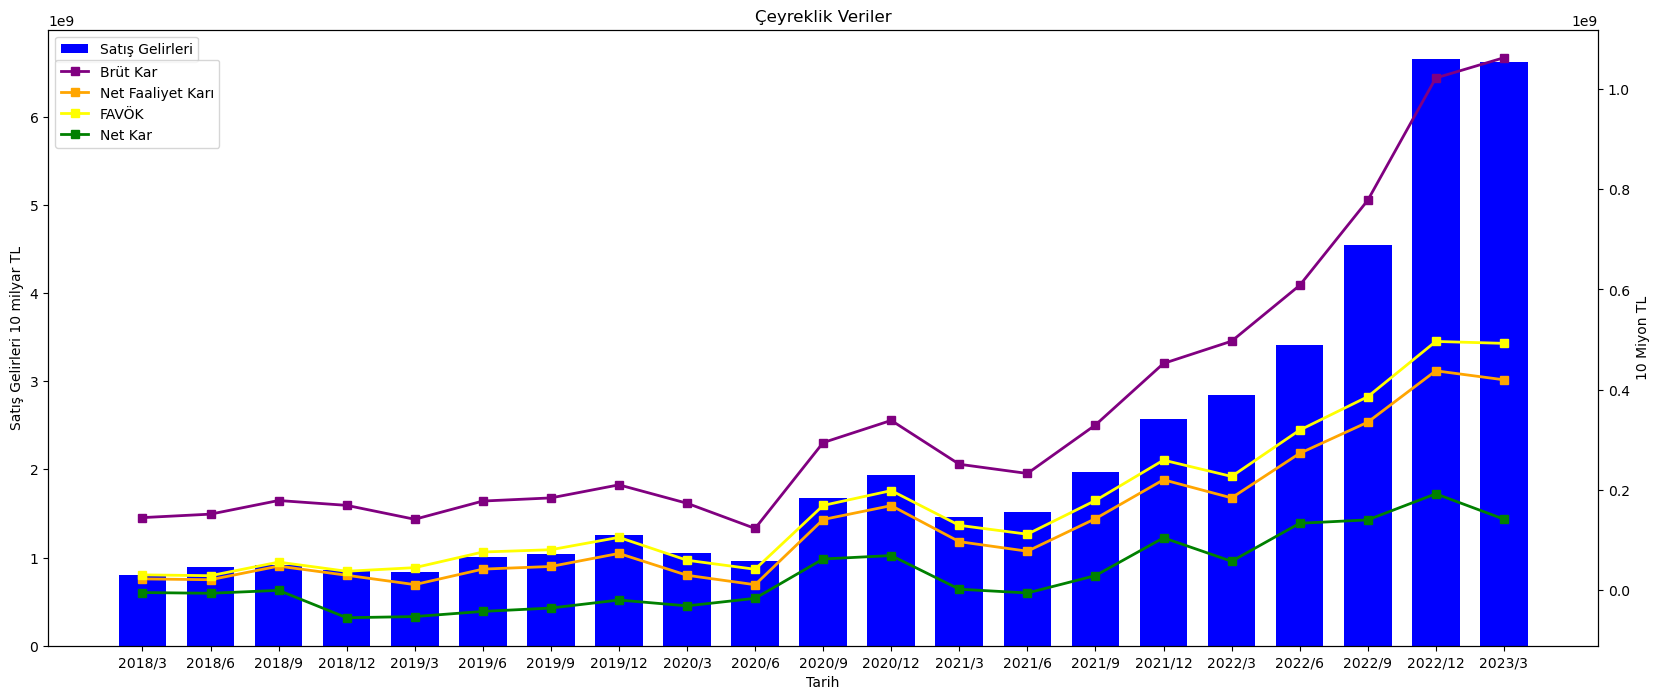

In [11]:
fig, ax1=plt.subplots(figsize=(20,8))
ax1.bar(ceyreklik_veriler2.columns,ceyreklik_veriler2.loc["Satış Gelirleri"], color="blue", width=0.7, label="Satış Gelirleri")
ax2 = ax1.twinx()
ax2.plot(ceyreklik_veriler2.columns,ceyreklik_veriler2.loc["BRÜT KAR (ZARAR)"],color="purple", linewidth=2, marker="s", label="Brüt Kar")
ax2.plot(ceyreklik_veriler2.columns,ceyreklik_veriler2.loc["Net Faaliyet Kar/Zararı"],color="orange", linewidth=2, marker="s", label="Net Faaliyet Karı")
ax2.plot(ceyreklik_veriler2.columns,ceyreklik_veriler2.loc["Net Faaliyet Kar/Zararı"]+ceyreklik_veriler2.loc["Amortisman Giderleri"],color="yellow", linewidth=2, marker="s", label="FAVÖK")
ax2.plot(ceyreklik_veriler2.columns,ceyreklik_veriler2.loc["DÖNEM KARI (ZARARI)"], color="green", linewidth=2, marker="s", label="Net Kar")
ax1.set_title("Çeyreklik Veriler")
ax1.set_xlabel("Tarih")
ax1.set_ylabel("Satış Gelirleri 10 milyar TL")
ax2.set_ylabel("10 Miyon TL")
ax1.legend()
ax2.legend(loc='center left', bbox_to_anchor=(0, 0.88))
plt.show()

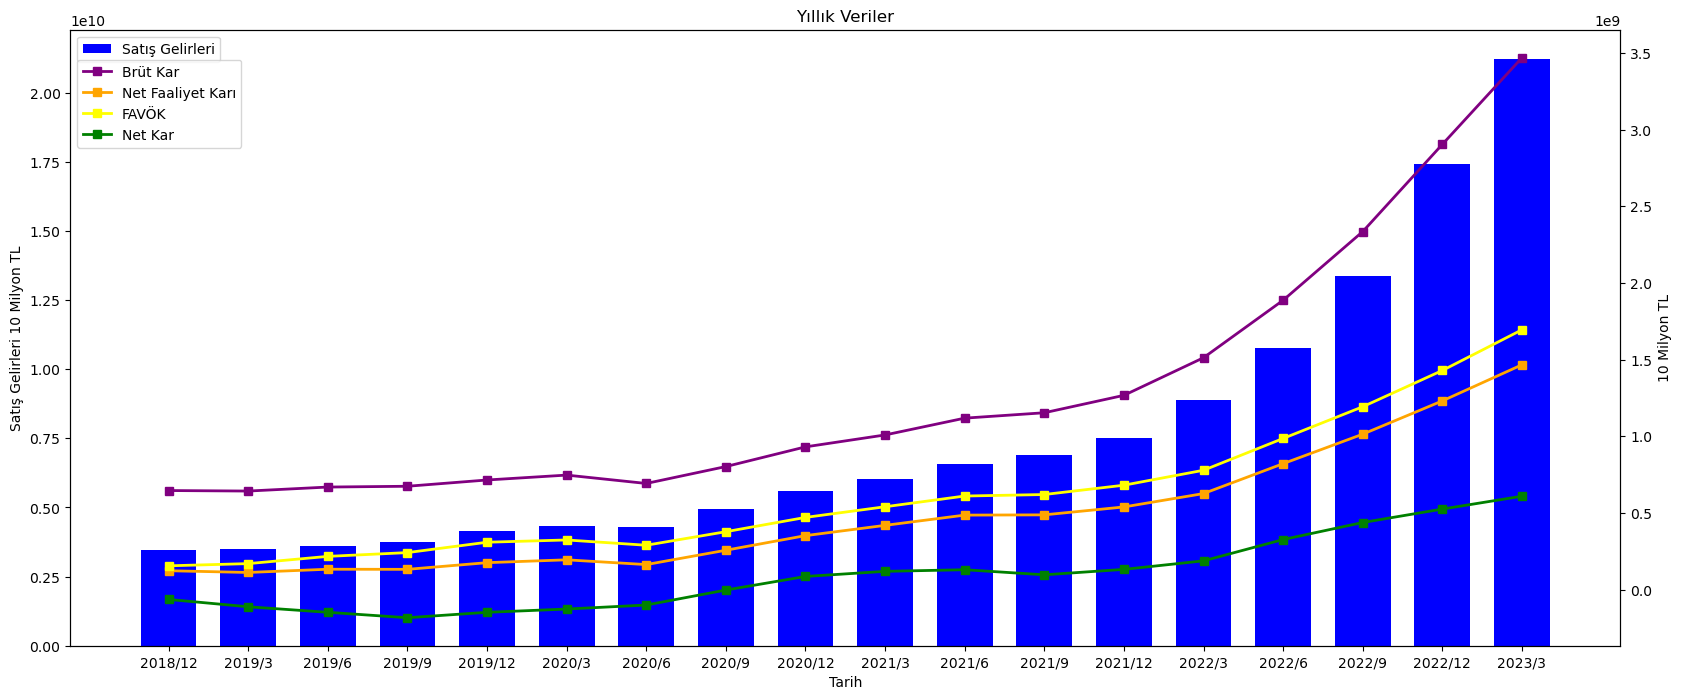

In [12]:
fig, ax1=plt.subplots(figsize=(20,8))
ax1.bar(yillik_veriler2.columns,yillik_veriler2.loc["Satış Gelirleri"], color="blue", width=0.7, label="Satış Gelirleri")
ax2 = ax1.twinx()
ax2.plot(yillik_veriler2.columns,yillik_veriler2.loc["BRÜT KAR (ZARAR)"],color="purple", linewidth=2, marker="s", label="Brüt Kar")
ax2.plot(yillik_veriler2.columns,yillik_veriler2.loc["Net Faaliyet Kar/Zararı"],color="orange", linewidth=2, marker="s", label="Net Faaliyet Karı")
ax2.plot(yillik_veriler2.columns,yillik_veriler2.loc["Net Faaliyet Kar/Zararı"]+yillik_veriler2.loc["Amortisman Giderleri"],color="yellow", linewidth=2, marker="s", label="FAVÖK")
ax2.plot(yillik_veriler2.columns,yillik_veriler2.loc["DÖNEM KARI (ZARARI)"], color="green", linewidth=2, marker="s", label="Net Kar")
ax1.set_title("Yıllık Veriler")
ax1.set_xlabel("Tarih")
ax1.set_ylabel("Satış Gelirleri 10 Milyon TL")
ax2.set_ylabel("10 Milyon TL")
ax1.legend()
ax2.legend(loc='center left', bbox_to_anchor=(0, 0.88))
plt.show()

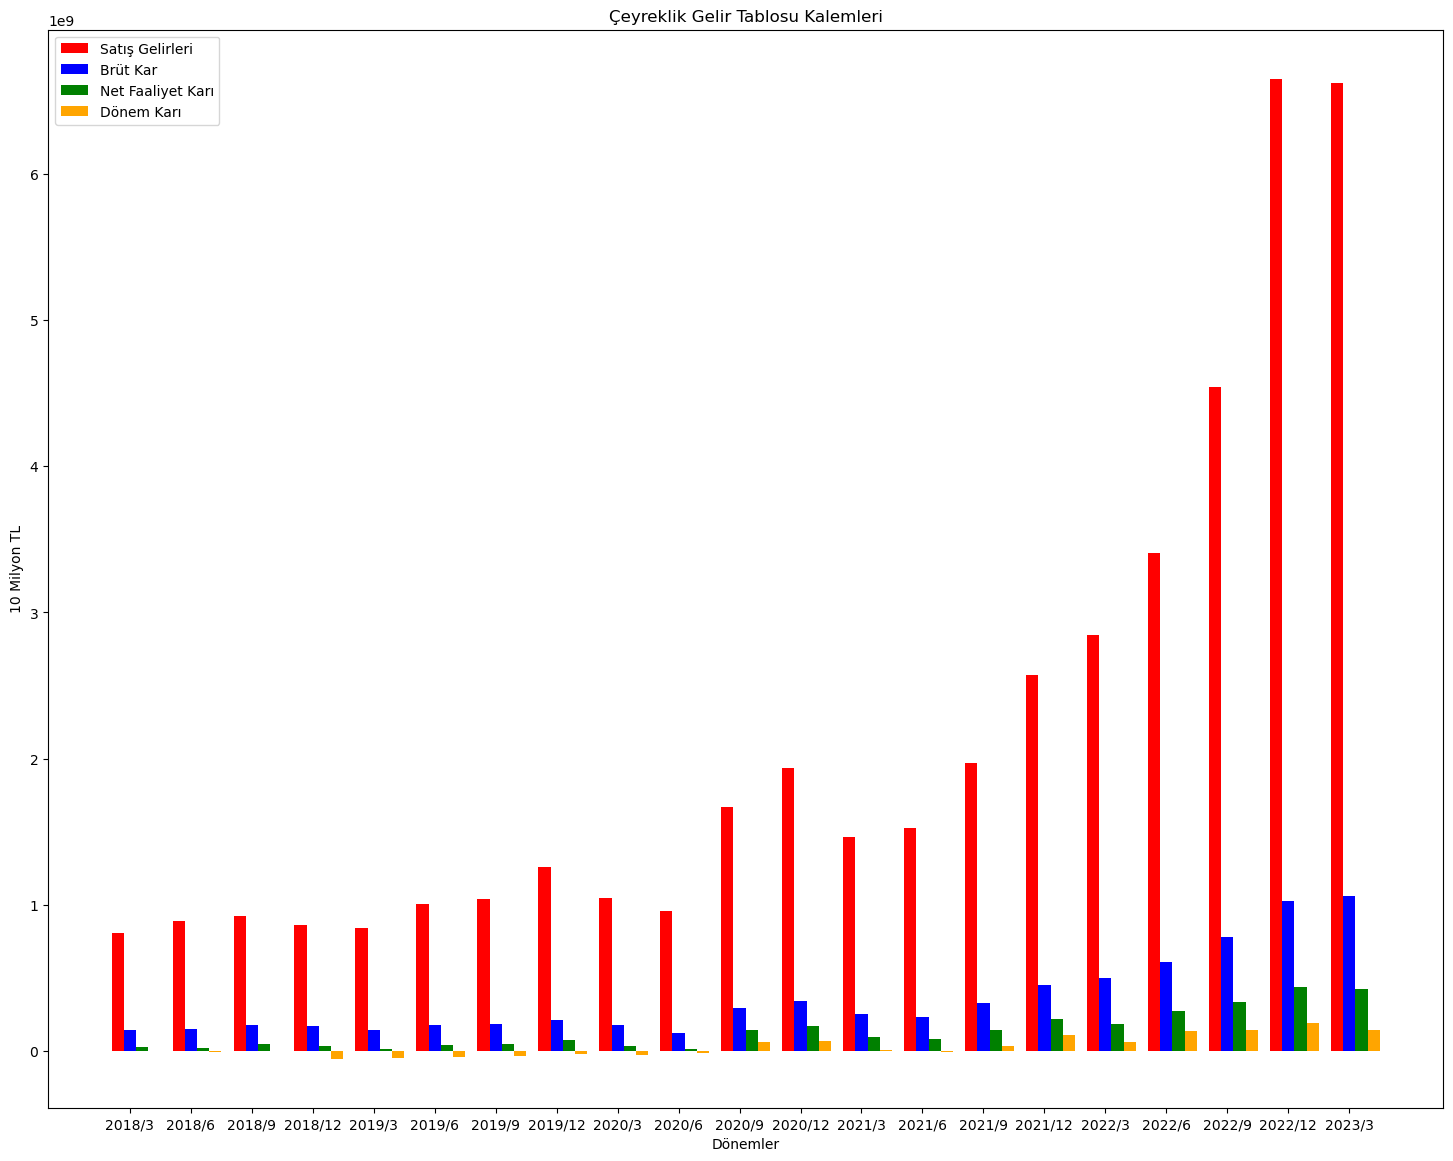

In [13]:
fig = plt.subplots(figsize =(18, 14))
barWidth=0.2
br1 = np.arange(len(ceyreklik_veriler2.columns))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
plt.bar(br1,ceyreklik_veriler2.loc["Satış Gelirleri"],label="Satış Gelirleri",color="Red",width = barWidth)
plt.bar(br2,ceyreklik_veriler2.loc["BRÜT KAR (ZARAR)"], label="Brüt Kar",color="Blue",width=barWidth)
plt.bar(br3,ceyreklik_veriler2.loc["Net Faaliyet Kar/Zararı"],label="Net Faaliyet Karı",color="Green",width=barWidth)
plt.bar(br4,ceyreklik_veriler2.loc["DÖNEM KARI (ZARARI)"],label="Dönem Karı",color="Orange",width=barWidth)
plt.title("Çeyreklik Gelir Tablosu Kalemleri")
plt.xlabel("Dönemler")
plt.ylabel("10 Milyon TL")
plt.xticks([r + barWidth for r in range(len(ceyreklik_veriler2.columns))],ceyreklik_veriler2.columns)
plt.legend()
plt.show()

## Yatay Analiz

* TÜFE: https://www.vergidegundem.com/pb_tuketici_fiyat_endeksi
* Yİ-UFE: https://www.hakedis.org/endeksler/yi-ufe-yurtici-uretici-fiyat-endeksi

In [14]:
yi_ufe=pd.DataFrame({"Tarih":[2018,2019,2020,2021,2022,2023],"Yİ-ÜFE":[336.48,402.81,450.08,523.53,843.64,1269.75]})
yi_ufe

,Tarih,Yİ-ÜFE
0,2018,336.48
1,2019,402.81
2,2020,450.08
3,2021,523.53
4,2022,843.64
5,2023,"1,269.75"


In [15]:
degisim_katsayisi=pd.DataFrame({"Dönem":["2023/2018","2023/2019","2023/2020","2023/2021","2023/2022"]})
degisim_katsayisi["DK"]=np.nan
for i in range(len(yi_ufe)-1):
    degisim_katsayisi["DK"][i]=round(yi_ufe["Yİ-ÜFE"][5]/yi_ufe["Yİ-ÜFE"][i],2)
degisim_katsayisi

C:\Users\okand\AppData\Local\Temp\ipykernel_13920\655247110.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  degisim_katsayisi["DK"][i]=round(yi_ufe["Yİ-ÜFE"][5]/yi_ufe["Yİ-ÜFE"][i],2)


,Dönem,DK
0,2023/2018,3.77
1,2023/2019,3.15
2,2023/2020,2.82
3,2023/2021,2.43
4,2023/2022,1.51


In [16]:
yillik_veriler2[:106]

,2018/12,2019/3,2019/6,2019/9,2019/12,2020/3,2020/6,2020/9,2020/12,2021/3,2021/6,2021/9,2021/12,2022/3,2022/6,2022/9,2022/12,2023/3
Bilanço,,,,,,,,,,,,,,,,,,
Dönen Varlıklar,592569000,737901000,729962000,655174000,994466000,1268078000,1355165000,1648520000,1565441000,1976696000,2023694000,1973804000,2623534000,4184523000,4421936000,5739685000,5438562000,8229945000
Nakit ve Nakit Benzerleri,26987000,48674000,52135000,10909000,37267000,43238000,312398000,279387000,392201000,373799000,132190000,246207000,709408000,1232091000,1165192000,1425453000,1604179000,2009530000
Finansal Yatırımlar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Ticari Alacaklar,65775000,62743000,58047000,55596000,66362000,66274000,66080000,78924000,103297000,148836000,145559000,140084000,155925000,235840000,290048000,340887000,441042000,782545000
Finans Sektörü Faaliyetlerinden Alacaklar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Diğer Alacaklar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Müşteri Sözleşmelerinden Doğan Varlıklar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Stoklar,492677000,608433000,633296000,612400000,860128000,1136630000,947988000,1218048000,1056528000,1431929000,1720349000,1588549000,1719160000,2640567000,2822224000,3749442000,3265498000,5193214000
Canlı Varlıklar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
yatay_analiz=yillik_veriler2[:106][yillik_veriler2.columns[-17::4]]
yatay_analiz=pd.DataFrame(yatay_analiz)
yatay_analiz

,2019/3,2020/3,2021/3,2022/3,2023/3
Bilanço,,,,,
Dönen Varlıklar,737901000,1268078000,1976696000,4184523000,8229945000
Nakit ve Nakit Benzerleri,48674000,43238000,373799000,1232091000,2009530000
Finansal Yatırımlar,0,0,0,0,0
Ticari Alacaklar,62743000,66274000,148836000,235840000,782545000
Finans Sektörü Faaliyetlerinden Alacaklar,0,0,0,0,0
Diğer Alacaklar,0,0,0,0,0
Müşteri Sözleşmelerinden Doğan Varlıklar,0,0,0,0,0
Stoklar,608433000,1136630000,1431929000,2640567000,5193214000
Canlı Varlıklar,0,0,0,0,0


In [18]:
degisken1=[]
degisken2=[]
degisken3=[]
for i in yillik_veriler2.columns[-17::4][0:4]:
    degisken1.append("DK_{}".format(i.split("/")[0]))

for i in yillik_veriler2.columns[-17::4]:
    degisken2.append("{}_DK".format(i))
    degisken3.append(i)

In [19]:
yatay_analiz[degisken1[0]]=degisim_katsayisi["DK"][1]
yatay_analiz[degisken1[1]]=degisim_katsayisi["DK"][2]
yatay_analiz[degisken1[2]]=degisim_katsayisi["DK"][3]
yatay_analiz[degisken1[3]]=degisim_katsayisi["DK"][4]
yatay_analiz[degisken2[0]]=round(yatay_analiz[degisken3[0]]*yatay_analiz[degisken1[0]],1)
yatay_analiz[degisken2[1]]=round(yatay_analiz[degisken3[1]]*yatay_analiz[degisken1[1]],1)
yatay_analiz[degisken2[2]]=round(yatay_analiz[degisken3[2]]*yatay_analiz[degisken1[2]],1)
yatay_analiz[degisken2[3]]=round(yatay_analiz[degisken3[3]]*yatay_analiz[degisken1[3]],1)
yatay_analiz[degisken2[4]]=round(yatay_analiz[degisken3[4]],1)

yatay_analiz=yatay_analiz.drop(columns=[degisken3[0],degisken3[1],degisken3[2],degisken3[3],degisken3[4],
                                                        degisken1[0],degisken1[1],degisken1[2],degisken1[3]],axis=1)

yatay_analiz.head()



,2019/3_DK,2020/3_DK,2021/3_DK,2022/3_DK,2023/3_DK
Bilanço,,,,,
Dönen Varlıklar,"2,324,388,150.00","3,575,979,960.00","4,803,371,280.00","6,318,629,730.00",8229945000
Nakit ve Nakit Benzerleri,"153,323,100.00","121,931,160.00","908,331,570.00","1,860,457,410.00",2009530000
Finansal Yatırımlar,0.00,0.00,0.00,0.00,0
Ticari Alacaklar,"197,640,450.00","186,892,680.00","361,671,480.00","356,118,400.00",782545000
Finans Sektörü Faaliyetlerinden Alacaklar,0.00,0.00,0.00,0.00,0


In [20]:
baslik=[]
for i in degisken3:
    baslik.append(str(i.split("/")[0][2:]))
baslik2=["{} Değişim Tutarı".format(baslik[0]+"/"+baslik[1]),"{} Değişim Tutarı".format(baslik[1]+"/"+baslik[2]),
        "{} Değişim Tutarı".format(baslik[2]+"/"+baslik[3]),"{} Değişim Tutarı".format(baslik[3]+"/"+baslik[4])]
baslik3=["{} Değişimi (%)".format(baslik[0]+"/"+baslik[1]),"{} Değişimi (%)".format(baslik[1]+"/"+baslik[2]),
        "{} Değişimi (%)".format(baslik[2]+"/"+baslik[3]),"{} Değişimi (%)".format(baslik[3]+"/"+baslik[4])]
print(baslik2)
print(baslik3)

['19/20 Değişim Tutarı', '20/21 Değişim Tutarı', '21/22 Değişim Tutarı', '22/23 Değişim Tutarı']
['19/20 Değişimi (%)', '20/21 Değişimi (%)', '21/22 Değişimi (%)', '22/23 Değişimi (%)']


In [21]:
yatay_analiz[baslik2[0]]=yatay_analiz[degisken2[1]]-yatay_analiz[degisken2[0]]
yatay_analiz[baslik3[0]]=round(yatay_analiz[baslik2[0]]/yatay_analiz[degisken2[0]],1)*100
yatay_analiz[baslik2[1]]=yatay_analiz[degisken2[2]]-yatay_analiz[degisken2[1]]
yatay_analiz[baslik3[1]]=round(yatay_analiz[baslik2[1]]/yatay_analiz[degisken2[1]],1)*100
yatay_analiz[baslik2[2]]=yatay_analiz[degisken2[3]]-yatay_analiz[degisken2[2]]
yatay_analiz[baslik3[2]]=round(yatay_analiz[baslik2[2]]/yatay_analiz[degisken2[2]],1)*100
yatay_analiz[baslik2[3]]=yatay_analiz[degisken2[4]]-yatay_analiz[degisken2[3]]
yatay_analiz[baslik3[3]]=round(yatay_analiz[baslik2[3]]/yatay_analiz[degisken2[3]],1)*100

yatay_analiz



,2019/3_DK,2020/3_DK,2021/3_DK,2022/3_DK,2023/3_DK,19/20 Değişim Tutarı,19/20 Değişimi (%),20/21 Değişim Tutarı,20/21 Değişimi (%),21/22 Değişim Tutarı,21/22 Değişimi (%),22/23 Değişim Tutarı,22/23 Değişimi (%)
Bilanço,,,,,,,,,,,,,
Dönen Varlıklar,"2,324,388,150.00","3,575,979,960.00","4,803,371,280.00","6,318,629,730.00",8229945000,"1,251,591,810.00",50.00,"1,227,391,320.00",30.00,"1,515,258,450.00",30.00,"1,911,315,270.00",30.00
Nakit ve Nakit Benzerleri,"153,323,100.00","121,931,160.00","908,331,570.00","1,860,457,410.00",2009530000,"-31,391,940.00",-20.00,"786,400,410.00",640.00,"952,125,840.00",100.00,"149,072,590.00",10.00
Finansal Yatırımlar,0.00,0.00,0.00,0.00,0,0.00,NaN,0.00,NaN,0.00,NaN,0.00,NaN
Ticari Alacaklar,"197,640,450.00","186,892,680.00","361,671,480.00","356,118,400.00",782545000,"-10,747,770.00",-10.00,"174,778,800.00",90.00,"-5,553,080.00",-0.00,"426,426,600.00",120.00
Finans Sektörü Faaliyetlerinden Alacaklar,0.00,0.00,0.00,0.00,0,0.00,NaN,0.00,NaN,0.00,NaN,0.00,NaN
Diğer Alacaklar,0.00,0.00,0.00,0.00,0,0.00,NaN,0.00,NaN,0.00,NaN,0.00,NaN
Müşteri Sözleşmelerinden Doğan Varlıklar,0.00,0.00,0.00,0.00,0,0.00,NaN,0.00,NaN,0.00,NaN,0.00,NaN
Stoklar,"1,916,563,950.00","3,205,296,600.00","3,479,587,470.00","3,987,256,170.00",5193214000,"1,288,732,650.00",70.00,"274,290,870.00",10.00,"507,668,700.00",10.00,"1,205,957,830.00",30.00
Canlı Varlıklar,0.00,0.00,0.00,0.00,0,0.00,NaN,0.00,NaN,0.00,NaN,0.00,NaN


In [22]:
yatay_analiz_bilanco=yatay_analiz[0:70]
yatay_analiz_gelir_tablosu=yatay_analiz[71:]
yatay_analiz_gelir_tablosu.index.name="Gelir Tablosu"

In [23]:
yatay_analiz_bilanco

,2019/3_DK,2020/3_DK,2021/3_DK,2022/3_DK,2023/3_DK,19/20 Değişim Tutarı,19/20 Değişimi (%),20/21 Değişim Tutarı,20/21 Değişimi (%),21/22 Değişim Tutarı,21/22 Değişimi (%),22/23 Değişim Tutarı,22/23 Değişimi (%)
Bilanço,,,,,,,,,,,,,
Dönen Varlıklar,"2,324,388,150.00","3,575,979,960.00","4,803,371,280.00","6,318,629,730.00",8229945000,"1,251,591,810.00",50.00,"1,227,391,320.00",30.00,"1,515,258,450.00",30.00,"1,911,315,270.00",30.00
Nakit ve Nakit Benzerleri,"153,323,100.00","121,931,160.00","908,331,570.00","1,860,457,410.00",2009530000,"-31,391,940.00",-20.00,"786,400,410.00",640.00,"952,125,840.00",100.00,"149,072,590.00",10.00
Finansal Yatırımlar,0.00,0.00,0.00,0.00,0,0.00,NaN,0.00,NaN,0.00,NaN,0.00,NaN
Ticari Alacaklar,"197,640,450.00","186,892,680.00","361,671,480.00","356,118,400.00",782545000,"-10,747,770.00",-10.00,"174,778,800.00",90.00,"-5,553,080.00",-0.00,"426,426,600.00",120.00
Finans Sektörü Faaliyetlerinden Alacaklar,0.00,0.00,0.00,0.00,0,0.00,NaN,0.00,NaN,0.00,NaN,0.00,NaN
Diğer Alacaklar,0.00,0.00,0.00,0.00,0,0.00,NaN,0.00,NaN,0.00,NaN,0.00,NaN
Müşteri Sözleşmelerinden Doğan Varlıklar,0.00,0.00,0.00,0.00,0,0.00,NaN,0.00,NaN,0.00,NaN,0.00,NaN
Stoklar,"1,916,563,950.00","3,205,296,600.00","3,479,587,470.00","3,987,256,170.00",5193214000,"1,288,732,650.00",70.00,"274,290,870.00",10.00,"507,668,700.00",10.00,"1,205,957,830.00",30.00
Canlı Varlıklar,0.00,0.00,0.00,0.00,0,0.00,NaN,0.00,NaN,0.00,NaN,0.00,NaN


In [24]:
yatay_analiz_gelir_tablosu

,2019/3_DK,2020/3_DK,2021/3_DK,2022/3_DK,2023/3_DK,19/20 Değişim Tutarı,19/20 Değişimi (%),20/21 Değişim Tutarı,20/21 Değişimi (%),21/22 Değişim Tutarı,21/22 Değişimi (%),22/23 Değişim Tutarı,22/23 Değişimi (%)
Gelir Tablosu,,,,,,,,,,,,,
Satış Gelirleri,"11,060,251,650.00","12,252,025,800.00","14,627,093,400.00","13,441,869,000.00",21219455000,"1,191,774,150.00",10.00,"2,375,067,600.00",20.00,"-1,185,224,400.00",-10.00,"7,777,586,000.00",60.00
Satışların Maliyeti (-),"-9,036,571,950.00","-10,146,701,220.00","-12,176,632,800.00","-11,158,406,230.00",-17750070000,"-1,110,129,270.00",10.00,"-2,029,931,580.00",20.00,"1,018,226,570.00",-10.00,"-6,591,663,770.00",60.00
Ticari Faaliyetlerden Diğer Kar (Zarar),0.00,0.00,0.00,0.00,0,0.00,NaN,0.00,NaN,0.00,NaN,0.00,NaN
Ticari Faaliyetlerden Brüt Kar (Zarar),"2,023,679,700.00","2,105,324,580.00","2,450,460,600.00","2,283,462,770.00",3469385000,"81,644,880.00",0.00,"345,136,020.00",20.00,"-166,997,830.00",-10.00,"1,185,922,230.00",50.00
"Faiz, Ücret, Prim, Komisyon ve Diğer Gelirler",0.00,0.00,0.00,0.00,0,0.00,NaN,0.00,NaN,0.00,NaN,0.00,NaN
"Faiz, Ücret, Prim, Komisyon ve Diğer Giderler (-)",0.00,0.00,0.00,0.00,0,0.00,NaN,0.00,NaN,0.00,NaN,0.00,NaN
Finans Sektörü Faaliyetlerinden Diğer Kar (Zarar),0.00,0.00,0.00,0.00,0,0.00,NaN,0.00,NaN,0.00,NaN,0.00,NaN
Finans Sektörü Faaliyetlerinden Brüt Kar (Zarar),0.00,0.00,0.00,0.00,0,0.00,NaN,0.00,NaN,0.00,NaN,0.00,NaN
Diğer Gelir ve Giderler,0.00,0.00,0.00,0.00,0,0.00,NaN,0.00,NaN,0.00,NaN,0.00,NaN


In [25]:
dosya1=yatay_analiz_bilanco.to_excel("C:/Users/okand/Desktop/Mali Tablolar Analizi/python_ciktilari/yatay_analiz_bilanco.xlsx")
dosya2=yatay_analiz_gelir_tablosu.to_excel("C:/Users/okand/Desktop/Mali Tablolar Analizi/python_ciktilari/yatay_analiz_gelirtablosu.xlsx")

## Trend Analizi

In [26]:
trend_analizi_bilanco=yatay_analiz_bilanco.loc[:,yatay_analiz_bilanco.columns[0:5]]

In [27]:
trend_analizi_bilanco[trend_analizi_bilanco.columns[0].split("_")[0]]=(trend_analizi_bilanco[trend_analizi_bilanco.columns[0]]/trend_analizi_bilanco[trend_analizi_bilanco.columns[0]])*100
trend_analizi_bilanco[trend_analizi_bilanco.columns[1].split("_")[0]]=(trend_analizi_bilanco[trend_analizi_bilanco.columns[1]]/trend_analizi_bilanco[trend_analizi_bilanco.columns[0]])*100
trend_analizi_bilanco[trend_analizi_bilanco.columns[2].split("_")[0]]=(trend_analizi_bilanco[trend_analizi_bilanco.columns[2]]/trend_analizi_bilanco[trend_analizi_bilanco.columns[0]])*100
trend_analizi_bilanco[trend_analizi_bilanco.columns[3].split("_")[0]]=(trend_analizi_bilanco[trend_analizi_bilanco.columns[3]]/trend_analizi_bilanco[trend_analizi_bilanco.columns[0]])*100
trend_analizi_bilanco[trend_analizi_bilanco.columns[4].split("_")[0]]=(trend_analizi_bilanco[trend_analizi_bilanco.columns[4]]/trend_analizi_bilanco[trend_analizi_bilanco.columns[0]])*100
trend_analizi_bilanco

,2019/3_DK,2020/3_DK,2021/3_DK,2022/3_DK,2023/3_DK,2019/3,2020/3,2021/3,2022/3,2023/3
Bilanço,,,,,,,,,,
Dönen Varlıklar,"2,324,388,150.00","3,575,979,960.00","4,803,371,280.00","6,318,629,730.00",8229945000,100.00,153.85,206.65,271.84,354.07
Nakit ve Nakit Benzerleri,"153,323,100.00","121,931,160.00","908,331,570.00","1,860,457,410.00",2009530000,100.00,79.53,592.43,"1,213.42","1,310.65"
Finansal Yatırımlar,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN
Ticari Alacaklar,"197,640,450.00","186,892,680.00","361,671,480.00","356,118,400.00",782545000,100.00,94.56,182.99,180.18,395.94
Finans Sektörü Faaliyetlerinden Alacaklar,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN
Diğer Alacaklar,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN
Müşteri Sözleşmelerinden Doğan Varlıklar,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN
Stoklar,"1,916,563,950.00","3,205,296,600.00","3,479,587,470.00","3,987,256,170.00",5193214000,100.00,167.24,181.55,208.04,270.96
Canlı Varlıklar,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN


In [28]:
trend_analizi_gt=yatay_analiz_gelir_tablosu.loc[:,yatay_analiz_gelir_tablosu.columns[0:5]]

In [29]:
trend_analizi_gt[trend_analizi_gt.columns[0].split("_")[0]]=(trend_analizi_gt[trend_analizi_gt.columns[0]]/trend_analizi_gt[trend_analizi_gt.columns[0]])*100
trend_analizi_gt[trend_analizi_gt.columns[1].split("_")[0]]=(trend_analizi_gt[trend_analizi_gt.columns[1]]/trend_analizi_gt[trend_analizi_gt.columns[0]])*100
trend_analizi_gt[trend_analizi_gt.columns[2].split("_")[0]]=(trend_analizi_gt[trend_analizi_gt.columns[2]]/trend_analizi_gt[trend_analizi_gt.columns[0]])*100
trend_analizi_gt[trend_analizi_gt.columns[3].split("_")[0]]=(trend_analizi_gt[trend_analizi_gt.columns[3]]/trend_analizi_gt[trend_analizi_gt.columns[0]])*100
trend_analizi_gt[trend_analizi_gt.columns[4].split("_")[0]]=(trend_analizi_gt[trend_analizi_gt.columns[4]]/trend_analizi_gt[trend_analizi_gt.columns[0]])*100
trend_analizi_gt

,2019/3_DK,2020/3_DK,2021/3_DK,2022/3_DK,2023/3_DK,2019/3,2020/3,2021/3,2022/3,2023/3
Gelir Tablosu,,,,,,,,,,
Satış Gelirleri,"11,060,251,650.00","12,252,025,800.00","14,627,093,400.00","13,441,869,000.00",21219455000,100.00,110.78,132.25,121.53,191.85
Satışların Maliyeti (-),"-9,036,571,950.00","-10,146,701,220.00","-12,176,632,800.00","-11,158,406,230.00",-17750070000,100.00,112.28,134.75,123.48,196.42
Ticari Faaliyetlerden Diğer Kar (Zarar),0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN
Ticari Faaliyetlerden Brüt Kar (Zarar),"2,023,679,700.00","2,105,324,580.00","2,450,460,600.00","2,283,462,770.00",3469385000,100.00,104.03,121.09,112.84,171.44
"Faiz, Ücret, Prim, Komisyon ve Diğer Gelirler",0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN
"Faiz, Ücret, Prim, Komisyon ve Diğer Giderler (-)",0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN
Finans Sektörü Faaliyetlerinden Diğer Kar (Zarar),0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN
Finans Sektörü Faaliyetlerinden Brüt Kar (Zarar),0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN
Diğer Gelir ve Giderler,0.00,0.00,0.00,0.00,0,NaN,NaN,NaN,NaN,NaN


In [30]:
dosya3=trend_analizi_bilanco.to_excel("C:/Users/okand/Desktop/Mali Tablolar Analizi/python_ciktilari/trend_analiz_bilanco.xlsx")
dosya4=trend_analizi_gt.to_excel("C:/Users/okand/Desktop/Mali Tablolar Analizi/python_ciktilari/trend_analiz_gelirtablosu.xlsx")

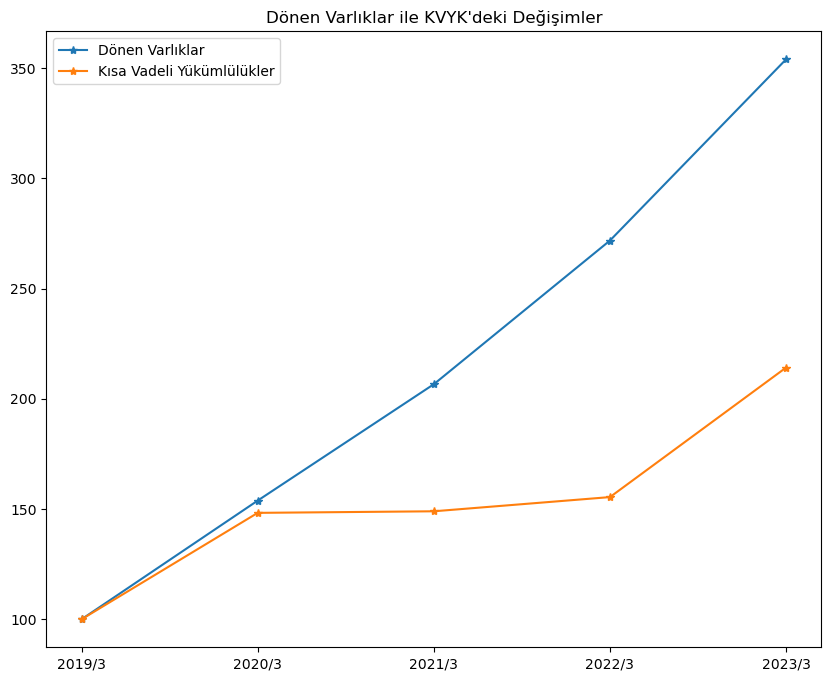

In [31]:
plt.figure(figsize=(10,8))
plt.plot(trend_analizi_bilanco.columns[5:],trend_analizi_bilanco.loc["Dönen Varlıklar",trend_analizi_bilanco.columns[5:]],label="Dönen Varlıklar",marker="*")
plt.plot(trend_analizi_bilanco.columns[5:],trend_analizi_bilanco.loc["Kısa Vadeli Yükümlülükler",trend_analizi_bilanco.columns[5:]],label="Kısa Vadeli Yükümlülükler",marker="*")
plt.title("Dönen Varlıklar ile KVYK'deki Değişimler")
plt.legend()
plt.show()

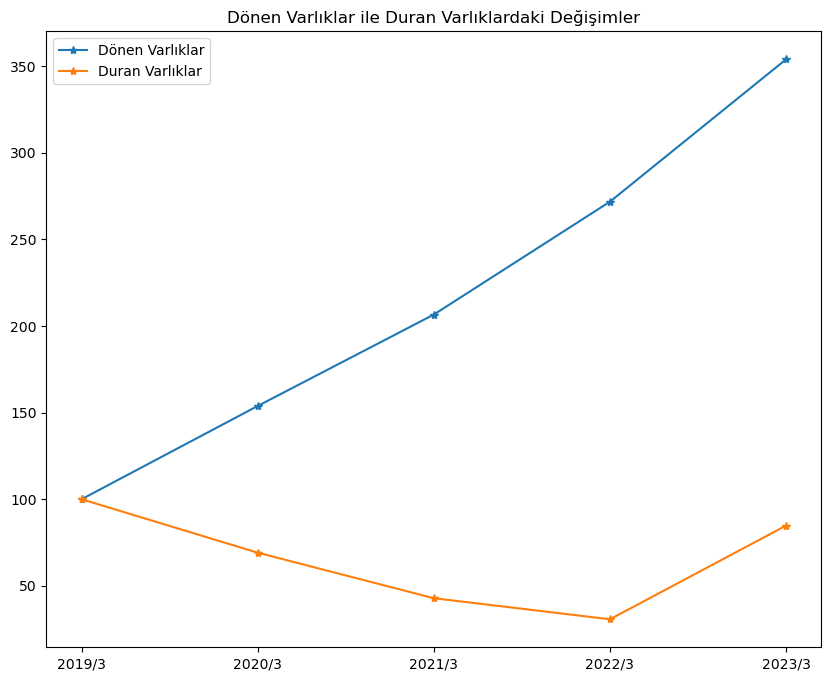

In [32]:
plt.figure(figsize=(10,8))
plt.plot(trend_analizi_bilanco.columns[5:],trend_analizi_bilanco.loc["Dönen Varlıklar",trend_analizi_bilanco.columns[5:]],label="Dönen Varlıklar",marker="*")
plt.plot(trend_analizi_bilanco.columns[5:],trend_analizi_bilanco.loc["Duran Varlıklar",trend_analizi_bilanco.columns[5:]],label="Duran Varlıklar",marker="*")
plt.title("Dönen Varlıklar ile Duran Varlıklardaki Değişimler")
plt.legend()
plt.show()

In [33]:
devamlı_sermaye=trend_analizi_bilanco.loc["Özkaynaklar",trend_analizi_bilanco.columns[:5]]+trend_analizi_bilanco.loc["Uzun Vadeli Yükümlülükler",trend_analizi_bilanco.columns[:5]]
liste1=[]
for i in range(len(devamlı_sermaye)):
    liste1.append(devamlı_sermaye[i])
    
devamlı_sermaye_new=pd.DataFrame(liste1)
devamlı_sermaye_new=devamlı_sermaye_new.T
devamlı_sermaye_new=devamlı_sermaye_new.rename(columns={0:devamlı_sermaye.index[0],1:devamlı_sermaye.index[1],2:devamlı_sermaye.index[2],
                                                        3:devamlı_sermaye.index[3],4:devamlı_sermaye.index[4]},
                                              index={0:"Devamlı Sermaye"})

yabancıl_kaynaklar=trend_analizi_bilanco.loc["Kısa Vadeli Yükümlülükler",trend_analizi_bilanco.columns[:5]]+trend_analizi_bilanco.loc["Uzun Vadeli Yükümlülükler",trend_analizi_bilanco.columns[:5]]
liste2=[]
for i in range(len(yabancıl_kaynaklar)):
    liste2.append(yabancıl_kaynaklar[i])
    
yabancıl_kaynaklar_new=pd.DataFrame(liste2)
yabancıl_kaynaklar_new=yabancıl_kaynaklar_new.T
yabancıl_kaynaklar_new=yabancıl_kaynaklar_new.rename(columns={0:yabancıl_kaynaklar.index[0],1:yabancıl_kaynaklar.index[1],2:yabancıl_kaynaklar.index[2],
                                                        3:yabancıl_kaynaklar.index[3],4:yabancıl_kaynaklar.index[4]},
                                              index={0:"Yabancıl Kaynaklar"})

yeni_df=pd.concat([devamlı_sermaye_new,yabancıl_kaynaklar_new],axis=0)
yeni_df[yeni_df.columns[0].split("_")[0]]=(yeni_df[yeni_df.columns[0]]/yeni_df[yeni_df.columns[0]])*100
yeni_df[yeni_df.columns[1].split("_")[0]]=(yeni_df[yeni_df.columns[1]]/yeni_df[yeni_df.columns[0]])*100
yeni_df[yeni_df.columns[2].split("_")[0]]=(yeni_df[yeni_df.columns[2]]/yeni_df[yeni_df.columns[0]])*100
yeni_df[yeni_df.columns[3].split("_")[0]]=(yeni_df[yeni_df.columns[3]]/yeni_df[yeni_df.columns[0]])*100
yeni_df[yeni_df.columns[4].split("_")[0]]=(yeni_df[yeni_df.columns[4]]/yeni_df[yeni_df.columns[0]])*100
trend_analizi_bilanco=pd.concat([trend_analizi_bilanco,yeni_df],axis=0)

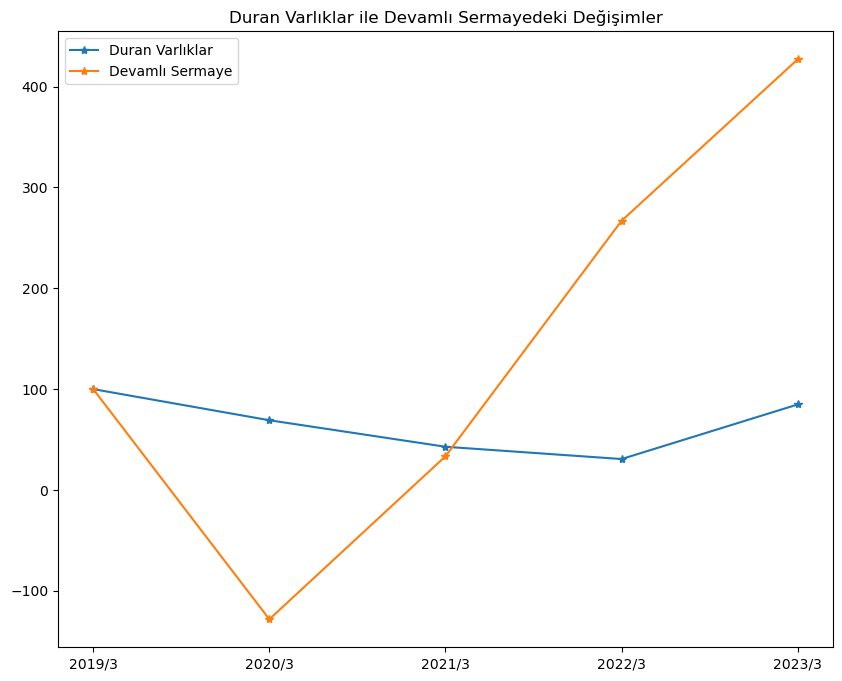

In [34]:
plt.figure(figsize=(10,8))
plt.plot(trend_analizi_bilanco.columns[5:],trend_analizi_bilanco.loc["Duran Varlıklar",trend_analizi_bilanco.columns[5:]],label="Duran Varlıklar",marker="*")
plt.plot(trend_analizi_bilanco.columns[5:],trend_analizi_bilanco.loc["Devamlı Sermaye",trend_analizi_bilanco.columns[5:]],label="Devamlı Sermaye",marker="*")
plt.title("Duran Varlıklar ile Devamlı Sermayedeki Değişimler")
plt.legend()
plt.show()

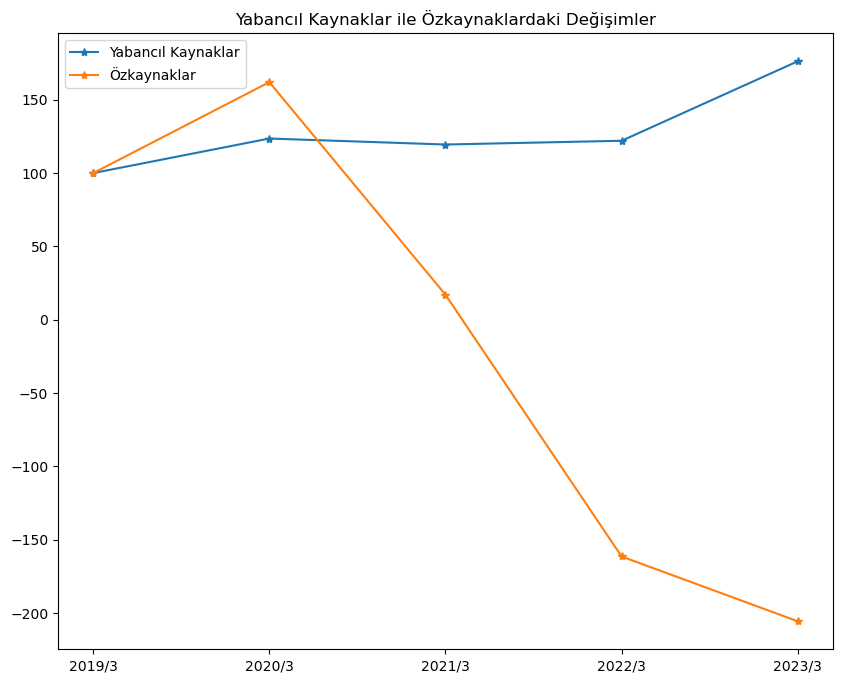

In [35]:
plt.figure(figsize=(10,8))
plt.plot(trend_analizi_bilanco.columns[5:],trend_analizi_bilanco.loc["Yabancıl Kaynaklar",trend_analizi_bilanco.columns[5:]],label="Yabancıl Kaynaklar",marker="*")
plt.plot(trend_analizi_bilanco.columns[5:],trend_analizi_bilanco.loc["Özkaynaklar",trend_analizi_bilanco.columns[5:]],label="Özkaynaklar",marker="*")
plt.title("Yabancıl Kaynaklar ile Özkaynaklardaki Değişimler")
plt.legend()
plt.show()

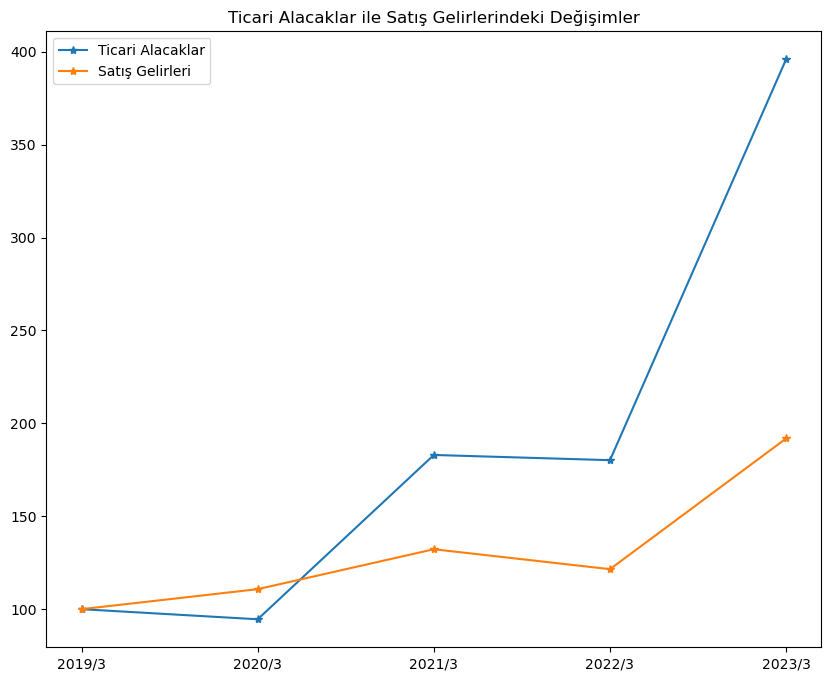

In [36]:
plt.figure(figsize=(10,8))
plt.plot(trend_analizi_bilanco.columns[5:],trend_analizi_bilanco.loc["  Ticari Alacaklar",trend_analizi_bilanco.columns[5:]],label="Ticari Alacaklar",marker="*")
plt.plot(trend_analizi_gt.columns[5:],trend_analizi_gt.loc["Satış Gelirleri",trend_analizi_bilanco.columns[5:]],label="Satış Gelirleri",marker="*")
plt.title("Ticari Alacaklar ile Satış Gelirlerindeki Değişimler")
plt.legend()
plt.show()

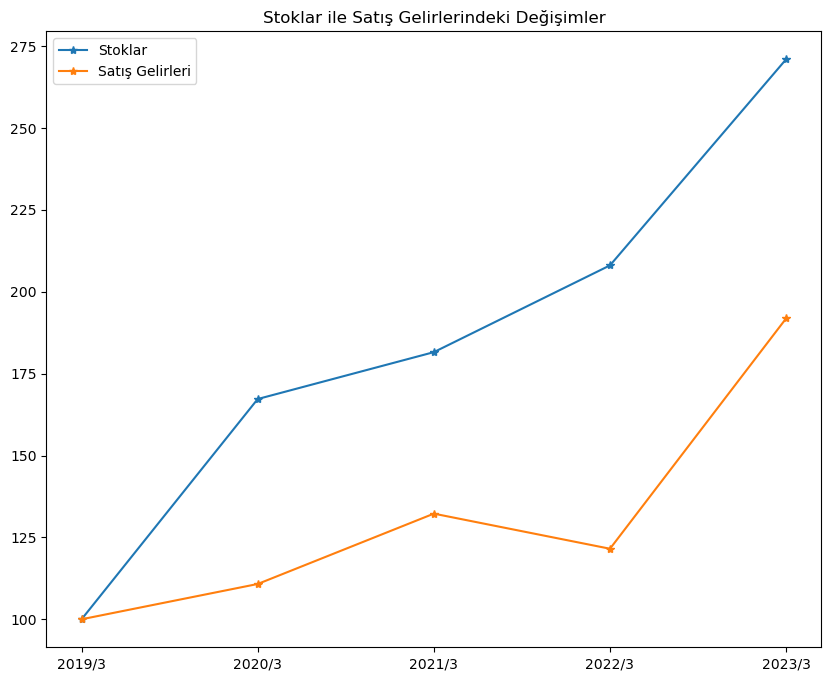

In [37]:
plt.figure(figsize=(10,8))
plt.plot(trend_analizi_bilanco.columns[5:],trend_analizi_bilanco.loc["  Stoklar",trend_analizi_bilanco.columns[5:]],label="Stoklar",marker="*")
plt.plot(trend_analizi_gt.columns[5:],trend_analizi_gt.loc["Satış Gelirleri",trend_analizi_bilanco.columns[5:]],label="Satış Gelirleri",marker="*")
plt.title("Stoklar ile Satış Gelirlerindeki Değişimler")
plt.legend()
plt.show()

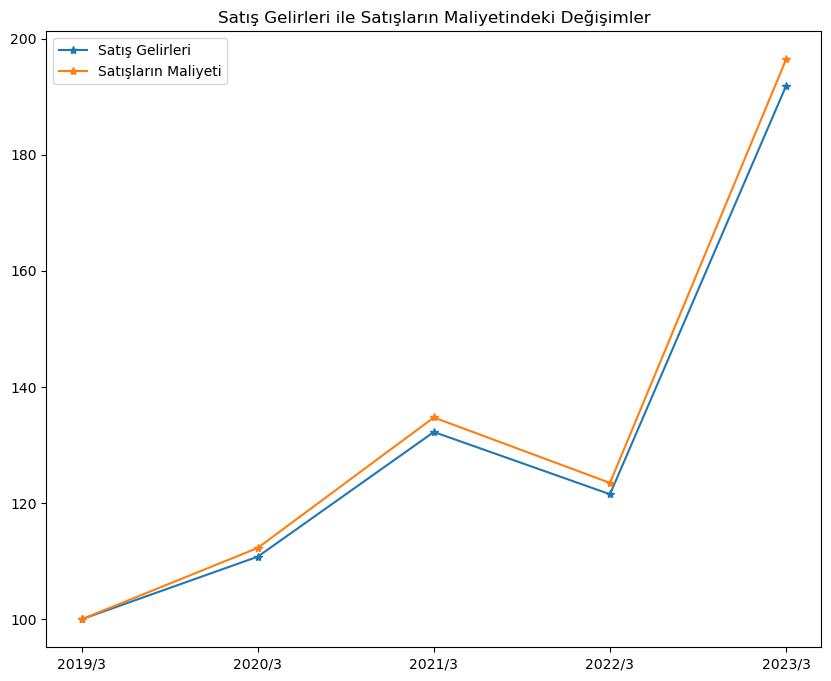

In [38]:
plt.figure(figsize=(10,8))
plt.plot(trend_analizi_gt.columns[5:],trend_analizi_gt.loc["Satış Gelirleri",trend_analizi_bilanco.columns[5:]],label="Satış Gelirleri",marker="*")
plt.plot(trend_analizi_gt.columns[5:],trend_analizi_gt.loc["Satışların Maliyeti (-)",trend_analizi_bilanco.columns[5:]],label="Satışların Maliyeti",marker="*")
plt.title("Satış Gelirleri ile Satışların Maliyetindeki Değişimler")
plt.legend()
plt.show()

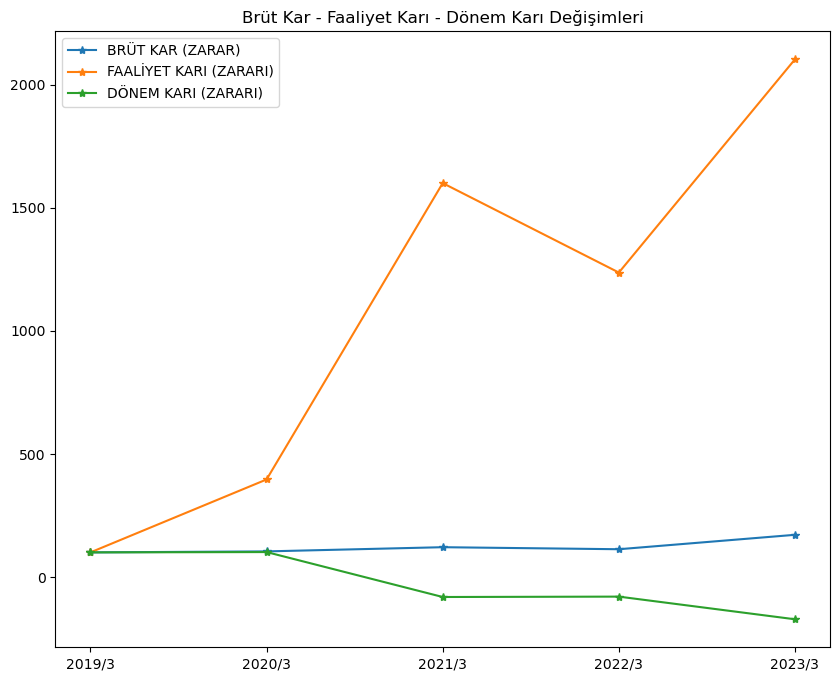

In [39]:
plt.figure(figsize=(10,8))
plt.plot(trend_analizi_gt.columns[5:],trend_analizi_gt.loc["BRÜT KAR (ZARAR)",trend_analizi_bilanco.columns[5:]],label="BRÜT KAR (ZARAR)",marker="*")
plt.plot(trend_analizi_gt.columns[5:],trend_analizi_gt.loc["FAALİYET KARI (ZARARI)",trend_analizi_bilanco.columns[5:]],label="FAALİYET KARI (ZARARI)",marker="*")
plt.plot(trend_analizi_gt.columns[5:],trend_analizi_gt.loc["DÖNEM KARI (ZARARI)",trend_analizi_bilanco.columns[5:]],label="DÖNEM KARI (ZARARI)",marker="*")
plt.title("Brüt Kar - Faaliyet Karı - Dönem Karı Değişimleri")
plt.legend()
plt.show()

## Likitide ve Kaldıraç Oranları

In [40]:
likitide_kaldirac=veri2.loc[["Dönen Varlıklar","Kısa Vadeli Yükümlülükler","  Nakit ve Nakit Benzerleri","  Stoklar","  Ticari Alacaklar","Duran Varlıklar",
                             "  Finansal Yatırımlar","Uzun Vadeli Yükümlülükler","Özkaynaklar","TOPLAM VARLIKLAR"]]

devamli_sermaye2=likitide_kaldirac.loc["Özkaynaklar",:]+likitide_kaldirac.loc["Uzun Vadeli Yükümlülükler",:]
devamli_sermaye2=pd.DataFrame(devamli_sermaye2)
devamli_sermaye2=devamli_sermaye2.T
devamli_sermaye2=devamli_sermaye2.rename(index={0:"Devamlı Sermaye"})
likitide_kaldirac=pd.concat([likitide_kaldirac,devamli_sermaye2],axis=0)

net_calisma_sermayesi=likitide_kaldirac.loc["Dönen Varlıklar",:]-likitide_kaldirac.loc["Kısa Vadeli Yükümlülükler",:]
net_calisma_sermayesi=pd.DataFrame(net_calisma_sermayesi)
net_calisma_sermayesi=net_calisma_sermayesi.T
net_calisma_sermayesi=net_calisma_sermayesi.rename(index={0:"Net Çalışma Sermayesi"})
likitide_kaldirac=pd.concat([likitide_kaldirac,net_calisma_sermayesi],axis=0)

cari_oran=round(likitide_kaldirac.loc["Dönen Varlıklar",:]/likitide_kaldirac.loc["Kısa Vadeli Yükümlülükler",:],2)
cari_oran=pd.DataFrame(cari_oran)
cari_oran=cari_oran.T
cari_oran=cari_oran.rename(index={0:"Cari Oran"})
likitide_kaldirac=pd.concat([likitide_kaldirac,cari_oran],axis=0)

asit_test_oran=round((likitide_kaldirac.loc["Dönen Varlıklar",:]-likitide_kaldirac.loc["  Stoklar",:])/likitide_kaldirac.loc["Kısa Vadeli Yükümlülükler",:],2)
asit_test_oran=pd.DataFrame(asit_test_oran)
asit_test_oran=asit_test_oran.T
asit_test_oran=asit_test_oran.rename(index={0:"Asit Test Oranı"})
likitide_kaldirac=pd.concat([likitide_kaldirac,asit_test_oran],axis=0)

nakit_oranı=round((likitide_kaldirac.loc["  Nakit ve Nakit Benzerleri",:]+likitide_kaldirac.loc["  Finansal Yatırımlar",:])/likitide_kaldirac.loc["Kısa Vadeli Yükümlülükler",:],2)
nakit_oranı=pd.DataFrame(nakit_oranı)
nakit_oranı=nakit_oranı.T
nakit_oranı=nakit_oranı.rename(index={0:"Nakit Oranı"})
likitide_kaldirac=pd.concat([likitide_kaldirac,nakit_oranı],axis=0)

stok_bagamlilik_orani=round((likitide_kaldirac.loc["Kısa Vadeli Yükümlülükler",:]-(likitide_kaldirac.loc["  Nakit ve Nakit Benzerleri",:]+likitide_kaldirac.loc["  Ticari Alacaklar",:]+likitide_kaldirac.loc["  Finansal Yatırımlar",:]))/likitide_kaldirac.loc["  Stoklar",:],2)
stok_bagamlilik_orani=pd.DataFrame(stok_bagamlilik_orani)
stok_bagamlilik_orani=stok_bagamlilik_orani.T
stok_bagamlilik_orani=stok_bagamlilik_orani.rename(index={0:"Stok Bağımlılık Oranı"})
likitide_kaldirac=pd.concat([likitide_kaldirac,stok_bagamlilik_orani],axis=0)

borc_aktif=round((likitide_kaldirac.loc["Kısa Vadeli Yükümlülükler",:]+likitide_kaldirac.loc["Uzun Vadeli Yükümlülükler",:])/likitide_kaldirac.loc["TOPLAM VARLIKLAR",:],2)
borc_aktif=pd.DataFrame(borc_aktif)
borc_aktif=borc_aktif.T
borc_aktif=borc_aktif.rename(index={0:"Borçların Aktif Toplamına Oranı"})
likitide_kaldirac=pd.concat([likitide_kaldirac,borc_aktif],axis=0)

ozkaynak_varlik=round(likitide_kaldirac.loc["Özkaynaklar",:]/likitide_kaldirac.loc["TOPLAM VARLIKLAR",:],2)
ozkaynak_varlik=pd.DataFrame(ozkaynak_varlik)
ozkaynak_varlik=ozkaynak_varlik.T
ozkaynak_varlik=ozkaynak_varlik.rename(index={0:"Özkaynakların Aktif Toplamına Oranı"})
likitide_kaldirac=pd.concat([likitide_kaldirac,ozkaynak_varlik],axis=0)

ozkaynak_borc=round(likitide_kaldirac.loc["Özkaynaklar",:]/(likitide_kaldirac.loc["Kısa Vadeli Yükümlülükler",:]+likitide_kaldirac.loc["Uzun Vadeli Yükümlülükler",:]),2)
ozkaynak_borc=pd.DataFrame(ozkaynak_borc)
ozkaynak_borc=ozkaynak_borc.T
ozkaynak_borc=ozkaynak_borc.rename(index={0:"Özkaynakların Toplam Borçlara Oranı"})
likitide_kaldirac=pd.concat([likitide_kaldirac,ozkaynak_borc],axis=0)

duran_varlik_sermaye=round(likitide_kaldirac.loc["Duran Varlıklar",:]/likitide_kaldirac.loc["Devamlı Sermaye",:],2)
duran_varlik_sermaye=pd.DataFrame(duran_varlik_sermaye)
duran_varlik_sermaye=duran_varlik_sermaye.T
duran_varlik_sermaye=duran_varlik_sermaye.rename(index={0:"Duran Varlıkların Devamlı Sermayeye Oranı"})
likitide_kaldirac=pd.concat([likitide_kaldirac,duran_varlik_sermaye],axis=0)

kvb_tb=round(likitide_kaldirac.loc["Kısa Vadeli Yükümlülükler",:]/(likitide_kaldirac.loc["Kısa Vadeli Yükümlülükler",:]+likitide_kaldirac.loc["Uzun Vadeli Yükümlülükler",:]),2)
kvb_tb=pd.DataFrame(kvb_tb)
kvb_tb=kvb_tb.T
kvb_tb=kvb_tb.rename(index={0:"Kısa Vadeli Borçların Toplam Borçlara Oranı"})
likitide_kaldirac=pd.concat([likitide_kaldirac,kvb_tb],axis=0)
likitide_kaldirac

,2018/3,2018/6,2018/9,2018/12,2019/3,2019/6,2019/9,2019/12,2020/3,2020/6,2020/9,2020/12,2021/3,2021/6,2021/9,2021/12,2022/3,2022/6,2022/9,2022/12,2023/3
Dönen Varlıklar,"577,857,000.00","679,485,000.00","656,428,000.00","592,569,000.00","723,189,000.00","816,878,000.00","719,033,000.00","994,466,000.00","996,801,000.00","1,177,577,000.00","1,373,087,000.00","1,565,441,000.00","1,408,056,000.00","1,635,830,000.00","1,781,450,000.00","2,623,534,000.00","2,969,045,000.00","3,434,232,000.00","4,897,601,000.00","5,438,562,000.00","5,760,428,000.00"
Kısa Vadeli Yükümlülükler,"791,415,000.00","900,256,000.00","876,492,000.00","855,233,000.00","1,087,728,000.00","1,211,428,000.00","1,129,533,000.00","1,481,539,000.00","1,513,529,000.00","1,707,710,000.00","1,831,613,000.00","1,943,979,000.00","1,793,630,000.00","1,758,574,000.00","1,864,638,000.00","2,626,956,000.00","2,900,603,000.00","3,305,937,000.00","4,704,917,000.00","5,204,062,000.00","5,466,739,000.00"
Nakit ve Nakit Benzerleri,"20,731,000.00","24,772,000.00","38,221,000.00","26,987,000.00","42,418,000.00","49,920,000.00","22,143,000.00","37,267,000.00","48,389,000.00","325,051,000.00","264,263,000.00","392,201,000.00","29,987,000.00","65,040,000.00","118,269,000.00","709,408,000.00","552,670,000.00","520,824,000.00","834,314,000.00","1,604,179,000.00","958,021,000.00"
Stoklar,"478,409,000.00","515,819,000.00","495,870,000.00","492,677,000.00","594,165,000.00","656,438,000.00","615,593,000.00","860,128,000.00","870,667,000.00","744,298,000.00","973,513,000.00","1,056,528,000.00","1,246,068,000.00","1,408,119,000.00","1,505,534,000.00","1,719,160,000.00","2,167,475,000.00","2,511,183,000.00","3,535,816,000.00","3,265,498,000.00","4,095,191,000.00"
Ticari Alacaklar,"63,997,000.00","95,645,000.00","84,404,000.00","65,775,000.00","60,965,000.00","87,917,000.00","74,225,000.00","66,362,000.00","60,877,000.00","87,635,000.00","86,787,000.00","103,297,000.00","106,416,000.00","129,897,000.00","123,574,000.00","155,925,000.00","186,331,000.00","264,020,000.00","308,536,000.00","441,042,000.00","527,834,000.00"
Duran Varlıklar,"173,128,000.00","174,783,000.00","174,898,000.00","167,856,000.00","564,022,000.00","552,486,000.00","534,574,000.00","518,110,000.00","477,334,000.00","451,231,000.00","424,544,000.00","395,209,000.00","392,394,000.00","383,887,000.00","362,268,000.00","377,562,000.00","372,263,000.00","569,573,000.00","666,891,000.00","858,986,000.00","1,005,559,000.00"
Finansal Yatırımlar,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Uzun Vadeli Yükümlülükler,"7,030,000.00","7,278,000.00","8,053,000.00","8,270,000.00","353,773,000.00","356,070,000.00","356,571,000.00","282,889,000.00","242,884,000.00","219,743,000.00","201,703,000.00","182,217,000.00","170,006,000.00","153,871,000.00","143,031,000.00","131,158,000.00","140,217,000.00","261,274,000.00","294,063,000.00","332,267,000.00","400,841,000.00"
Özkaynaklar,"-47,460,000.00","-53,266,000.00","-53,219,000.00","-103,078,000.00","-154,290,000.00","-198,134,000.00","-232,497,000.00","-251,852,000.00","-282,278,000.00","-298,645,000.00","-235,685,000.00","-165,546,000.00","-163,186,000.00","107,272,000.00","136,049,000.00","242,982,000.00","300,488,000.00","436,594,000.00","565,512,000.00","761,219,000.00","898,407,000.00"
TOPLAM VARLIKLAR,"750,985,000.00","854,268,000.00","831,326,000.00","760,425,000.00","1,287,211,000.00","1,369,364,000.00","1,253,607,000.00","1,512,576,000.00","1,474,135,000.00","1,628,808,000.00","1,797,631,000.00","1,960,650,000.00","1,800,450,000.00","2,019,717,000.00","2,143,718,000.00","3,001,096,000.00","3,341,308,000.00","4,003,805,000.00","5,564,492,000.00","6,297,548,000.00","6,765,987,000.00"


In [41]:
dosya5=likitide_kaldirac.to_excel("C:/Users/okand/Desktop/Mali Tablolar Analizi/python_ciktilari/likitide_kaldirac_oranlari.xlsx")

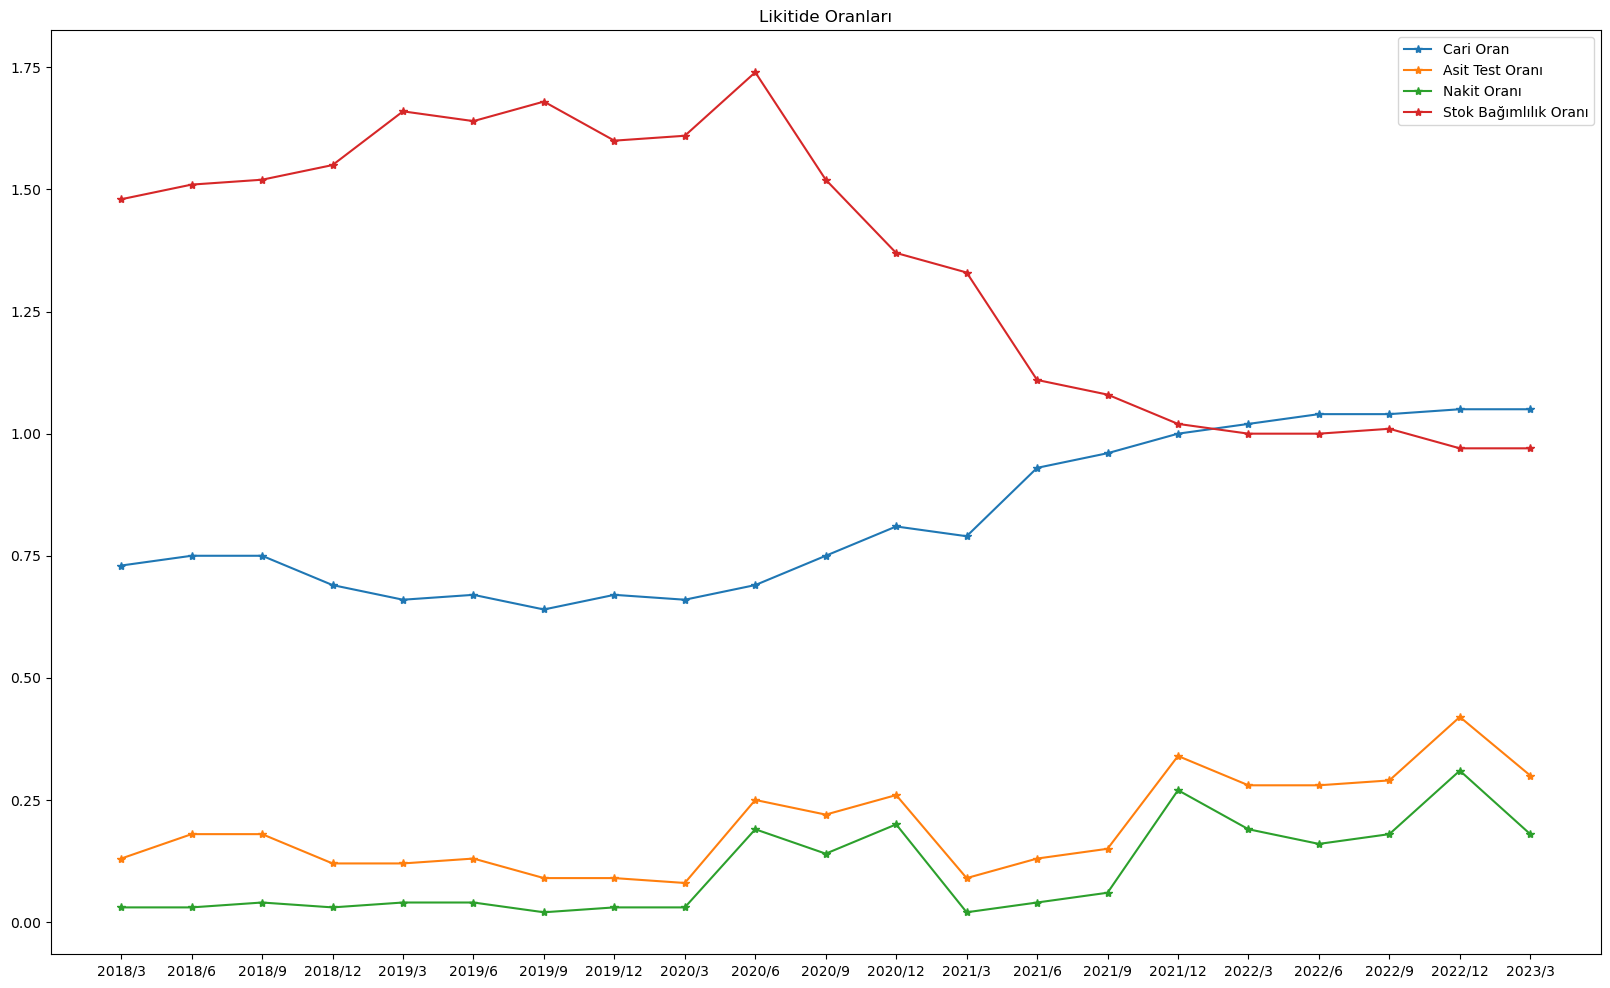

In [42]:
plt.figure(figsize=(20,12))
plt.plot(likitide_kaldirac.columns[:],likitide_kaldirac.loc["Cari Oran",:],label="Cari Oran",marker="*")
plt.plot(likitide_kaldirac.columns[:],likitide_kaldirac.loc["Asit Test Oranı",:],label="Asit Test Oranı",marker="*")
plt.plot(likitide_kaldirac.columns[:],likitide_kaldirac.loc["Nakit Oranı",:],label="Nakit Oranı",marker="*")
plt.plot(likitide_kaldirac.columns[:],likitide_kaldirac.loc["Stok Bağımlılık Oranı",:],label="Stok Bağımlılık Oranı",marker="*")
plt.title("Likitide Oranları")
plt.legend()
plt.show()

* Asit Test Oranı: Stokların nakde dönüşmesi zaman alıcı ve belirsiz olduğundan likitide oranı ile işletmenin stoklarını nakde dönüştürememesi durumunda kısa vadeli yükümlülüklerini ödeme durumu tespit edilir. Böylece cari orana göre daha hassas bir ölçü olarak kabul edilir. Arzu edilen değer %70.

* Stok Bağımlılık Oranı: Son yedi dönemde TKNSA'da kısa vadeli borçlarını ödemede stoklarına bağımlılığı azalmaktadır.

* Genelde arzu edilen 0.20 değerinin üzerinde.


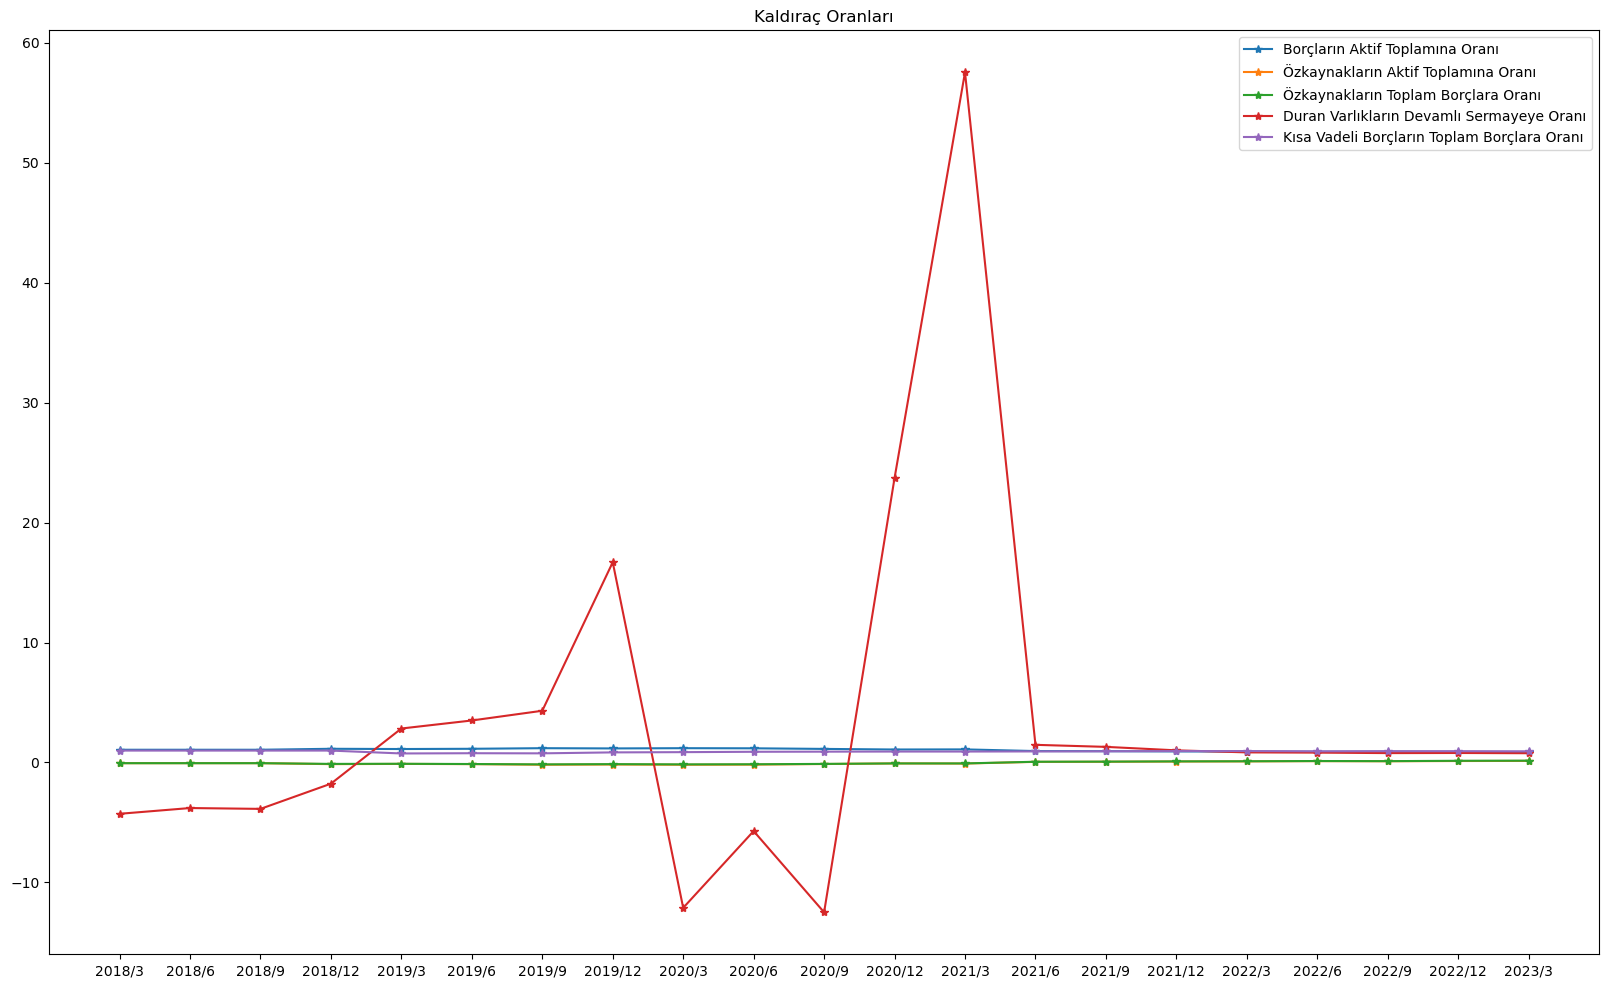

In [43]:
plt.figure(figsize=(20,12))
plt.plot(likitide_kaldirac.columns[:],likitide_kaldirac.loc["Borçların Aktif Toplamına Oranı",:],label="Borçların Aktif Toplamına Oranı",marker="*")
plt.plot(likitide_kaldirac.columns[:],likitide_kaldirac.loc["Özkaynakların Aktif Toplamına Oranı",:],label="Özkaynakların Aktif Toplamına Oranı",marker="*")
plt.plot(likitide_kaldirac.columns[:],likitide_kaldirac.loc["Özkaynakların Toplam Borçlara Oranı",:],label="Özkaynakların Toplam Borçlara Oranı",marker="*")
plt.plot(likitide_kaldirac.columns[:],likitide_kaldirac.loc["Duran Varlıkların Devamlı Sermayeye Oranı",:],label="Duran Varlıkların Devamlı Sermayeye Oranı",marker="*")
plt.plot(likitide_kaldirac.columns[:],likitide_kaldirac.loc["Kısa Vadeli Borçların Toplam Borçlara Oranı",:],label="Kısa Vadeli Borçların Toplam Borçlara Oranı",marker="*")
plt.title("Kaldıraç Oranları")
plt.legend()
plt.show()

* Son dönemde borçarın aktife oranı %87, öz kaynaklarının aktife oranı %13.

* Duran varlıkların devamlı sermayeye oranı %77 civarındadır. TKNSA'da her dönemde duran varlıklarının tamamını ve dönen varlıklarınında bir kısmını devamlı sermaye ile finanse etmektedir.

* Emek yoğun işletmelerde dönen varlıkların ve buna bağlı olarak toplam borçlar içinde kısa vadeli borçların yüksek olması normaldir.


## Faliyet Oranları

In [44]:
faliyet=yillik_veriler2.loc[["Satışların Maliyeti (-)","  Stoklar","Satış Gelirleri","  Ticari Alacaklar","  Ticari Borçlar",
                   "TOPLAM VARLIKLAR","Özkaynaklar"]]
faliyet.iloc[0,:]=-faliyet.iloc[0,:]
faliyet

,2018/12,2019/3,2019/6,2019/9,2019/12,2020/3,2020/6,2020/9,2020/12,2021/3,2021/6,2021/9,2021/12,2022/3,2022/6,2022/9,2022/12,2023/3
Bilanço,,,,,,,,,,,,,,,,,,
Satışların Maliyeti (-),2831234000,2868753000,2953831000,3066106000,3422374000,3598121000,3605792000,4129145000,4675836000,5010960000,5468179000,5730134000,6253253000,7389673000,8898777000,11022346000,14536722000,17750070000
Stoklar,492677000,608433000,633296000,612400000,860128000,1136630000,947988000,1218048000,1056528000,1431929000,1720349000,1588549000,1719160000,2640567000,2822224000,3749442000,3265498000,5193214000
Satış Gelirleri,3477020000,3511191000,3622350000,3739810000,4136971000,4344690000,4297728000,4931364000,5606519000,6019380000,6586253000,6883355000,7520079000,8901900000,10786011000,13357485000,17440964000,21219455000
Ticari Alacaklar,65775000,62743000,58047000,55596000,66362000,66274000,66080000,78924000,103297000,148836000,145559000,140084000,155925000,235840000,290048000,340887000,441042000,782545000
Ticari Borçlar,777142000,1192686000,1150425000,1023850000,1232640000,1294852000,1369550000,1546944000,1386364000,1653515000,1638765000,1822183000,2428265000,3642307000,3842743000,4998954000,4560737000,6747559000
TOPLAM VARLIKLAR,760425000,1296651000,1275521000,1182706000,1512576000,1699500000,1772020000,2056600000,1960650000,2286965000,2351559000,2306737000,3001096000,4541954000,4985184000,6421870000,6297548000,9722227000
Özkaynaklar,-103078000,-209908000,-247946000,-282356000,-251852000,-379840000,-352363000,-255040000,-165546000,-46454000,240371000,206188000,242982000,706656000,572304000,672445000,761219000,1359138000


In [45]:
stoklar=list(faliyet.iloc[1,:])
ticari_alacaklar=list(faliyet.iloc[3,:])
ticari_borclar=list(faliyet.iloc[4,:])
varliklar=list(faliyet.iloc[5,:])
ozkaynaklar=list(faliyet.iloc[6,:])

ort_stk=[]
ort_ta=[]
ort_tb=[]
ort_var=[]
ort_ozk=[]

for i in range(4):
    ort_stk.append(0)
    ort_ta.append(0)
    ort_tb.append(0)
    ort_var.append(0)
    ort_ozk.append(0)

for i in range(len(stoklar)-4):
    ort_stk.append((stoklar[i]+stoklar[i+4])/2)
    ort_ta.append((ticari_alacaklar[i]+ticari_alacaklar[i+4])/2)
    ort_tb.append((ticari_borclar[i]+ticari_borclar[i+4])/2)
    ort_var.append((varliklar[i]+varliklar[i+4])/2)
    ort_ozk.append((ozkaynaklar[i]+ozkaynaklar[i+4])/2)
    
faliyet.loc["Ortalama Stok"]=ort_stk
faliyet.loc["Ortalama Ticari Alacak"]=ort_ta
faliyet.loc["Ortalama Ticari Borç"]=ort_tb
faliyet.loc["Ortalama Varlıklar"]=ort_var
faliyet.loc["Ortalama Özkaynaklar"]=ort_ozk

faliyet

,2018/12,2019/3,2019/6,2019/9,2019/12,2020/3,2020/6,2020/9,2020/12,2021/3,2021/6,2021/9,2021/12,2022/3,2022/6,2022/9,2022/12,2023/3
Bilanço,,,,,,,,,,,,,,,,,,
Satışların Maliyeti (-),"2,831,234,000.00","2,868,753,000.00","2,953,831,000.00","3,066,106,000.00","3,422,374,000.00","3,598,121,000.00","3,605,792,000.00","4,129,145,000.00","4,675,836,000.00","5,010,960,000.00","5,468,179,000.00","5,730,134,000.00","6,253,253,000.00","7,389,673,000.00","8,898,777,000.00","11,022,346,000.00","14,536,722,000.00","17,750,070,000.00"
Stoklar,"492,677,000.00","608,433,000.00","633,296,000.00","612,400,000.00","860,128,000.00","1,136,630,000.00","947,988,000.00","1,218,048,000.00","1,056,528,000.00","1,431,929,000.00","1,720,349,000.00","1,588,549,000.00","1,719,160,000.00","2,640,567,000.00","2,822,224,000.00","3,749,442,000.00","3,265,498,000.00","5,193,214,000.00"
Satış Gelirleri,"3,477,020,000.00","3,511,191,000.00","3,622,350,000.00","3,739,810,000.00","4,136,971,000.00","4,344,690,000.00","4,297,728,000.00","4,931,364,000.00","5,606,519,000.00","6,019,380,000.00","6,586,253,000.00","6,883,355,000.00","7,520,079,000.00","8,901,900,000.00","10,786,011,000.00","13,357,485,000.00","17,440,964,000.00","21,219,455,000.00"
Ticari Alacaklar,"65,775,000.00","62,743,000.00","58,047,000.00","55,596,000.00","66,362,000.00","66,274,000.00","66,080,000.00","78,924,000.00","103,297,000.00","148,836,000.00","145,559,000.00","140,084,000.00","155,925,000.00","235,840,000.00","290,048,000.00","340,887,000.00","441,042,000.00","782,545,000.00"
Ticari Borçlar,"777,142,000.00","1,192,686,000.00","1,150,425,000.00","1,023,850,000.00","1,232,640,000.00","1,294,852,000.00","1,369,550,000.00","1,546,944,000.00","1,386,364,000.00","1,653,515,000.00","1,638,765,000.00","1,822,183,000.00","2,428,265,000.00","3,642,307,000.00","3,842,743,000.00","4,998,954,000.00","4,560,737,000.00","6,747,559,000.00"
TOPLAM VARLIKLAR,"760,425,000.00","1,296,651,000.00","1,275,521,000.00","1,182,706,000.00","1,512,576,000.00","1,699,500,000.00","1,772,020,000.00","2,056,600,000.00","1,960,650,000.00","2,286,965,000.00","2,351,559,000.00","2,306,737,000.00","3,001,096,000.00","4,541,954,000.00","4,985,184,000.00","6,421,870,000.00","6,297,548,000.00","9,722,227,000.00"
Özkaynaklar,"-103,078,000.00","-209,908,000.00","-247,946,000.00","-282,356,000.00","-251,852,000.00","-379,840,000.00","-352,363,000.00","-255,040,000.00","-165,546,000.00","-46,454,000.00","240,371,000.00","206,188,000.00","242,982,000.00","706,656,000.00","572,304,000.00","672,445,000.00","761,219,000.00","1,359,138,000.00"
Ortalama Stok,0.00,0.00,0.00,0.00,"676,402,500.00","872,531,500.00","790,642,000.00","915,224,000.00","958,328,000.00","1,284,279,500.00","1,334,168,500.00","1,403,298,500.00","1,387,844,000.00","2,036,248,000.00","2,271,286,500.00","2,668,995,500.00","2,492,329,000.00","3,916,890,500.00"
Ortalama Ticari Alacak,0.00,0.00,0.00,0.00,"66,068,500.00","64,508,500.00","62,063,500.00","67,260,000.00","84,829,500.00","107,555,000.00","105,819,500.00","109,504,000.00","129,611,000.00","192,338,000.00","217,803,500.00","240,485,500.00","298,483,500.00","509,192,500.00"


In [46]:
stok_devir_hizi=round(faliyet.loc["Satışların Maliyeti (-)",:]/faliyet.loc["Ortalama Stok",:],2)
stok_devir_hizi=pd.DataFrame(stok_devir_hizi)
stok_devir_hizi=stok_devir_hizi.T
stok_devir_hizi=stok_devir_hizi.rename(index={0:"Stok Devir Hızı"})
faliyet=pd.concat([faliyet,stok_devir_hizi],axis=0)

stok_tutma_suresi=round(360/faliyet.loc["Stok Devir Hızı",:],2)
stok_tutma_suresi=pd.DataFrame(stok_tutma_suresi)
stok_tutma_suresi=stok_tutma_suresi.T
stok_tutma_suresi=stok_tutma_suresi.rename(index={"Stok Devir Hızı":"Stok Tutma Süresi"})
faliyet=pd.concat([faliyet,stok_tutma_suresi],axis=0)

ticari_alacak_devir_hızı=round(faliyet.loc["Satış Gelirleri",:]/faliyet.loc["Ortalama Ticari Alacak",:],2)
ticari_alacak_devir_hızı=pd.DataFrame(ticari_alacak_devir_hızı)
ticari_alacak_devir_hızı=ticari_alacak_devir_hızı.T
ticari_alacak_devir_hızı=ticari_alacak_devir_hızı.rename(index={0:"Ticari Alacakların Devir Hızı"})
faliyet=pd.concat([faliyet,ticari_alacak_devir_hızı],axis=0)

ticari_alacak_tutma_suresi=round(360/faliyet.loc["Ticari Alacakların Devir Hızı",:],2)
ticari_alacak_tutma_suresi=pd.DataFrame(ticari_alacak_tutma_suresi)
ticari_alacak_tutma_suresi=ticari_alacak_tutma_suresi.T
ticari_alacak_tutma_suresi=ticari_alacak_tutma_suresi.rename(index={"Ticari Alacakların Devir Hızı":"Ticari Alacakların Ortalama Tahsil Süresi"})
faliyet=pd.concat([faliyet,ticari_alacak_tutma_suresi],axis=0)

ticari_borc_devir_hızı=round(faliyet.loc["Satışların Maliyeti (-)",:]/faliyet.loc["Ortalama Ticari Borç",:],2)
ticari_borc_devir_hızı=pd.DataFrame(ticari_borc_devir_hızı)
ticari_borc_devir_hızı=ticari_borc_devir_hızı.T
ticari_borc_devir_hızı=ticari_borc_devir_hızı.rename(index={0:"Ticari Borçların Devir Hızı"})
faliyet=pd.concat([faliyet,ticari_borc_devir_hızı],axis=0)

ticari_borc_odeme_suresi=round(360/faliyet.loc["Ticari Borçların Devir Hızı",:],2)
ticari_borc_odeme_suresi=pd.DataFrame(ticari_borc_odeme_suresi)
ticari_borc_odeme_suresi=ticari_borc_odeme_suresi.T
ticari_borc_odeme_suresi=ticari_borc_odeme_suresi.rename(index={"Ticari Borçların Devir Hızı":"Ticari Borçların Ortalama Ödenme Süreleri"})
faliyet=pd.concat([faliyet,ticari_borc_odeme_suresi],axis=0)


ticari_varlık_devir_hızı=round(faliyet.loc["Satış Gelirleri",:]/faliyet.loc["Ortalama Varlıklar",:],2)
ticari_varlık_devir_hızı=pd.DataFrame(ticari_varlık_devir_hızı)
ticari_varlık_devir_hızı=ticari_varlık_devir_hızı.T
ticari_varlık_devir_hızı=ticari_varlık_devir_hızı.rename(index={0:"Varlık Devir Hızı"})
faliyet=pd.concat([faliyet,ticari_varlık_devir_hızı],axis=0)

özkaynak_devir_hızı=round(faliyet.loc["Satış Gelirleri",:]/faliyet.loc["Ortalama Özkaynaklar",:],2)
özkaynak_devir_hızı=pd.DataFrame(özkaynak_devir_hızı)
özkaynak_devir_hızı=özkaynak_devir_hızı.T
özkaynak_devir_hızı=özkaynak_devir_hızı.rename(index={0:"Öz Kaynak Devir Hızı"})
faliyet=pd.concat([faliyet,özkaynak_devir_hızı],axis=0)

faliyet.loc["Nakde Dönüşüm Süresi",:]=faliyet.loc["Stok Tutma Süresi",:]+faliyet.loc["Ticari Alacakların Ortalama Tahsil Süresi",:]-faliyet.loc["Ticari Borçların Ortalama Ödenme Süreleri",:]
faliyet

,2018/12,2019/3,2019/6,2019/9,2019/12,2020/3,2020/6,2020/9,2020/12,2021/3,2021/6,2021/9,2021/12,2022/3,2022/6,2022/9,2022/12,2023/3
Satışların Maliyeti (-),"2,831,234,000.00","2,868,753,000.00","2,953,831,000.00","3,066,106,000.00","3,422,374,000.00","3,598,121,000.00","3,605,792,000.00","4,129,145,000.00","4,675,836,000.00","5,010,960,000.00","5,468,179,000.00","5,730,134,000.00","6,253,253,000.00","7,389,673,000.00","8,898,777,000.00","11,022,346,000.00","14,536,722,000.00","17,750,070,000.00"
Stoklar,"492,677,000.00","608,433,000.00","633,296,000.00","612,400,000.00","860,128,000.00","1,136,630,000.00","947,988,000.00","1,218,048,000.00","1,056,528,000.00","1,431,929,000.00","1,720,349,000.00","1,588,549,000.00","1,719,160,000.00","2,640,567,000.00","2,822,224,000.00","3,749,442,000.00","3,265,498,000.00","5,193,214,000.00"
Satış Gelirleri,"3,477,020,000.00","3,511,191,000.00","3,622,350,000.00","3,739,810,000.00","4,136,971,000.00","4,344,690,000.00","4,297,728,000.00","4,931,364,000.00","5,606,519,000.00","6,019,380,000.00","6,586,253,000.00","6,883,355,000.00","7,520,079,000.00","8,901,900,000.00","10,786,011,000.00","13,357,485,000.00","17,440,964,000.00","21,219,455,000.00"
Ticari Alacaklar,"65,775,000.00","62,743,000.00","58,047,000.00","55,596,000.00","66,362,000.00","66,274,000.00","66,080,000.00","78,924,000.00","103,297,000.00","148,836,000.00","145,559,000.00","140,084,000.00","155,925,000.00","235,840,000.00","290,048,000.00","340,887,000.00","441,042,000.00","782,545,000.00"
Ticari Borçlar,"777,142,000.00","1,192,686,000.00","1,150,425,000.00","1,023,850,000.00","1,232,640,000.00","1,294,852,000.00","1,369,550,000.00","1,546,944,000.00","1,386,364,000.00","1,653,515,000.00","1,638,765,000.00","1,822,183,000.00","2,428,265,000.00","3,642,307,000.00","3,842,743,000.00","4,998,954,000.00","4,560,737,000.00","6,747,559,000.00"
TOPLAM VARLIKLAR,"760,425,000.00","1,296,651,000.00","1,275,521,000.00","1,182,706,000.00","1,512,576,000.00","1,699,500,000.00","1,772,020,000.00","2,056,600,000.00","1,960,650,000.00","2,286,965,000.00","2,351,559,000.00","2,306,737,000.00","3,001,096,000.00","4,541,954,000.00","4,985,184,000.00","6,421,870,000.00","6,297,548,000.00","9,722,227,000.00"
Özkaynaklar,"-103,078,000.00","-209,908,000.00","-247,946,000.00","-282,356,000.00","-251,852,000.00","-379,840,000.00","-352,363,000.00","-255,040,000.00","-165,546,000.00","-46,454,000.00","240,371,000.00","206,188,000.00","242,982,000.00","706,656,000.00","572,304,000.00","672,445,000.00","761,219,000.00","1,359,138,000.00"
Ortalama Stok,0.00,0.00,0.00,0.00,"676,402,500.00","872,531,500.00","790,642,000.00","915,224,000.00","958,328,000.00","1,284,279,500.00","1,334,168,500.00","1,403,298,500.00","1,387,844,000.00","2,036,248,000.00","2,271,286,500.00","2,668,995,500.00","2,492,329,000.00","3,916,890,500.00"
Ortalama Ticari Alacak,0.00,0.00,0.00,0.00,"66,068,500.00","64,508,500.00","62,063,500.00","67,260,000.00","84,829,500.00","107,555,000.00","105,819,500.00","109,504,000.00","129,611,000.00","192,338,000.00","217,803,500.00","240,485,500.00","298,483,500.00","509,192,500.00"
Ortalama Ticari Borç,0.00,0.00,0.00,0.00,"1,004,891,000.00","1,243,769,000.00","1,259,987,500.00","1,285,397,000.00","1,309,502,000.00","1,474,183,500.00","1,504,157,500.00","1,684,563,500.00","1,907,314,500.00","2,647,911,000.00","2,740,754,000.00","3,410,568,500.00","3,494,501,000.00","5,194,933,000.00"


In [47]:
dosya6=faliyet.to_excel("C:/Users/okand/Desktop/Mali Tablolar Analizi/python_ciktilari/faaliyet_oranlari.xlsx")

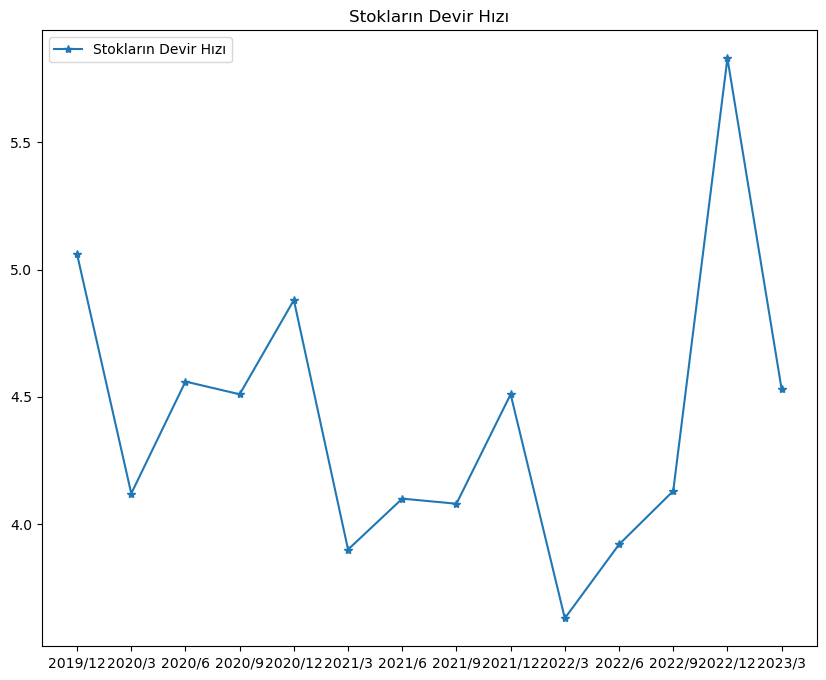

In [48]:
plt.figure(figsize=(10,8))
plt.plot(faliyet.columns[4:],faliyet.loc["Stok Devir Hızı",faliyet.columns[4:]],label="Stokların Devir Hızı",marker="*")
plt.title("Stokların Devir Hızı")
plt.legend()
plt.show()

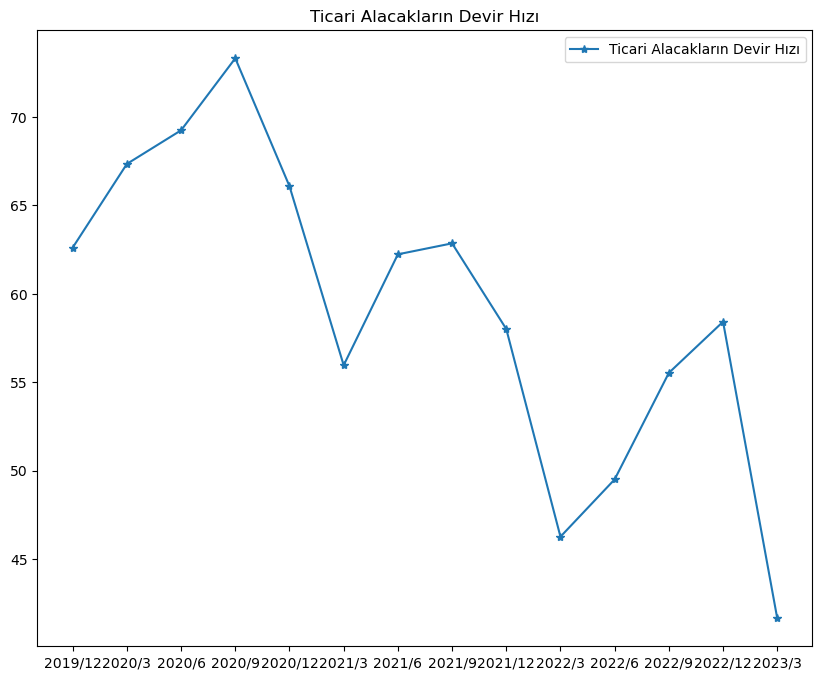

In [49]:
plt.figure(figsize=(10,8))
plt.plot(faliyet.columns[4:],faliyet.loc["Ticari Alacakların Devir Hızı",faliyet.columns[4:]],label="Ticari Alacakların Devir Hızı",marker="*")
plt.title("Ticari Alacakların Devir Hızı")
plt.legend()
plt.show()

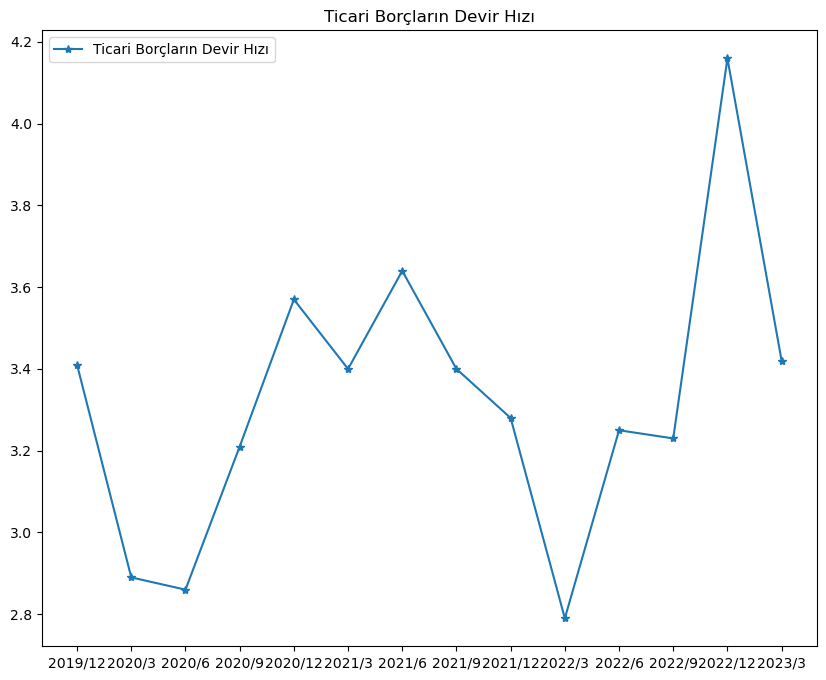

In [50]:
plt.figure(figsize=(10,8))
plt.plot(faliyet.columns[4:],faliyet.loc["Ticari Borçların Devir Hızı",faliyet.columns[4:]],label="Ticari Borçların Devir Hızı",marker="*")
plt.title("Ticari Borçların Devir Hızı")
plt.legend()
plt.show()

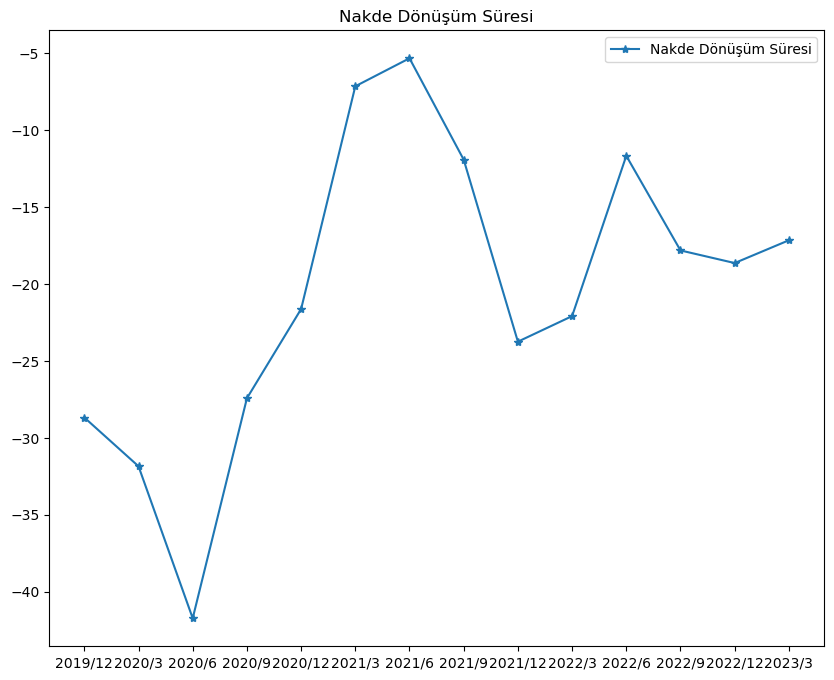

In [51]:
plt.figure(figsize=(10,8))
plt.plot(faliyet.columns[4:],faliyet.loc["Nakde Dönüşüm Süresi",faliyet.columns[4:]],label="Nakde Dönüşüm Süresi",marker="*")
plt.title("Nakde Dönüşüm Süresi")
plt.legend()
plt.show()

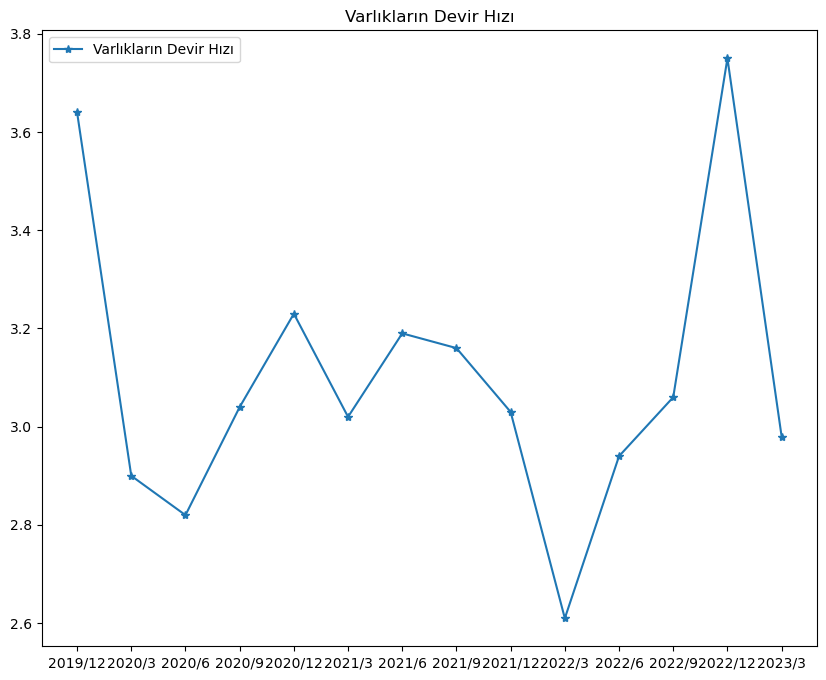

In [52]:
plt.figure(figsize=(10,8))
plt.plot(faliyet.columns[4:],faliyet.loc["Varlık Devir Hızı",faliyet.columns[4:]],label="Varlıkların Devir Hızı",marker="*")
plt.title("Varlıkların Devir Hızı")
plt.legend()
plt.show()

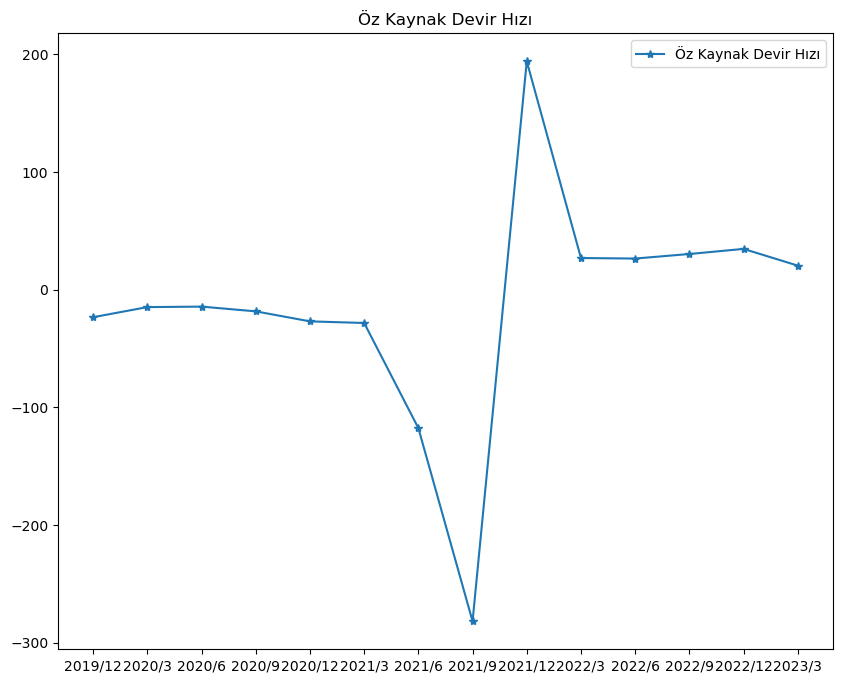

In [53]:
plt.figure(figsize=(10,8))
plt.plot(faliyet.columns[4:],faliyet.loc["Öz Kaynak Devir Hızı",faliyet.columns[4:]],label="Öz Kaynak Devir Hızı",marker="*")
plt.title("Öz Kaynak Devir Hızı")
plt.legend()
plt.show()

## Karlılık Oranları

In [54]:
karlılık=yillik_veriler2.loc[["Satış Gelirleri","BRÜT KAR (ZARAR)","FAALİYET KARI (ZARARI)","SÜRDÜRÜLEN FAALİYETLER VERGİ ÖNCESİ KARI (ZARARI)",
                              "SÜRDÜRÜLEN FAALİYETLER DÖNEM KARI/ZARARI","DÖNEM KARI (ZARARI)","TOPLAM VARLIKLAR","Finansman Gideri Öncesi Faaliyet Karı/Zararı",
                              "(Esas Faaliyet Dışı) Finansal Giderler (-)","Özkaynaklar","  Ödenmiş Sermaye"]]
karlılık.iloc[8,:]=-karlılık.iloc[8,:]
karlılık.loc["Ortalama Varlıklar",:]=faliyet.loc["Ortalama Varlıklar",:]
karlılık.loc["Ortalama Özkaynaklar",:]=faliyet.loc["Ortalama Özkaynaklar",:]
karlılık.loc["Brüt Kar Marjı",:]=round(karlılık.loc["BRÜT KAR (ZARAR)",:]/karlılık.loc["Satış Gelirleri",:],2)
karlılık.loc["Esas Faaliyet Kar Marjı",:]=round(karlılık.loc["FAALİYET KARI (ZARARI)",:]/karlılık.loc["Satış Gelirleri",:],2)
karlılık.loc["Sürdürülen Faaliyetler Dönem Kar Marjı",:]=round(karlılık.loc["SÜRDÜRÜLEN FAALİYETLER DÖNEM KARI/ZARARI",:]/karlılık.loc["Satış Gelirleri",:],2)
karlılık.loc["Dönem Kar Marjı",:]=round(karlılık.loc["DÖNEM KARI (ZARARI)",:]/karlılık.loc["Satış Gelirleri",:],2)
karlılık.loc["Varlıkların Karlılık Oranı",:]=round(karlılık.loc["DÖNEM KARI (ZARARI)"]/karlılık.loc["Ortalama Varlıklar"],2)
karlılık.loc["Ekonomi Rantalibite Oranı",:]=round(karlılık.loc["Finansman Gideri Öncesi Faaliyet Karı/Zararı"]/karlılık.loc["Ortalama Varlıklar"],2)
karlılık.loc["Öz Kaynakların Karlılık Oranı",:]=round(karlılık.loc["DÖNEM KARI (ZARARI)"]/karlılık.loc["Ortalama Özkaynaklar"],2)
karlılık.loc["Hisse Başına Karlılık",:]=round(karlılık.loc["DÖNEM KARI (ZARARI)"]/karlılık.loc["  Ödenmiş Sermaye"],2)
karlılık

,2018/12,2019/3,2019/6,2019/9,2019/12,2020/3,2020/6,2020/9,2020/12,2021/3,2021/6,2021/9,2021/12,2022/3,2022/6,2022/9,2022/12,2023/3
Bilanço,,,,,,,,,,,,,,,,,,
Satış Gelirleri,"3,477,020,000.00","3,511,191,000.00","3,622,350,000.00","3,739,810,000.00","4,136,971,000.00","4,344,690,000.00","4,297,728,000.00","4,931,364,000.00","5,606,519,000.00","6,019,380,000.00","6,586,253,000.00","6,883,355,000.00","7,520,079,000.00","8,901,900,000.00","10,786,011,000.00","13,357,485,000.00","17,440,964,000.00","21,219,455,000.00"
BRÜT KAR (ZARAR),"645,786,000.00","642,438,000.00","668,519,000.00","673,704,000.00","714,597,000.00","746,569,000.00","691,936,000.00","802,219,000.00","930,683,000.00","1,008,420,000.00","1,118,074,000.00","1,153,221,000.00","1,266,826,000.00","1,512,227,000.00","1,887,234,000.00","2,335,139,000.00","2,904,242,000.00","3,469,385,000.00"
FAALİYET KARI (ZARARI),"49,818,000.00","17,215,000.00","2,298,000.00","-13,006,000.00","41,579,000.00","76,224,000.00","102,959,000.00","212,066,000.00","309,778,000.00","357,211,000.00","383,542,000.00","364,379,000.00","367,688,000.00","444,320,000.00","611,999,000.00","762,923,000.00","955,083,000.00","1,140,916,000.00"
SÜRDÜRÜLEN FAALİYETLER VERGİ ÖNCESİ KARI (ZARARI),"-54,486,000.00","-114,461,000.00","-162,429,000.00","-206,107,000.00","-177,887,000.00","-150,805,000.00","-117,649,000.00","3,794,000.00","111,208,000.00","153,115,000.00","161,985,000.00","123,357,000.00","139,406,000.00","209,305,000.00","354,196,000.00","484,654,000.00","601,287,000.00","688,632,000.00"
SÜRDÜRÜLEN FAALİYETLER DÖNEM KARI/ZARARI,"-64,609,000.00","-112,499,000.00","-148,667,000.00","-183,940,000.00","-148,634,000.00","-127,304,000.00","-101,171,000.00","-3,359,000.00","85,296,000.00","118,556,000.00","129,207,000.00","96,076,000.00","131,464,000.00","187,138,000.00","326,078,000.00","437,187,000.00","524,927,000.00","608,884,000.00"
DÖNEM KARI (ZARARI),"-64,609,000.00","-112,499,000.00","-148,667,000.00","-183,940,000.00","-148,634,000.00","-127,304,000.00","-101,171,000.00","-3,359,000.00","85,296,000.00","118,556,000.00","129,207,000.00","96,076,000.00","131,464,000.00","187,138,000.00","326,078,000.00","437,187,000.00","524,927,000.00","608,884,000.00"
TOPLAM VARLIKLAR,"760,425,000.00","1,296,651,000.00","1,275,521,000.00","1,182,706,000.00","1,512,576,000.00","1,699,500,000.00","1,772,020,000.00","2,056,600,000.00","1,960,650,000.00","2,286,965,000.00","2,351,559,000.00","2,306,737,000.00","3,001,096,000.00","4,541,954,000.00","4,985,184,000.00","6,421,870,000.00","6,297,548,000.00","9,722,227,000.00"
Finansman Gideri Öncesi Faaliyet Karı/Zararı,"43,602,000.00","11,472,000.00","-3,783,000.00","-19,392,000.00","36,901,000.00","70,692,000.00","98,263,000.00","209,579,000.00","319,064,000.00","370,389,000.00","396,809,000.00","375,702,000.00","387,136,000.00","467,527,000.00","642,169,000.00","808,617,000.00","1,065,119,000.00","1,283,036,000.00"
(Esas Faaliyet Dışı) Finansal Giderler (-),"98,088,000.00","125,933,000.00","158,646,000.00","187,400,000.00","215,549,000.00","222,289,000.00","217,935,000.00","211,106,000.00","214,737,000.00","224,460,000.00","242,509,000.00","256,212,000.00","265,856,000.00","289,491,000.00","335,389,000.00","401,979,000.00","532,440,000.00","652,618,000.00"


In [55]:
dosya7=karlılık.to_excel("C:/Users/okand/Desktop/Mali Tablolar Analizi/python_ciktilari/karlilik_oranlari.xlsx")

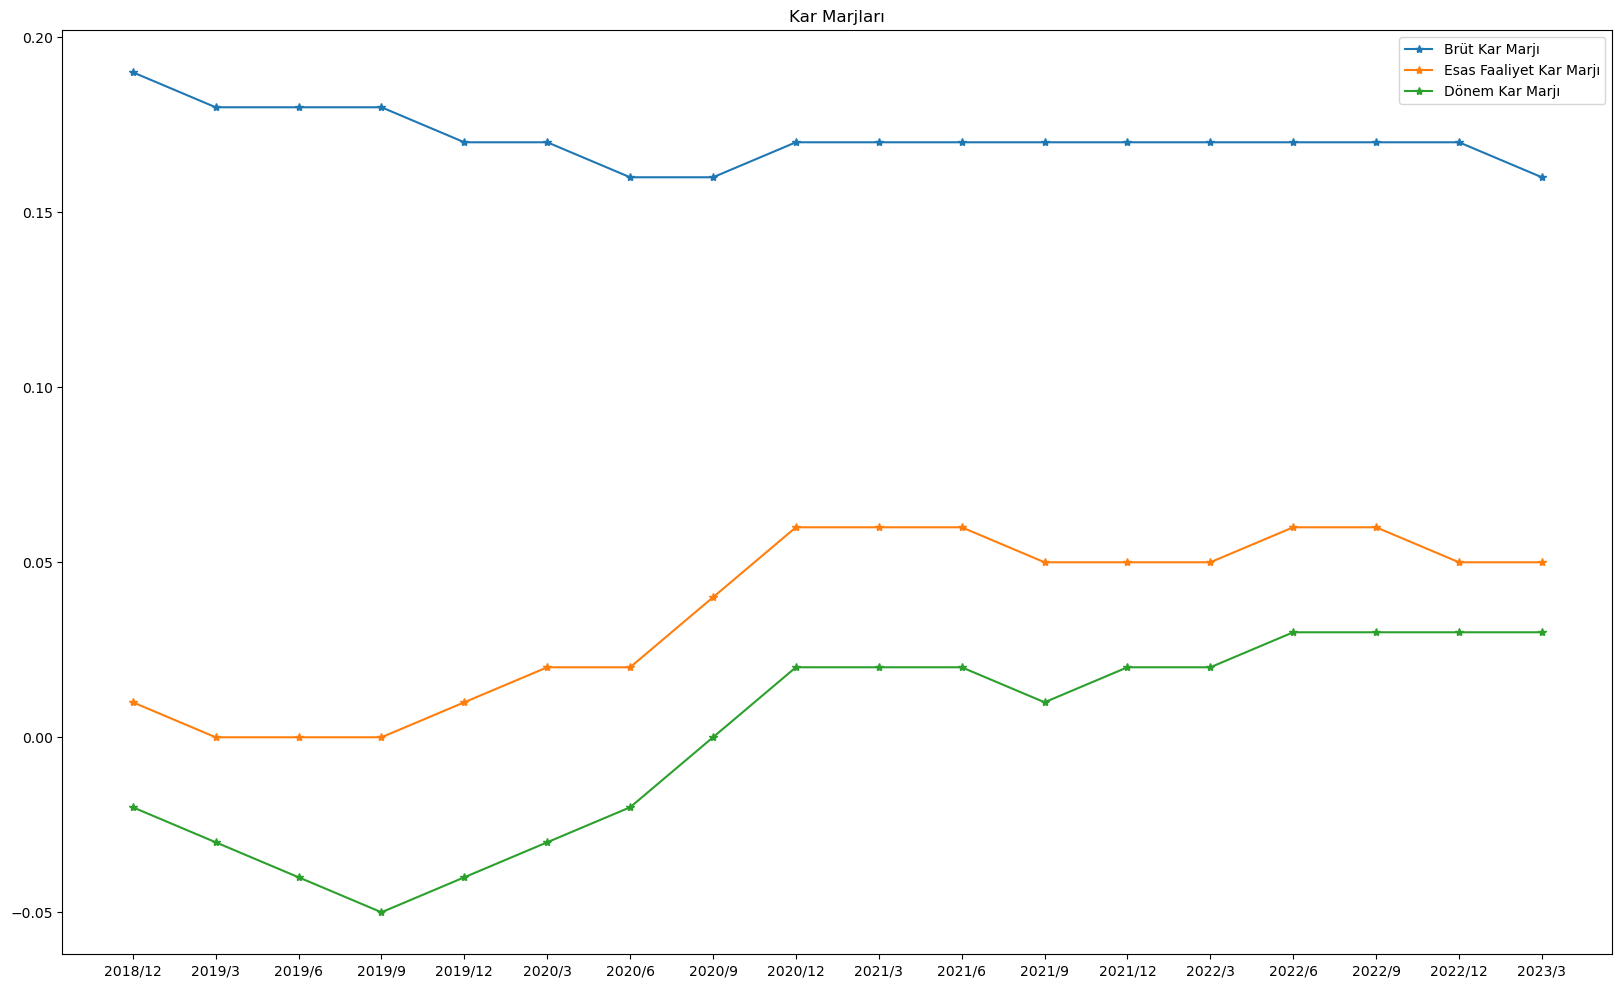

In [56]:
plt.figure(figsize=(20,12))
plt.plot(karlılık.columns[:],karlılık.loc["Brüt Kar Marjı",:],label="Brüt Kar Marjı",marker="*")
plt.plot(karlılık.columns[:],karlılık.loc["Esas Faaliyet Kar Marjı",:],label="Esas Faaliyet Kar Marjı",marker="*")
plt.plot(karlılık.columns[:],karlılık.loc["Dönem Kar Marjı",:],label="Dönem Kar Marjı",marker="*")
plt.title("Kar Marjları")
plt.legend()
plt.show()

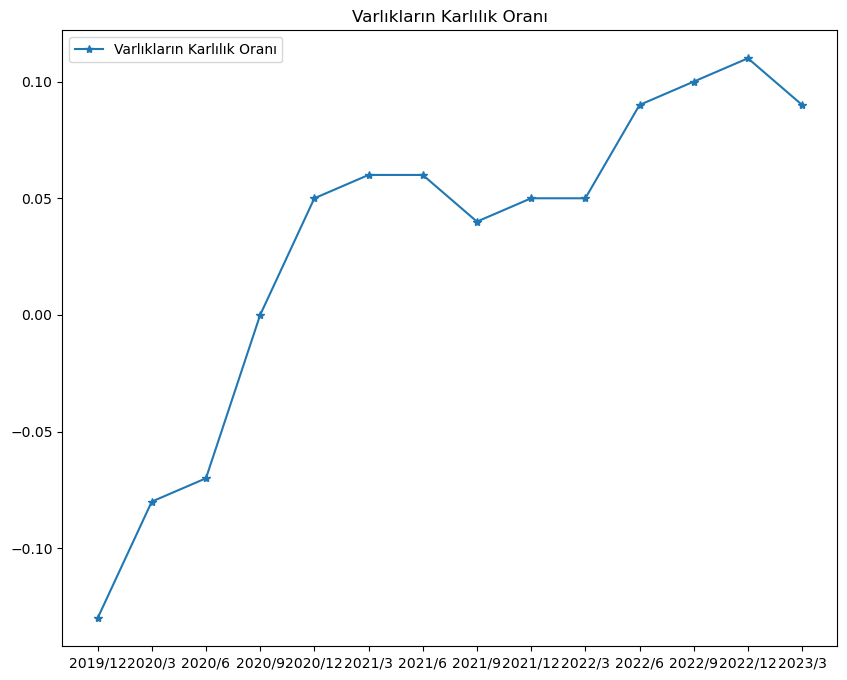

In [57]:
plt.figure(figsize=(10,8))
plt.plot(karlılık.columns[4:],karlılık.loc["Varlıkların Karlılık Oranı",karlılık.columns[4:]],label="Varlıkların Karlılık Oranı",marker="*")
plt.title("Varlıkların Karlılık Oranı")
plt.legend()
plt.show()

Varlıkların karlılık oranı, işletmenin varlıklara yapmış olduğu yatırımın sonucunda elde ettiği karlılığı ve varlıkların etkin kullanılıp kullanılmadığını göstermektedir.

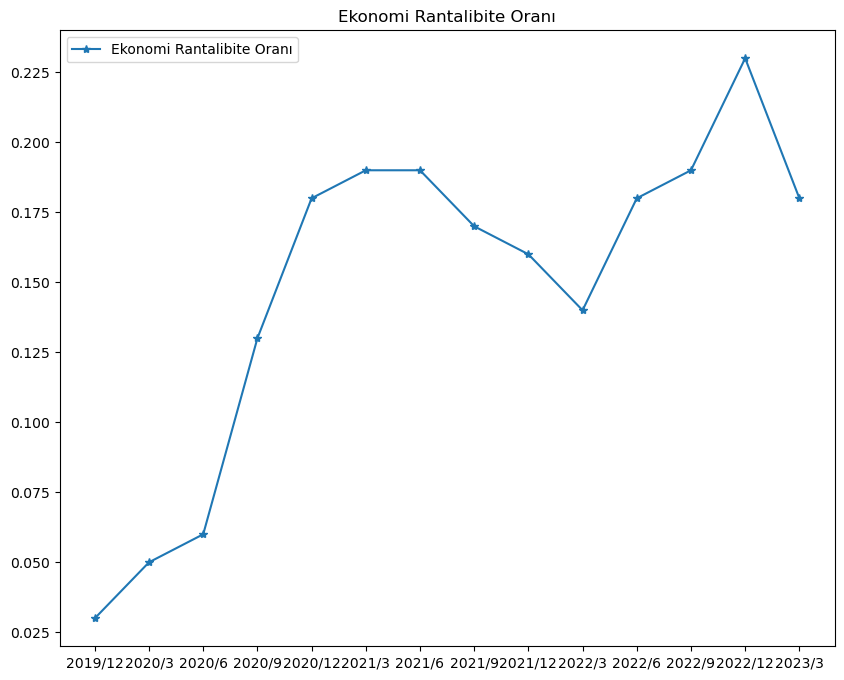

In [58]:
plt.figure(figsize=(10,8))
plt.plot(karlılık.columns[4:],karlılık.loc["Ekonomi Rantalibite Oranı",karlılık.columns[4:]],label="Ekonomi Rantalibite Oranı",marker="*")
plt.title("Ekonomi Rantalibite Oranı")
plt.legend()
plt.show()

Ekonomik rantabilite oranı işletmenin toplam kaynaklarının ne ölçüde karlı kullanıldığını gösterir. Oran, işletmeye yatırılan fonların getirisini ölçmede kullanılır.

Ekonomik rantabilite oranı temel kazanma gücü oranı olarak da isimlendirilir. Böyle bir isimlendirme firma varlıklarının esas faaliyet karı üretme gücünü ölçme mantığına dayanmaktadır.

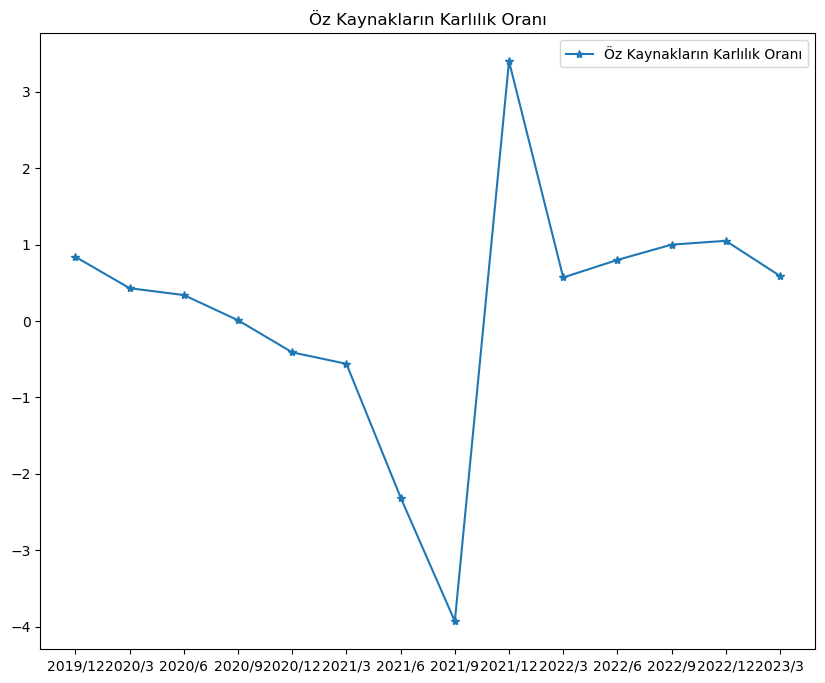

In [59]:
plt.figure(figsize=(10,8))
plt.plot(karlılık.columns[4:],karlılık.loc["Öz Kaynakların Karlılık Oranı",karlılık.columns[4:]],label="Öz Kaynakların Karlılık Oranı",marker="*")
plt.title("Öz Kaynakların Karlılık Oranı")
plt.legend()
plt.show()

Öz kaynakların karlılık oranı, ortaklarca işletmeye konan öz sermayenin etkin kullanımının iyi bir göstergesidir.

* İşletmeler fon ihtiyaçları için yabancıl kaynak kullandıkları takdirde bu kaynakların bir bedeli olarak faiz öderler. Ödenen faiz vergi kanunlarınca gider kabul edilmektedir. Sonuç olarak daha az vergi ödenmesiyle hisse başına karlılık artacaktır. Bu durum literatürde fainansal kaldıraç etkisi olarak ifade edilir. İşletme finansal kaldıraç etkisini etkin kullanması sonucunda dönem karı ve öz kaynakların karlılık oranı artacaktır.

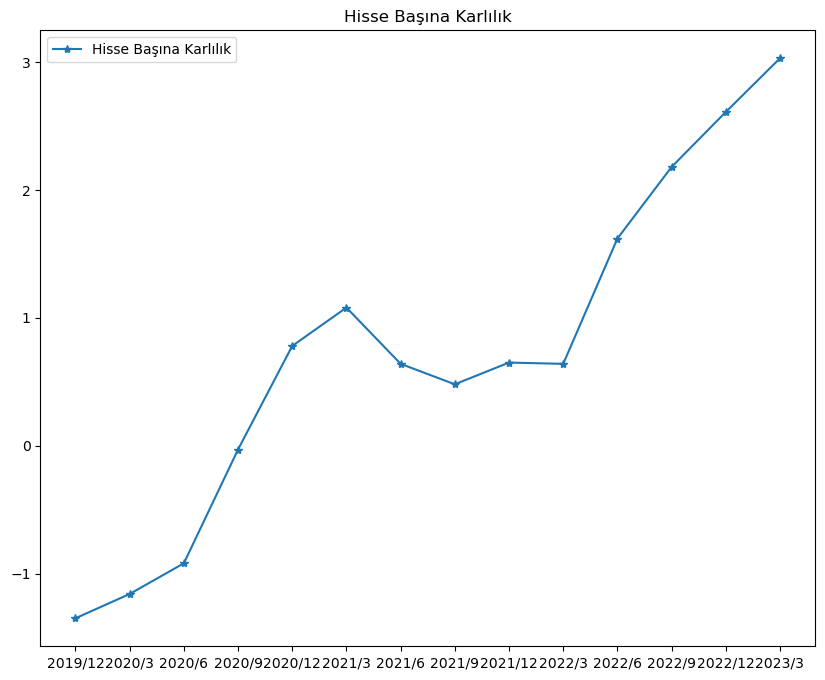

In [60]:
plt.figure(figsize=(10,8))
plt.plot(karlılık.columns[4:],karlılık.loc["Hisse Başına Karlılık",karlılık.columns[4:]],label="Hisse Başına Karlılık",marker="*")
plt.title("Hisse Başına Karlılık")
plt.legend()
plt.show()

## Büyüme Oranları

In [61]:
buyume=karlılık.iloc[[0,5,6,9],:]
satis_oran=[]
kar_oran=[]
varlik_oran=[]
ozkaynak_oran=[]
satis_oran.append(0)
kar_oran.append(0)
varlik_oran.append(0)
ozkaynak_oran.append(0)
satis=list(buyume.loc["Satış Gelirleri",:])
donem_kar=list(buyume.loc["DÖNEM KARI (ZARARI)",:])
varlik=list(buyume.loc["TOPLAM VARLIKLAR",:])
ozkaynak=list(buyume.loc["Özkaynaklar",:])
for i in range(len(satis)-1):
    satis_oran.append(round((satis[i+1]-satis[i])/satis[i],2))
    kar_oran.append(round((donem_kar[i+1]-donem_kar[i])/donem_kar[i],2))
    varlik_oran.append(round((varlik[i+1]-varlik[i])/varlik[i],2))
    ozkaynak_oran.append(round((ozkaynak[i+1]-ozkaynak[i])/ozkaynak[i],2))
    
buyume.loc["Satış Hasılatındaki Büyüme Oranı",:]=satis_oran
buyume.loc["Dönem Karındaki Büyüme Oranı",:]=kar_oran
buyume.loc["Varlıklardaki Büyüme Oranı",:]=varlik_oran
buyume.loc["Öz Kaynaklardaki Büyüme Oranı",:]=ozkaynak_oran

buyume

C:\Users\okand\AppData\Local\Temp\ipykernel_13920\1175292760.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buyume.loc["Satış Hasılatındaki Büyüme Oranı",:]=satis_oran


,2018/12,2019/3,2019/6,2019/9,2019/12,2020/3,2020/6,2020/9,2020/12,2021/3,2021/6,2021/9,2021/12,2022/3,2022/6,2022/9,2022/12,2023/3
Bilanço,,,,,,,,,,,,,,,,,,
Satış Gelirleri,"3,477,020,000.00","3,511,191,000.00","3,622,350,000.00","3,739,810,000.00","4,136,971,000.00","4,344,690,000.00","4,297,728,000.00","4,931,364,000.00","5,606,519,000.00","6,019,380,000.00","6,586,253,000.00","6,883,355,000.00","7,520,079,000.00","8,901,900,000.00","10,786,011,000.00","13,357,485,000.00","17,440,964,000.00","21,219,455,000.00"
DÖNEM KARI (ZARARI),"-64,609,000.00","-112,499,000.00","-148,667,000.00","-183,940,000.00","-148,634,000.00","-127,304,000.00","-101,171,000.00","-3,359,000.00","85,296,000.00","118,556,000.00","129,207,000.00","96,076,000.00","131,464,000.00","187,138,000.00","326,078,000.00","437,187,000.00","524,927,000.00","608,884,000.00"
TOPLAM VARLIKLAR,"760,425,000.00","1,296,651,000.00","1,275,521,000.00","1,182,706,000.00","1,512,576,000.00","1,699,500,000.00","1,772,020,000.00","2,056,600,000.00","1,960,650,000.00","2,286,965,000.00","2,351,559,000.00","2,306,737,000.00","3,001,096,000.00","4,541,954,000.00","4,985,184,000.00","6,421,870,000.00","6,297,548,000.00","9,722,227,000.00"
Özkaynaklar,"-103,078,000.00","-209,908,000.00","-247,946,000.00","-282,356,000.00","-251,852,000.00","-379,840,000.00","-352,363,000.00","-255,040,000.00","-165,546,000.00","-46,454,000.00","240,371,000.00","206,188,000.00","242,982,000.00","706,656,000.00","572,304,000.00","672,445,000.00","761,219,000.00","1,359,138,000.00"
Satış Hasılatındaki Büyüme Oranı,0.00,0.01,0.03,0.03,0.11,0.05,-0.01,0.15,0.14,0.07,0.09,0.05,0.09,0.18,0.21,0.24,0.31,0.22
Dönem Karındaki Büyüme Oranı,0.00,0.74,0.32,0.24,-0.19,-0.14,-0.21,-0.97,-26.39,0.39,0.09,-0.26,0.37,0.42,0.74,0.34,0.20,0.16
Varlıklardaki Büyüme Oranı,0.00,0.71,-0.02,-0.07,0.28,0.12,0.04,0.16,-0.05,0.17,0.03,-0.02,0.30,0.51,0.10,0.29,-0.02,0.54
Öz Kaynaklardaki Büyüme Oranı,0.00,1.04,0.18,0.14,-0.11,0.51,-0.07,-0.28,-0.35,-0.72,-6.17,-0.14,0.18,1.91,-0.19,0.17,0.13,0.79


In [62]:
dosya8=buyume.to_excel("C:/Users/okand/Desktop/Mali Tablolar Analizi/python_ciktilari/buyume_oranlari.xlsx")

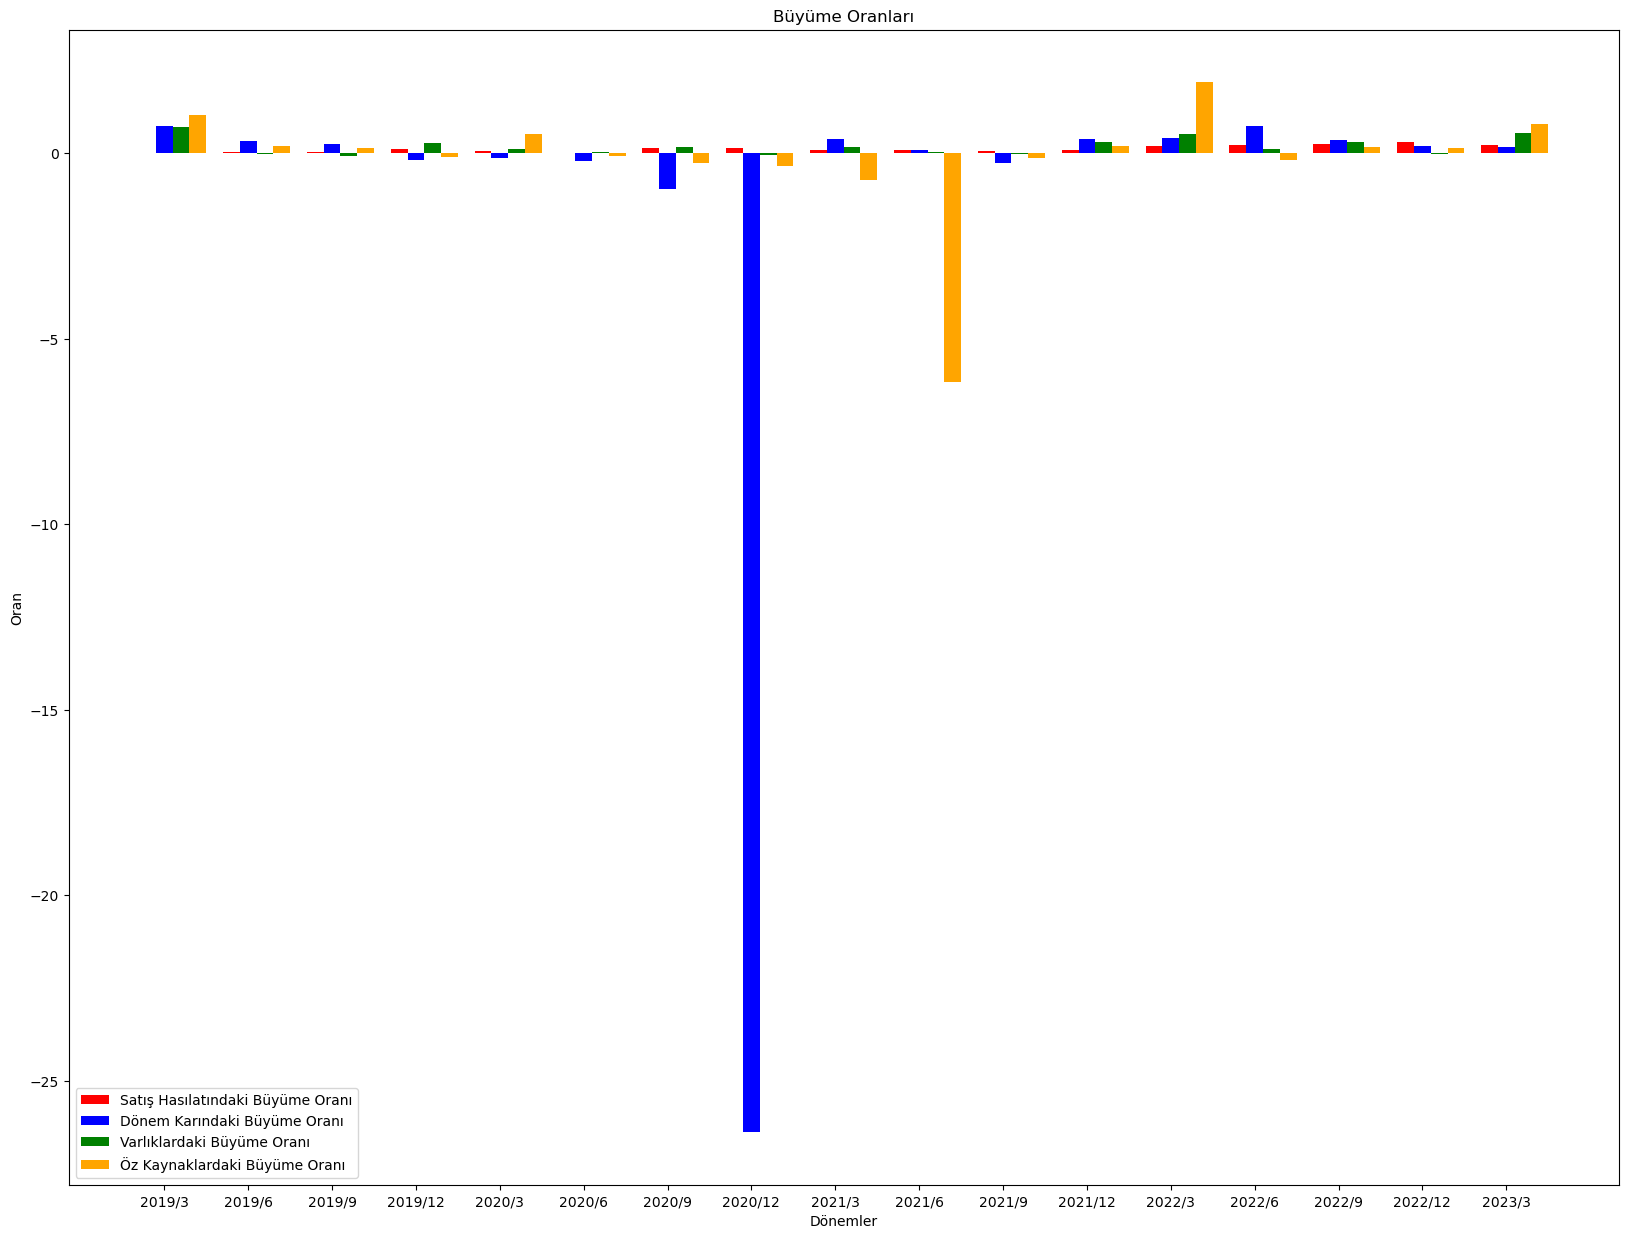

In [63]:
fig = plt.subplots(figsize =(20, 15))
barWidth=0.2
br1 = np.arange(len(buyume.columns[1:]))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
plt.bar(br1,buyume.loc["Satış Hasılatındaki Büyüme Oranı"][1:],label="Satış Hasılatındaki Büyüme Oranı",color="Red",width = barWidth)
plt.bar(br2,buyume.loc["Dönem Karındaki Büyüme Oranı"][1:], label="Dönem Karındaki Büyüme Oranı",color="Blue",width=barWidth)
plt.bar(br3,buyume.loc["Varlıklardaki Büyüme Oranı"][1:],label="Varlıklardaki Büyüme Oranı",color="Green",width=barWidth)
plt.bar(br4,buyume.loc["Öz Kaynaklardaki Büyüme Oranı"][1:],label="Öz Kaynaklardaki Büyüme Oranı",color="Orange",width=barWidth)
plt.title("Büyüme Oranları")
plt.xlabel("Dönemler")
plt.ylabel("Oran")
plt.xticks([r + barWidth for r in range(len(buyume.columns[1:]))],buyume.columns[1:])
plt.legend()
plt.show()

## Finansal Performansın Ölçülmesi

In [64]:
finansal_performans=yillik_veriler2.loc[["Kısa Vadeli Yükümlülükler","Uzun Vadeli Yükümlülükler","TOPLAM KAYNAKLAR"],:]
finansal_performans.loc["Özkaynak Karlılık Oranı"]=karlılık.loc["Öz Kaynakların Karlılık Oranı",:]
finansal_performans.loc["Finansal Kaldıraç Oranı"]=round((finansal_performans.loc["Kısa Vadeli Yükümlülükler",:]+finansal_performans.loc["Uzun Vadeli Yükümlülükler",:])/finansal_performans.loc["TOPLAM KAYNAKLAR",:],2)
finansal_performans

,2018/12,2019/3,2019/6,2019/9,2019/12,2020/3,2020/6,2020/9,2020/12,2021/3,2021/6,2021/9,2021/12,2022/3,2022/6,2022/9,2022/12,2023/3
Bilanço,,,,,,,,,,,,,,,,,,
Kısa Vadeli Yükümlülükler,"855,233,000.00","1,151,546,000.00","1,166,405,000.00","1,108,274,000.00","1,481,539,000.00","1,907,340,000.00","1,977,821,000.00","2,183,619,000.00","1,943,979,000.00","2,224,080,000.00","1,994,843,000.00","1,977,004,000.00","2,626,956,000.00","3,733,929,000.00","4,174,319,000.00","5,467,235,000.00","5,204,062,000.00","7,770,198,000.00"
Uzun Vadeli Yükümlülükler,"8,270,000.00","355,013,000.00","357,062,000.00","356,788,000.00","282,889,000.00","172,000,000.00","146,562,000.00","128,021,000.00","182,217,000.00","109,339,000.00","116,345,000.00","123,545,000.00","131,158,000.00","101,369,000.00","238,561,000.00","282,190,000.00","332,267,000.00","592,891,000.00"
TOPLAM KAYNAKLAR,"760,425,000.00","1,296,651,000.00","1,275,521,000.00","1,182,706,000.00","1,512,576,000.00","1,699,500,000.00","1,772,020,000.00","2,056,600,000.00","1,960,650,000.00","2,286,965,000.00","2,351,559,000.00","2,306,737,000.00","3,001,096,000.00","4,541,954,000.00","4,985,184,000.00","6,421,870,000.00","6,297,548,000.00","9,722,227,000.00"
Özkaynak Karlılık Oranı,-inf,-inf,-inf,-inf,0.84,0.43,0.34,0.01,-0.41,-0.56,-2.31,-3.93,3.40,0.57,0.80,1.00,1.05,0.59
Finansal Kaldıraç Oranı,1.14,1.16,1.19,1.24,1.17,1.22,1.20,1.12,1.08,1.02,0.90,0.91,0.92,0.84,0.89,0.90,0.88,0.86


In [65]:
dosya9=buyume.to_excel("C:/Users/okand/Desktop/Mali Tablolar Analizi/python_ciktilari/finansal_performans_oranlari.xlsx")

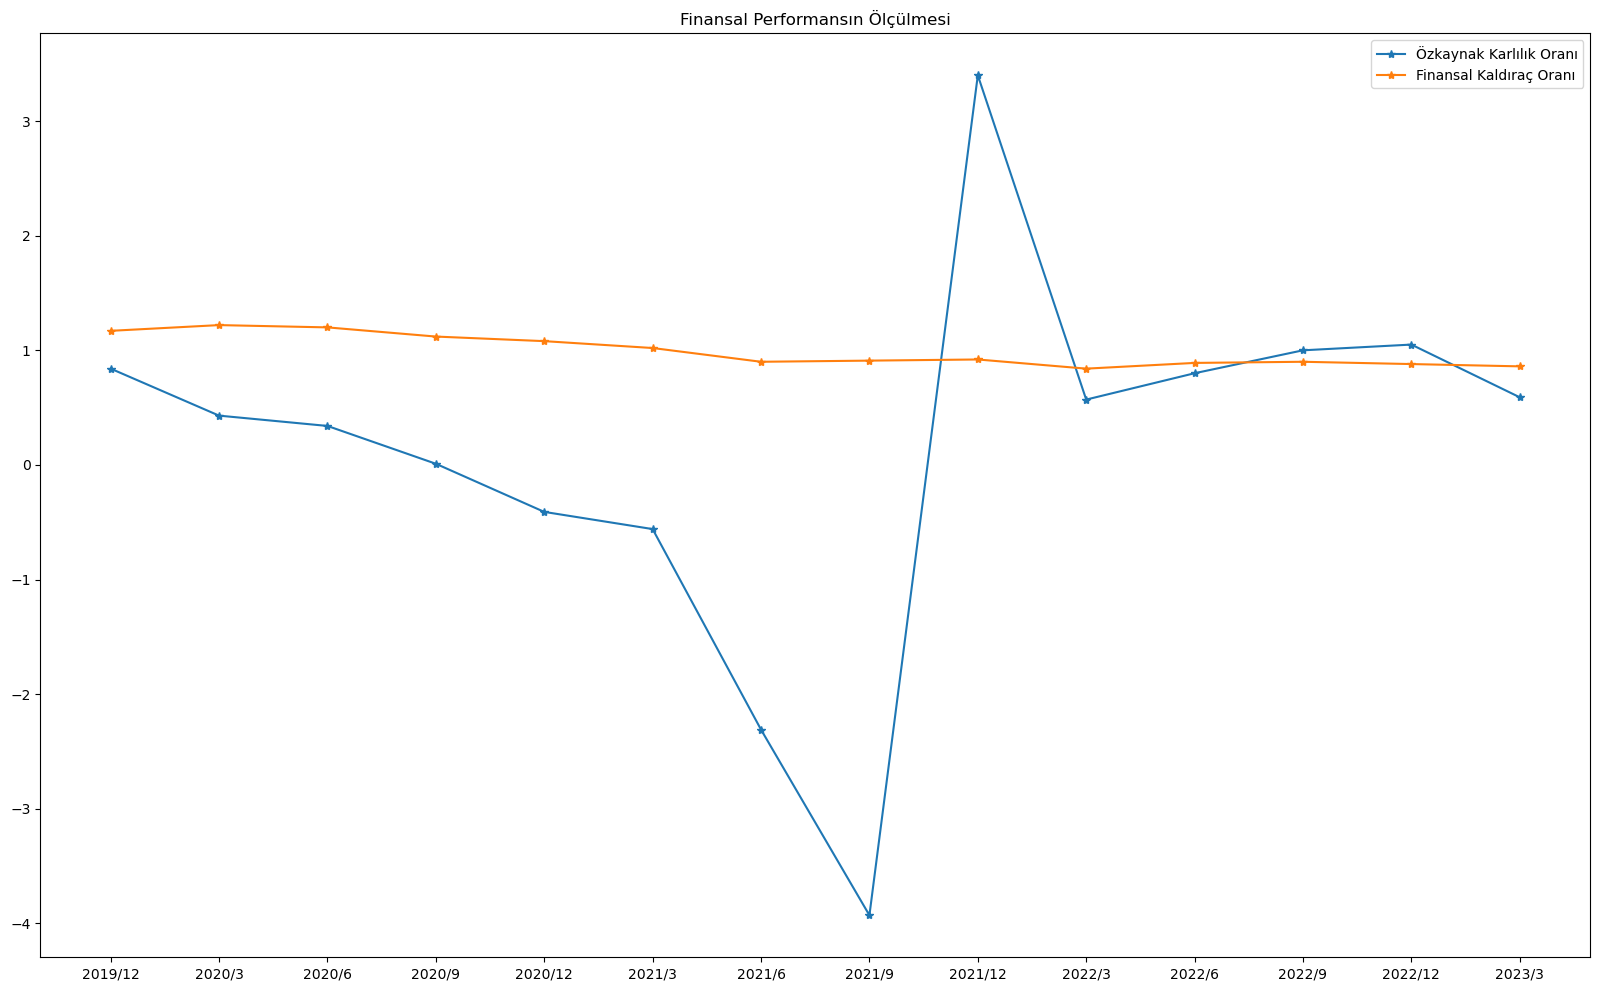

In [66]:
plt.figure(figsize=(20,12))
plt.plot(finansal_performans.columns[4:],finansal_performans.loc["Özkaynak Karlılık Oranı"][4:],label="Özkaynak Karlılık Oranı",marker="*")
plt.plot(finansal_performans.columns[4:],finansal_performans.loc["Finansal Kaldıraç Oranı"][4:],label="Finansal Kaldıraç Oranı",marker="*")
plt.title("Finansal Performansın Ölçülmesi")
plt.legend()
plt.show()

## Maliyet Etkinliği

In [67]:
maliyet_etkinligi=veri2.loc["Satış Gelirleri","2018/12":]
maliyet_etkinligi=pd.DataFrame(maliyet_etkinligi)
maliyet_etkinligi=maliyet_etkinligi.T
maliyet_etkinligi.loc["Satış Gelirleri (Yıllık)"]=yillik_veriler2.loc["Satış Gelirleri","2018/12":]
maliyet_etkinligi.loc["Pazarlama, Satış ve Dağıtım Giderleri"]=-yillik_veriler2.loc["Pazarlama, Satış ve Dağıtım Giderleri (-)","2018/12":]
maliyet_etkinligi.loc["Genel Yönetim Giderleri"]=-yillik_veriler2.loc["Genel Yönetim Giderleri (-)","2018/12":]
maliyet_etkinligi.loc["Araştırma ve Geliştirme Giderleri"]=-yillik_veriler2.loc["Araştırma ve Geliştirme Giderleri (-)","2018/12":]
maliyet_etkinligi.loc["Diğer Faaliyet Gelirleri"]=yillik_veriler2.loc["Diğer Faaliyet Gelirleri","2018/12":]
maliyet_etkinligi.loc["Diğer Faaliyet Giderleri"]=-yillik_veriler2.loc["Diğer Faaliyet Giderleri (-)","2018/12":]
maliyet_etkinligi.loc["Esas Faliyet Giderleri"]=maliyet_etkinligi.loc["Pazarlama, Satış ve Dağıtım Giderleri"]+maliyet_etkinligi.loc["Genel Yönetim Giderleri"]+maliyet_etkinligi.loc["Araştırma ve Geliştirme Giderleri"]
maliyet_etkinligi.loc["Satışların Maliyeti"]=-yillik_veriler2.loc["Satışların Maliyeti (-)","2018/12":]
maliyet_etkinligi.loc["Finansal Gelirler"]=veri2.loc["(Esas Faaliyet Dışı) Finansal Gelirler","2018/12":]
maliyet_etkinligi.loc["Finansal Giderler"]=veri2.loc["(Esas Faaliyet Dışı) Finansal Giderler (-)","2018/12":]
maliyet_etkinligi.loc["Net Finansman Gideri"]=maliyet_etkinligi.loc["Finansal Gelirler"]+maliyet_etkinligi.loc["Finansal Giderler"]
maliyet_etkinligi.loc["Satışların Maliyeti/Net Satışlar"]=round((maliyet_etkinligi.loc["Satışların Maliyeti"]/maliyet_etkinligi.loc["Satış Gelirleri (Yıllık)"])*100,2)
maliyet_etkinligi.loc["Net Finansman Gideri/Net Satışlar"]=round((-maliyet_etkinligi.loc["Net Finansman Gideri"]/maliyet_etkinligi.loc["Satış Gelirleri"])*100,2)
maliyet_etkinligi.loc["Esas Faaliyet Giderleri/Net Satışlar (Yıllık)"]=round((maliyet_etkinligi.loc["Esas Faliyet Giderleri"]/maliyet_etkinligi.loc["Satış Gelirleri (Yıllık)"])*100,2)
maliyet_etkinligi.loc["100 TL'lik Satıştan Elde Edilen Kar"]=100-(maliyet_etkinligi.loc["Satışların Maliyeti/Net Satışlar"]+maliyet_etkinligi.loc["Net Finansman Gideri/Net Satışlar"]+maliyet_etkinligi.loc["Esas Faaliyet Giderleri/Net Satışlar (Yıllık)"])
maliyet_etkinligi

,2018/12,2019/3,2019/6,2019/9,2019/12,2020/3,2020/6,2020/9,2020/12,2021/3,2021/6,2021/9,2021/12,2022/3,2022/6,2022/9,2022/12,2023/3
Satış Gelirleri,"3,477,020,000.00","840,682,000.00","1,842,761,000.00","2,879,903,000.00","4,136,971,000.00","1,048,401,000.00","2,003,518,000.00","3,674,296,000.00","5,606,519,000.00","1,461,262,000.00","2,983,252,000.00","4,951,132,000.00","7,520,079,000.00","2,843,083,000.00","6,249,184,000.00","10,788,538,000.00","17,440,964,000.00","6,621,574,000.00"
Satış Gelirleri (Yıllık),"3,477,020,000.00","3,511,191,000.00","3,622,350,000.00","3,739,810,000.00","4,136,971,000.00","4,344,690,000.00","4,297,728,000.00","4,931,364,000.00","5,606,519,000.00","6,019,380,000.00","6,586,253,000.00","6,883,355,000.00","7,520,079,000.00","8,901,900,000.00","10,786,011,000.00","13,357,485,000.00","17,440,964,000.00","21,219,455,000.00"
"Pazarlama, Satış ve Dağıtım Giderleri","466,990,000.00","474,334,000.00","476,395,000.00","481,230,000.00","482,266,000.00","494,740,000.00","472,328,000.00","483,526,000.00","512,128,000.00","522,083,000.00","559,552,000.00","591,196,000.00","642,973,000.00","781,220,000.00","940,026,000.00","1,165,974,000.00","1,470,415,000.00","1,769,901,000.00"
Genel Yönetim Giderleri,"56,126,000.00","56,800,000.00","59,711,000.00","60,761,000.00","57,110,000.00","58,001,000.00","56,887,000.00","62,347,000.00","66,910,000.00","67,700,000.00","73,053,000.00","74,869,000.00","85,113,000.00","104,960,000.00","126,067,000.00","155,676,000.00","203,107,000.00","233,318,000.00"
Araştırma ve Geliştirme Giderleri,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Diğer Faaliyet Gelirleri,"71,884,000.00","76,034,000.00","68,321,000.00","43,764,000.00","39,286,000.00","36,952,000.00","57,972,000.00","63,076,000.00","72,470,000.00","78,547,000.00","66,709,000.00","66,010,000.00","85,494,000.00","97,700,000.00","120,554,000.00","141,147,000.00","160,561,000.00","190,625,000.00"
Diğer Faaliyet Giderleri,"144,736,000.00","170,123,000.00","198,436,000.00","188,483,000.00","172,928,000.00","154,556,000.00","117,734,000.00","107,356,000.00","114,337,000.00","139,973,000.00","168,636,000.00","188,787,000.00","256,546,000.00","279,427,000.00","329,696,000.00","391,713,000.00","436,198,000.00","515,875,000.00"
Esas Faliyet Giderleri,"523,116,000.00","531,134,000.00","536,106,000.00","541,991,000.00","539,376,000.00","552,741,000.00","529,215,000.00","545,873,000.00","579,038,000.00","589,783,000.00","632,605,000.00","666,065,000.00","728,086,000.00","886,180,000.00","1,066,093,000.00","1,321,650,000.00","1,673,522,000.00","2,003,219,000.00"
Satışların Maliyeti,"2,831,234,000.00","2,868,753,000.00","2,953,831,000.00","3,066,106,000.00","3,422,374,000.00","3,598,121,000.00","3,605,792,000.00","4,129,145,000.00","4,675,836,000.00","5,010,960,000.00","5,468,179,000.00","5,730,134,000.00","6,253,253,000.00","7,389,673,000.00","8,898,777,000.00","11,022,346,000.00","14,536,722,000.00","17,750,070,000.00"
Finansal Gelirler,0.00,0.00,0.00,"685,000.00","761,000.00","31,000.00","1,262,000.00","5,245,000.00","6,881,000.00","336,000.00","2,066,000.00","2,231,000.00","18,126,000.00","13,479,000.00","31,356,000.00","62,121,000.00","68,608,000.00","3,085,000.00"


In [68]:
dosya10=maliyet_etkinligi.to_excel("C:/Users/okand/Desktop/Mali Tablolar Analizi/python_ciktilari/maliyet_etkinligi.xlsx")

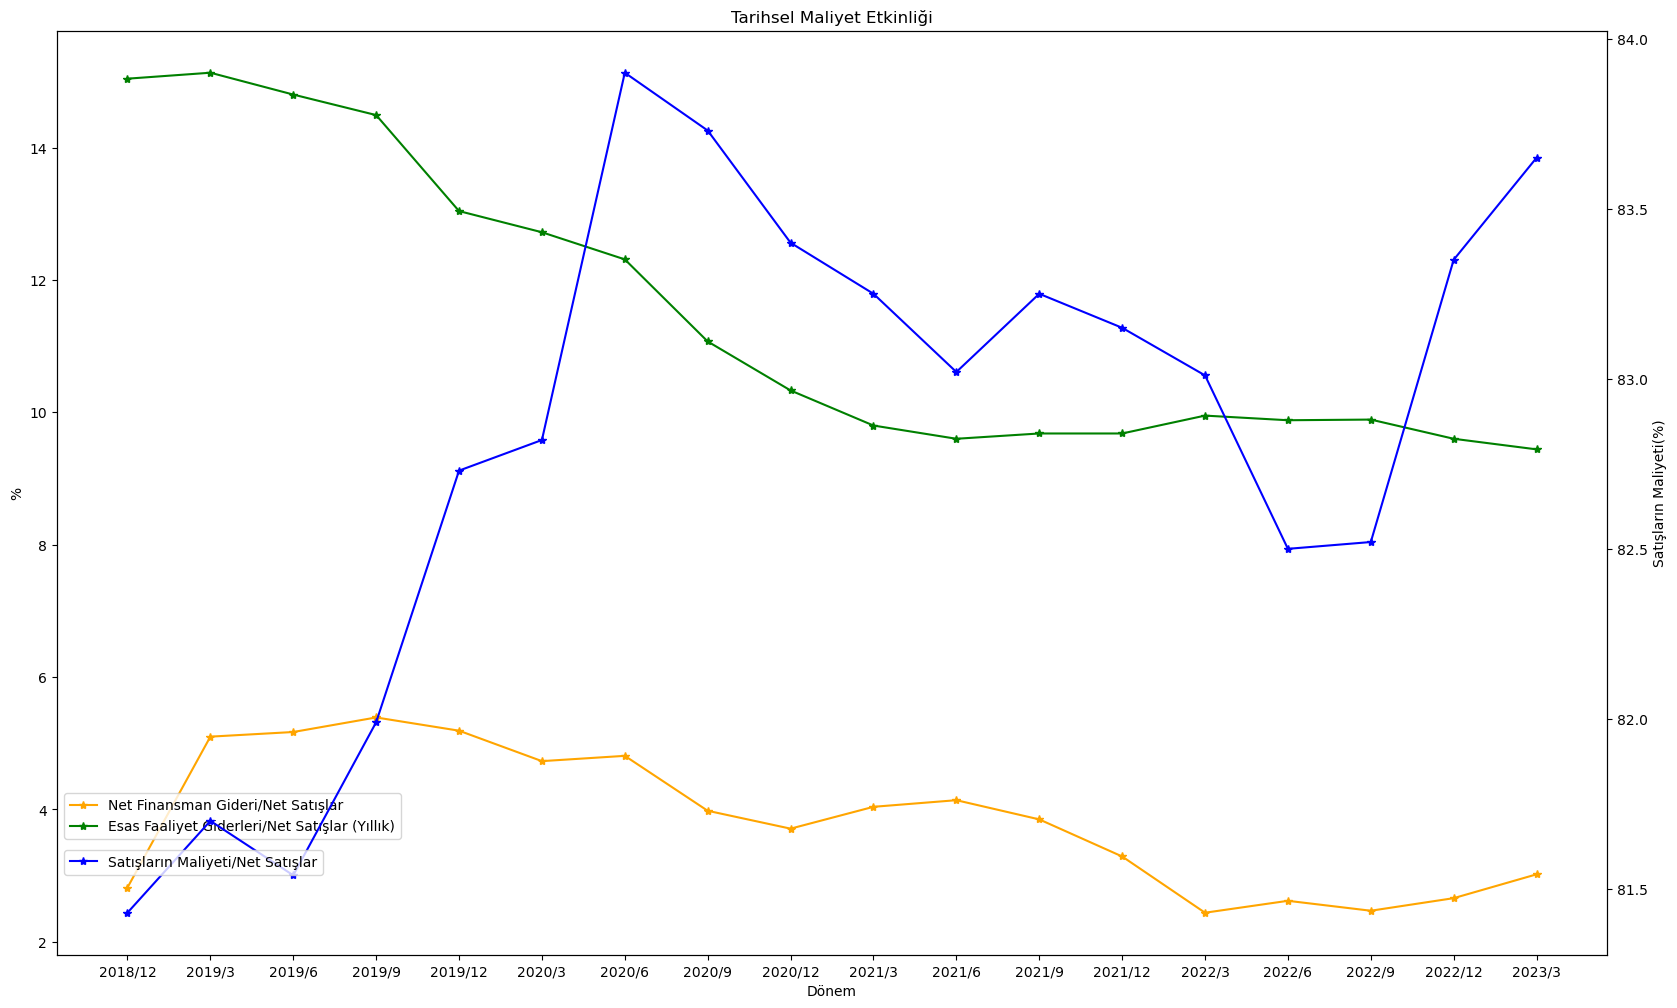

In [69]:
fig, ax1=plt.subplots(figsize=(20,12))
ax1.plot(maliyet_etkinligi.columns,maliyet_etkinligi.loc["Net Finansman Gideri/Net Satışlar"],color="orange",label="Net Finansman Gideri/Net Satışlar",marker="*")
ax1.plot(maliyet_etkinligi.columns,maliyet_etkinligi.loc["Esas Faaliyet Giderleri/Net Satışlar (Yıllık)"],color="green",label="Esas Faaliyet Giderleri/Net Satışlar (Yıllık)",marker="*")
ax2 = ax1.twinx()
ax2.plot(maliyet_etkinligi.columns,maliyet_etkinligi.loc["Satışların Maliyeti/Net Satışlar"],color="blue",label="Satışların Maliyeti/Net Satışlar",marker="*")
ax1.set_title("Tarihsel Maliyet Etkinliği")
ax1.set_xlabel("Dönem")
ax1.set_ylabel("%")
ax2.set_ylabel("Satışların Maliyeti(%)")
ax1.legend(loc='center left', bbox_to_anchor=(0, 0.15))
ax2.legend(loc='center left', bbox_to_anchor=(0, 0.10))
plt.show()

## Dupond Analizi

In [70]:
dupond=yillik_veriler2.loc["Satış Gelirleri"]
dupond=pd.DataFrame(dupond)
dupond=dupond.T
dupond.loc["Dönem Karı"]=yillik_veriler2.loc["DÖNEM KARI (ZARARI)"]
dupond.loc["Varlıklar"]=yillik_veriler2.loc["TOPLAM VARLIKLAR"]
dupond.loc["Özkaynaklar"]=yillik_veriler2.loc["Özkaynaklar"]
dupond.loc["Dönem Kar Marjları"]=dupond.loc["Dönem Karı"]/dupond.loc["Satış Gelirleri"]
dupond.loc["Varlıkların Devir Hızları"]=dupond.loc["Satış Gelirleri"]/dupond.loc["Varlıklar"]
dupond.loc["Öz Kaynaklar Çarpanı"]=dupond.loc["Varlıklar"]/dupond.loc["Özkaynaklar"]
dupond.loc["Varlıkların Karlılık Oranları"]=dupond.loc["Dönem Kar Marjları"]*dupond.loc["Varlıkların Devir Hızları"]
dupond.loc["Öz Kaynakların Karlılık Oranları"]=dupond.loc["Dönem Kar Marjları"]*dupond.loc["Varlıkların Devir Hızları"]*dupond.loc["Öz Kaynaklar Çarpanı"]

kar_marjları=[]
varlık_devir_hızı=[]
ozkaynak_carpani=[]
varlik_karlilik=[]
ozkaynak_karlilik=[]

for i in range(4):
    kar_marjları.append(0)
    varlık_devir_hızı.append(0)
    ozkaynak_carpani.append(0)
    varlik_karlilik.append(0)
    ozkaynak_karlilik.append(0)

for i in range(len(dupond.columns[4:])):
    kar_marjları.append(round((dupond.loc["Dönem Kar Marjları"][i+4]/dupond.loc["Dönem Kar Marjları"][i])-1,2))
    varlık_devir_hızı.append(round((dupond.loc["Varlıkların Devir Hızları"][i+4]/dupond.loc["Varlıkların Devir Hızları"][i])-1,2))
    ozkaynak_carpani.append(round((dupond.loc["Öz Kaynaklar Çarpanı"][i+4]/dupond.loc["Öz Kaynaklar Çarpanı"][i])-1,2))
    varlik_karlilik.append(round((dupond.loc["Varlıkların Karlılık Oranları"][i+4]/dupond.loc["Varlıkların Karlılık Oranları"][i])-1,2))
    ozkaynak_karlilik.append(round((dupond.loc["Öz Kaynakların Karlılık Oranları"][i+4]/dupond.loc["Öz Kaynakların Karlılık Oranları"][i])-1,2))

dupond.loc["Dönem Kar Marjları (%)"]=kar_marjları
dupond.loc["Varlıkların Devir Hızları (%)"]=varlık_devir_hızı
dupond.loc["Öz Kaynaklar Çarpanı (%)"]=ozkaynak_carpani
dupond.loc["Varlıkların Karlılık Oranları (%)"]=varlik_karlilik
dupond.loc["Öz Kaynakların Karlılık Oranları (%)"]=ozkaynak_karlilik

dupond

,2018/12,2019/3,2019/6,2019/9,2019/12,2020/3,2020/6,2020/9,2020/12,2021/3,2021/6,2021/9,2021/12,2022/3,2022/6,2022/9,2022/12,2023/3
Satış Gelirleri,"3,477,020,000.00","3,511,191,000.00","3,622,350,000.00","3,739,810,000.00","4,136,971,000.00","4,344,690,000.00","4,297,728,000.00","4,931,364,000.00","5,606,519,000.00","6,019,380,000.00","6,586,253,000.00","6,883,355,000.00","7,520,079,000.00","8,901,900,000.00","10,786,011,000.00","13,357,485,000.00","17,440,964,000.00","21,219,455,000.00"
Dönem Karı,"-64,609,000.00","-112,499,000.00","-148,667,000.00","-183,940,000.00","-148,634,000.00","-127,304,000.00","-101,171,000.00","-3,359,000.00","85,296,000.00","118,556,000.00","129,207,000.00","96,076,000.00","131,464,000.00","187,138,000.00","326,078,000.00","437,187,000.00","524,927,000.00","608,884,000.00"
Varlıklar,"760,425,000.00","1,296,651,000.00","1,275,521,000.00","1,182,706,000.00","1,512,576,000.00","1,699,500,000.00","1,772,020,000.00","2,056,600,000.00","1,960,650,000.00","2,286,965,000.00","2,351,559,000.00","2,306,737,000.00","3,001,096,000.00","4,541,954,000.00","4,985,184,000.00","6,421,870,000.00","6,297,548,000.00","9,722,227,000.00"
Özkaynaklar,"-103,078,000.00","-209,908,000.00","-247,946,000.00","-282,356,000.00","-251,852,000.00","-379,840,000.00","-352,363,000.00","-255,040,000.00","-165,546,000.00","-46,454,000.00","240,371,000.00","206,188,000.00","242,982,000.00","706,656,000.00","572,304,000.00","672,445,000.00","761,219,000.00","1,359,138,000.00"
Dönem Kar Marjları,-0.02,-0.03,-0.04,-0.05,-0.04,-0.03,-0.02,-0.00,0.02,0.02,0.02,0.01,0.02,0.02,0.03,0.03,0.03,0.03
Varlıkların Devir Hızları,4.57,2.71,2.84,3.16,2.74,2.56,2.43,2.40,2.86,2.63,2.80,2.98,2.51,1.96,2.16,2.08,2.77,2.18
Öz Kaynaklar Çarpanı,-7.38,-6.18,-5.14,-4.19,-6.01,-4.47,-5.03,-8.06,-11.84,-49.23,9.78,11.19,12.35,6.43,8.71,9.55,8.27,7.15
Varlıkların Karlılık Oranları,-0.08,-0.09,-0.12,-0.16,-0.10,-0.07,-0.06,-0.00,0.04,0.05,0.05,0.04,0.04,0.04,0.07,0.07,0.08,0.06
Öz Kaynakların Karlılık Oranları,0.63,0.54,0.60,0.65,0.59,0.34,0.29,0.01,-0.52,-2.55,0.54,0.47,0.54,0.26,0.57,0.65,0.69,0.45
Dönem Kar Marjları (%),0.00,0.00,0.00,0.00,0.93,-0.09,-0.43,-0.99,-1.42,-1.67,-1.83,-21.49,0.15,0.07,0.54,1.34,0.72,0.36


In [71]:
dosya11=dupond.to_excel("C:/Users/okand/Desktop/Mali Tablolar Analizi/python_ciktilari/dupond_analizi.xlsx")

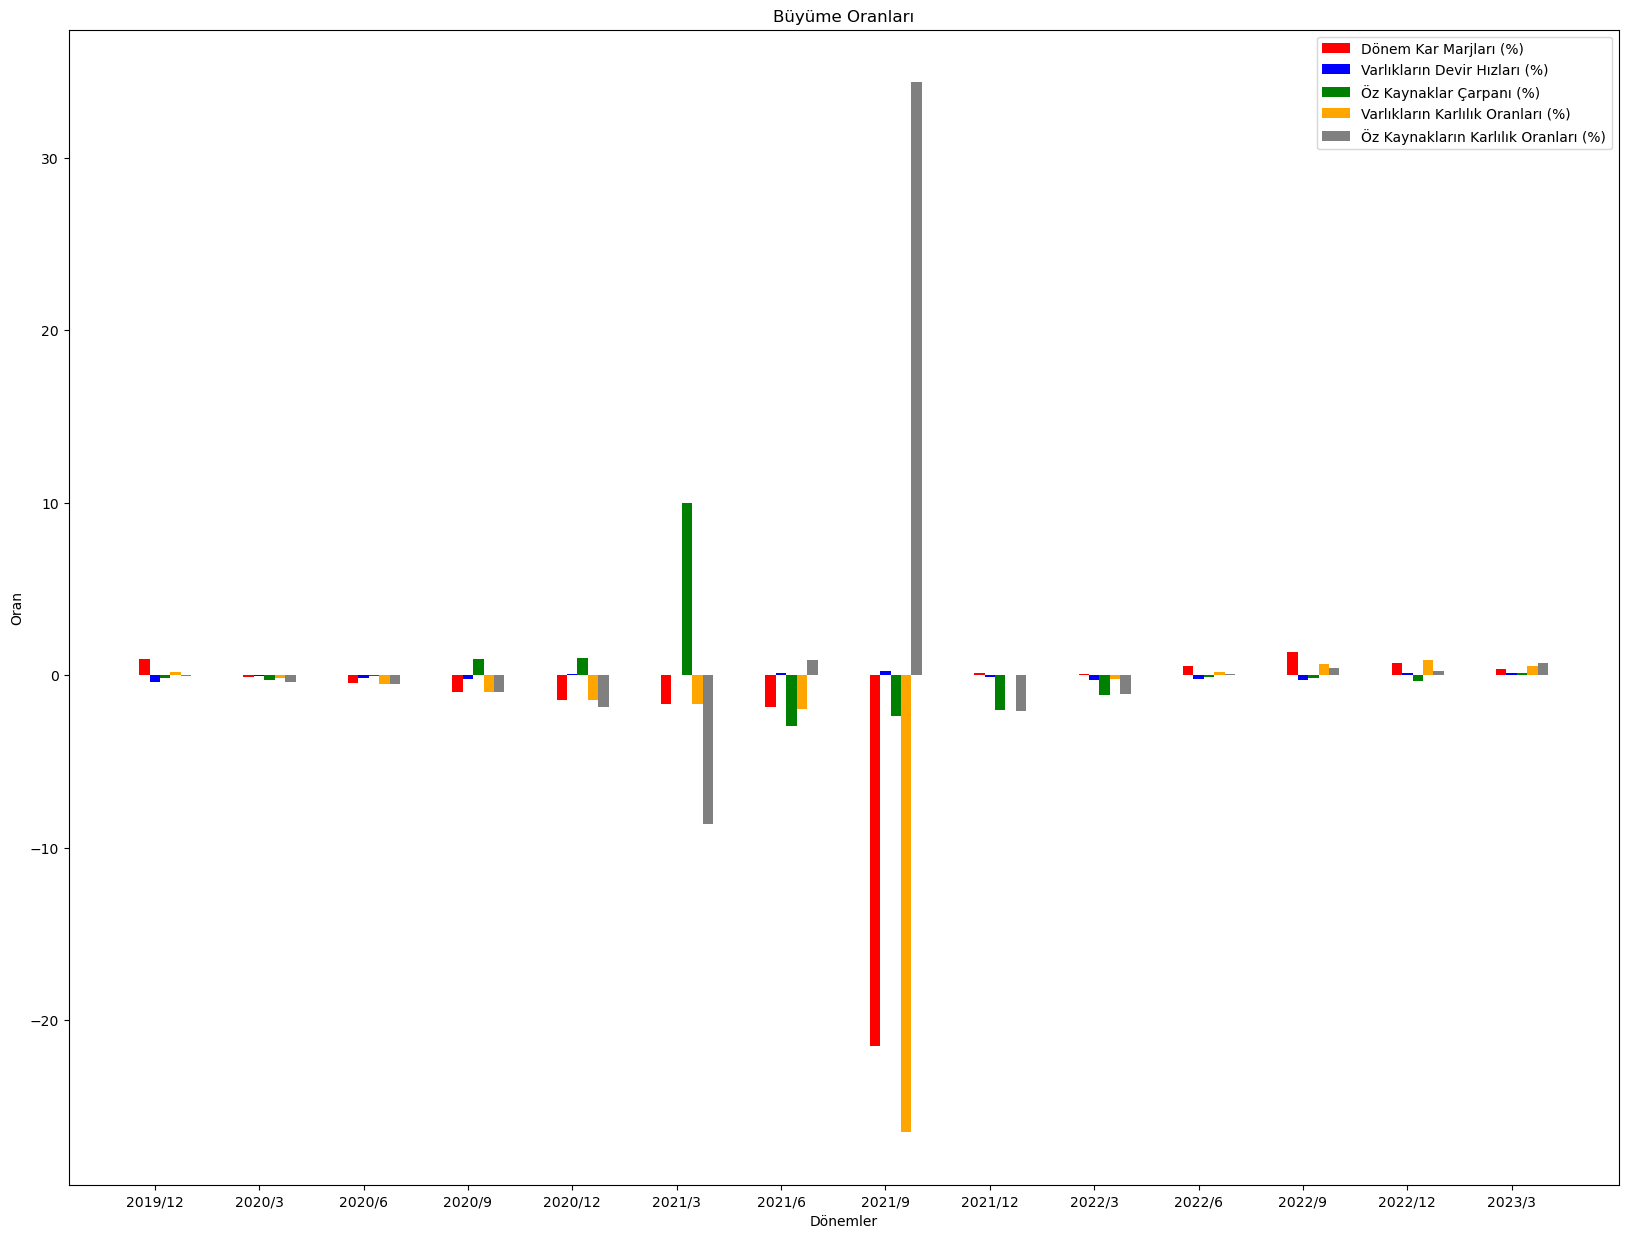

In [72]:
fig = plt.subplots(figsize =(20, 15))
barWidth=0.1
br1 = np.arange(len(dupond.columns[4:]))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
plt.bar(br1,dupond.loc["Dönem Kar Marjları (%)"][4:],label="Dönem Kar Marjları (%)",color="Red",width = barWidth)
plt.bar(br2,dupond.loc["Varlıkların Devir Hızları (%)"][4:], label="Varlıkların Devir Hızları (%)",color="Blue",width=barWidth)
plt.bar(br3,dupond.loc["Öz Kaynaklar Çarpanı (%)"][4:],label="Öz Kaynaklar Çarpanı (%)",color="Green",width=barWidth)
plt.bar(br4,dupond.loc["Varlıkların Karlılık Oranları (%)"][4:],label="Varlıkların Karlılık Oranları (%)",color="Orange",width=barWidth)
plt.bar(br5,dupond.loc["Öz Kaynakların Karlılık Oranları (%)"][4:],label="Öz Kaynakların Karlılık Oranları (%)",color="Gray",width=barWidth)
plt.title("Büyüme Oranları")
plt.xlabel("Dönemler")
plt.ylabel("Oran")
plt.xticks([r + barWidth for r in range(len(dupond.columns[4:]))],dupond.columns[4:])
plt.legend()
plt.show()

Öz kaynakların karlılık oranı Dupont analizinde yukarıdaki gibi üç kısma ayrılmasının sebebi, firmada öz kaynakların karlılığını etkileyen unsurları görmektir.
Finansal yönetici öz kaynak karlılığını artırabilmek için, yukarıda verilen 3 oran üzerinde çalışmalıdır.
* Örneğin aynı satış düzeyinde dönem karını arttırabilmek için, satışların maliyetini oluşturan hammadde, işçilik ve genel giderlerin azaltılmasının yanında faliyet giderlerini oluşturan genel yönetim, pazarlama ve ar-ge giderlerinin de azaltılması gerekir. 
* Varlıkların devir hızının arttırılabilmesi için, dönen ve duran varlık yatırımları gözden geçirilmeli, bu yatırımlar her bir hesap kalemi bazında optimal düzeyde olmalı, fazla (atıl) yatırım olmamalı, fazla yatırım varsa bu yatırım optimum düzeye çekilmelidir.
* Öz kaynak karlılığının artırılabilmesi için finansal yapının da optimum düzeyde oluşturulması gerekir. Optimal finansal yapı finansal kaldıraç etkisi sayesinde sermaye maliyetinin azalması ve karlılığın artmasını sağlar.

İşletmelerin nihai hedefi öz kaynak karlılığını arttırmak olduğu için burada öz kaynak karlılığına odaklanırsak; YUNSA'da öz kaynakların karlılığının büyüme oranı 2022'de 2021'e göre artış göstermiştir. 
* Öz kaynak karlılığının üç unsuru olan dönem kar marjı, varlıkların devir hızı ve öz kaynaklar çarpanına baktığımızda:
2021 yılında dönem kar marjı %130 artmış, varlıkların devir hızı %5 düşmüş ve öz kaynak çarpanı %19 artmıştır. 2022 yılında ise dönem kar marjında %253 artış, varlık devir hızında %57 artış ve öz kaynak çarpanında %34 azalış gerçekleşmiştir.

2021 yılında gerçekleşen %160 lık öz kaynak karlılığı artışına en büyük etkiyi dönem kar marjı göstermiştir. Bu dönemde maliyetler daha iyi yönetilerek dönem kar marjı arttırılmış.

2022 yılında gerçekleşen %263 lık öz kaynak karlılığı artışına en büyük etkiyi dönem kar marjı göstermiştir. Bu dönemde maliyetler daha iyi yönetilerek dönem kar marjı arttırılmış.

## Nakit Akış Analizi

In [73]:
nakit_akisi=yillik_veriler2.loc[" Esas Faaliyet ile İlgili Oluşan Nakit (+)"]
nakit_akisi=pd.DataFrame(nakit_akisi)
nakit_akisi=nakit_akisi.T
nakit_akisi.loc[" Yatırım Faaliyetlerinden Kaynaklanan Nakit"]=yillik_veriler2.loc[" Yatırım Faaliyetlerinden Kaynaklanan Nakit"]
nakit_akisi.loc["Finansman Faaliyetlerden Kaynaklanan Nakit"]=yillik_veriler2.loc["Finansman Faaliyetlerden Kaynaklanan Nakit"]
nakit_akisi.loc["Nakit ve Benzerlerindeki Değişim"]=yillik_veriler2.loc["Nakit ve Benzerlerindeki Değişim"]
nakit_akisi.loc["Dönem Başı Nakit Değerler"]=yillik_veriler2.loc["Dönem Başı Nakit Değerler"]
nakit_akisi.loc["Dönem Sonu Nakit"]=yillik_veriler2.loc["Dönem Sonu Nakit"]
nakit_akisi

,2018/12,2019/3,2019/6,2019/9,2019/12,2020/3,2020/6,2020/9,2020/12,2021/3,2021/6,2021/9,2021/12,2022/3,2022/6,2022/9,2022/12,2023/3
Esas Faaliyet ile İlgili Oluşan Nakit (+),87956000,388550000,359934000,281402000,239526000,22164000,319689000,257727000,367470000,290552000,-13336000,347085000,819687000,828801000,982958000,1219022000,1522127000,1372419000
Yatırım Faaliyetlerinden Kaynaklanan Nakit,-36884000,-34914000,-35958000,-38286000,-35446000,-38664000,-32679000,-29688000,-25378000,-23089000,-30784000,-38162000,-56026000,-59024000,-71231000,-88762000,-137468000,-158590000
Finansman Faaliyetlerden Kaynaklanan Nakit,-89588000,-306871000,-284958000,-244421000,-181192000,32602000,-6229000,15481000,11226000,-285091000,-212414000,-444163000,-447418000,-260899000,-479060000,-441002000,-463073000,-767612000
Nakit ve Benzerlerindeki Değişim,-45716000,21687000,25148000,-16078000,10280000,5971000,275131000,242120000,354934000,-18402000,-260011000,-145994000,317207000,522683000,455784000,716045000,894771000,405351000
Dönem Başı Nakit Değerler,72703000,26987000,26987000,26987000,26987000,37267000,37267000,37267000,37267000,392201000,392201000,392201000,392201000,709408000,709408000,709408000,709408000,1604179000
Dönem Sonu Nakit,26987000,48674000,52135000,10909000,37267000,43238000,312398000,279387000,392201000,373799000,132190000,246207000,709408000,1232091000,1165192000,1425453000,1604179000,2009530000


In [74]:
finansal_durum=yillik_veriler2.loc["Dönen Varlıklar"]
finansal_durum=pd.DataFrame(finansal_durum)
finansal_durum=finansal_durum.T
finansal_durum.loc["Dönen Varlıklar"]=yillik_veriler2.loc["Dönen Varlıklar"]
finansal_durum.loc["Duran Varlıklar"]=yillik_veriler2.loc["Duran Varlıklar"]
finansal_durum.loc["TOPLAM VARLIKLAR"]=yillik_veriler2.loc["TOPLAM VARLIKLAR"]
finansal_durum.loc["Kısa Vadeli Yükümlülükler"]=yillik_veriler2.loc["Kısa Vadeli Yükümlülükler"]
finansal_durum.loc["Uzun Vadeli Yükümlülükler"]=yillik_veriler2.loc["Uzun Vadeli Yükümlülükler"]
finansal_durum.loc["Özkaynaklar"]=yillik_veriler2.loc["Özkaynaklar"]
finansal_durum.loc["TOPLAM KAYNAKLAR"]=yillik_veriler2.loc["TOPLAM KAYNAKLAR"]
finansal_durum.loc["  Ödenmiş Sermaye"]=yillik_veriler2.loc["  Ödenmiş Sermaye"]
finansal_durum.loc["Temettü Ödemeleri"]=-yillik_veriler2.loc["Temettü Ödemeleri"]
finansal_durum

,2018/12,2019/3,2019/6,2019/9,2019/12,2020/3,2020/6,2020/9,2020/12,2021/3,2021/6,2021/9,2021/12,2022/3,2022/6,2022/9,2022/12,2023/3
Dönen Varlıklar,592569000,737901000,729962000,655174000,994466000,1268078000,1355165000,1648520000,1565441000,1976696000,2023694000,1973804000,2623534000,4184523000,4421936000,5739685000,5438562000,8229945000
Duran Varlıklar,167856000,558750000,545559000,527532000,518110000,431422000,416855000,408080000,395209000,310269000,327865000,332933000,377562000,357431000,563248000,682185000,858986000,1492282000
TOPLAM VARLIKLAR,760425000,1296651000,1275521000,1182706000,1512576000,1699500000,1772020000,2056600000,1960650000,2286965000,2351559000,2306737000,3001096000,4541954000,4985184000,6421870000,6297548000,9722227000
Kısa Vadeli Yükümlülükler,855233000,1151546000,1166405000,1108274000,1481539000,1907340000,1977821000,2183619000,1943979000,2224080000,1994843000,1977004000,2626956000,3733929000,4174319000,5467235000,5204062000,7770198000
Uzun Vadeli Yükümlülükler,8270000,355013000,357062000,356788000,282889000,172000000,146562000,128021000,182217000,109339000,116345000,123545000,131158000,101369000,238561000,282190000,332267000,592891000
Özkaynaklar,-103078000,-209908000,-247946000,-282356000,-251852000,-379840000,-352363000,-255040000,-165546000,-46454000,240371000,206188000,242982000,706656000,572304000,672445000,761219000,1359138000
TOPLAM KAYNAKLAR,760425000,1296651000,1275521000,1182706000,1512576000,1699500000,1772020000,2056600000,1960650000,2286965000,2351559000,2306737000,3001096000,4541954000,4985184000,6421870000,6297548000,9722227000
Ödenmiş Sermaye,110000000,110000000,110000000,110000000,110000000,110000000,110000000,110000000,110000000,110000000,201000000,201000000,201000000,292000000,201000000,201000000,201000000,201000000
Temettü Ödemeleri,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [75]:
nakit_akis_oranlari=pd.DataFrame(columns=yillik_veriler2.columns)
nakit_akis_oranlari.loc["İşletme Faaliyetlerinden Nakit Akışları/KVYK"]=nakit_akisi.loc[" Esas Faaliyet ile İlgili Oluşan Nakit (+)"]/finansal_durum.loc["Kısa Vadeli Yükümlülükler"]
nakit_akis_oranlari.loc["İşletme Faaliyetlerinden Nakit Akışları/Toplam Borçlar"]=nakit_akisi.loc[" Esas Faaliyet ile İlgili Oluşan Nakit (+)"]/(finansal_durum.loc["Kısa Vadeli Yükümlülükler"]+finansal_durum.loc["Uzun Vadeli Yükümlülükler"])
nakit_akis_oranlari.loc["İşletme Faaliyetlerinden Nakit Akışları/Toplam Varlıklar"]=nakit_akisi.loc[" Esas Faaliyet ile İlgili Oluşan Nakit (+)"]/finansal_durum.loc["TOPLAM VARLIKLAR"]
nakit_akis_oranlari.loc["İşletme Faaliyetlerinden Nakit Akışları/Toplam Hisse senedi Sayısı"]=nakit_akisi.loc[" Esas Faaliyet ile İlgili Oluşan Nakit (+)"]/finansal_durum.loc["  Ödenmiş Sermaye"]
nakit_akis_oranlari.loc["İşletme Faaliyetlerinden Nakit Akışları/Ödenen Temettüler"]=nakit_akisi.loc[" Esas Faaliyet ile İlgili Oluşan Nakit (+)"]/finansal_durum.loc["Temettü Ödemeleri"]
nakit_akis_oranlari

,2018/12,2019/3,2019/6,2019/9,2019/12,2020/3,2020/6,2020/9,2020/12,2021/3,2021/6,2021/9,2021/12,2022/3,2022/6,2022/9,2022/12,2023/3
İşletme Faaliyetlerinden Nakit Akışları/KVYK,0.10,0.34,0.31,0.25,0.16,0.01,0.16,0.12,0.19,0.13,-0.01,0.18,0.31,0.22,0.24,0.22,0.29,0.18
İşletme Faaliyetlerinden Nakit Akışları/Toplam Borçlar,0.10,0.26,0.24,0.19,0.14,0.01,0.15,0.11,0.17,0.12,-0.01,0.17,0.30,0.22,0.22,0.21,0.27,0.16
İşletme Faaliyetlerinden Nakit Akışları/Toplam Varlıklar,0.12,0.30,0.28,0.24,0.16,0.01,0.18,0.13,0.19,0.13,-0.01,0.15,0.27,0.18,0.20,0.19,0.24,0.14
İşletme Faaliyetlerinden Nakit Akışları/Toplam Hisse senedi Sayısı,0.80,3.53,3.27,2.56,2.18,0.20,2.91,2.34,3.34,2.64,-0.07,1.73,4.08,2.84,4.89,6.06,7.57,6.83
İşletme Faaliyetlerinden Nakit Akışları/Ödenen Temettüler,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,-inf,inf,inf,inf,inf,inf,inf,inf


In [76]:
with pd.ExcelWriter("C:/Users/okand/Desktop/Mali Tablolar Analizi/python_ciktilari/nakit_akisi_analizi.xlsx") as writer:
    nakit_akisi.to_excel(writer,sheet_name="Nakit Akışı Tablosu",index=True)
    finansal_durum.to_excel(writer,sheet_name="Finansal Durum Tablosu",index=True)
    nakit_akis_oranlari.to_excel(writer,sheet_name="Nakit Akışı Oranları Tablosu",index=True)

FROTO 2022 yılında işletme faaliyetlerinden elde ettiği nakit ile kısa vadeli borçlarının %45'ini, toplam borçlarının %28'ini karşılamaktadır. 

İşletme faaliyetlerinden sağladığı nakit akışları 2022 de toplam varlıklarının %22'sine denk gelmektedir ve hisse başı işletme faaliyetinden sağlanan nakit akışı 59,15'dir. (bir yıllık faaliyetlerinden sağladığı nakit akışları ile hisse başına ödeyebileceği fon akışını gösterir.)

*FROTO'nun 1 yıllık faaliyetlerinden sağladığı nakit akışı ile 2022 yılında temettü ödeme kapasitesi 3,16'dır.

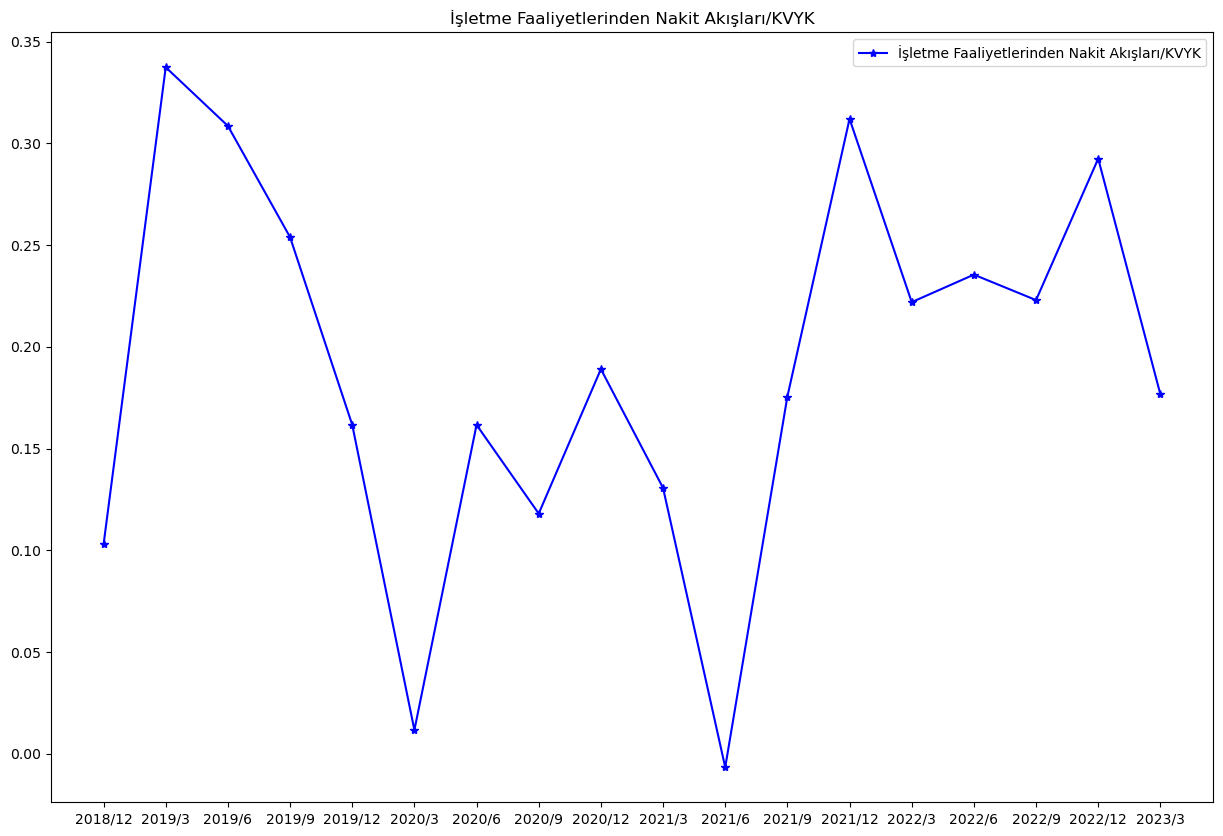

In [77]:
plt.figure(figsize=(15,10))
plt.plot(nakit_akis_oranlari.columns,nakit_akis_oranlari.loc["İşletme Faaliyetlerinden Nakit Akışları/KVYK"],color="Blue",label="İşletme Faaliyetlerinden Nakit Akışları/KVYK",marker="*")
plt.title("İşletme Faaliyetlerinden Nakit Akışları/KVYK")
plt.legend()
plt.show()

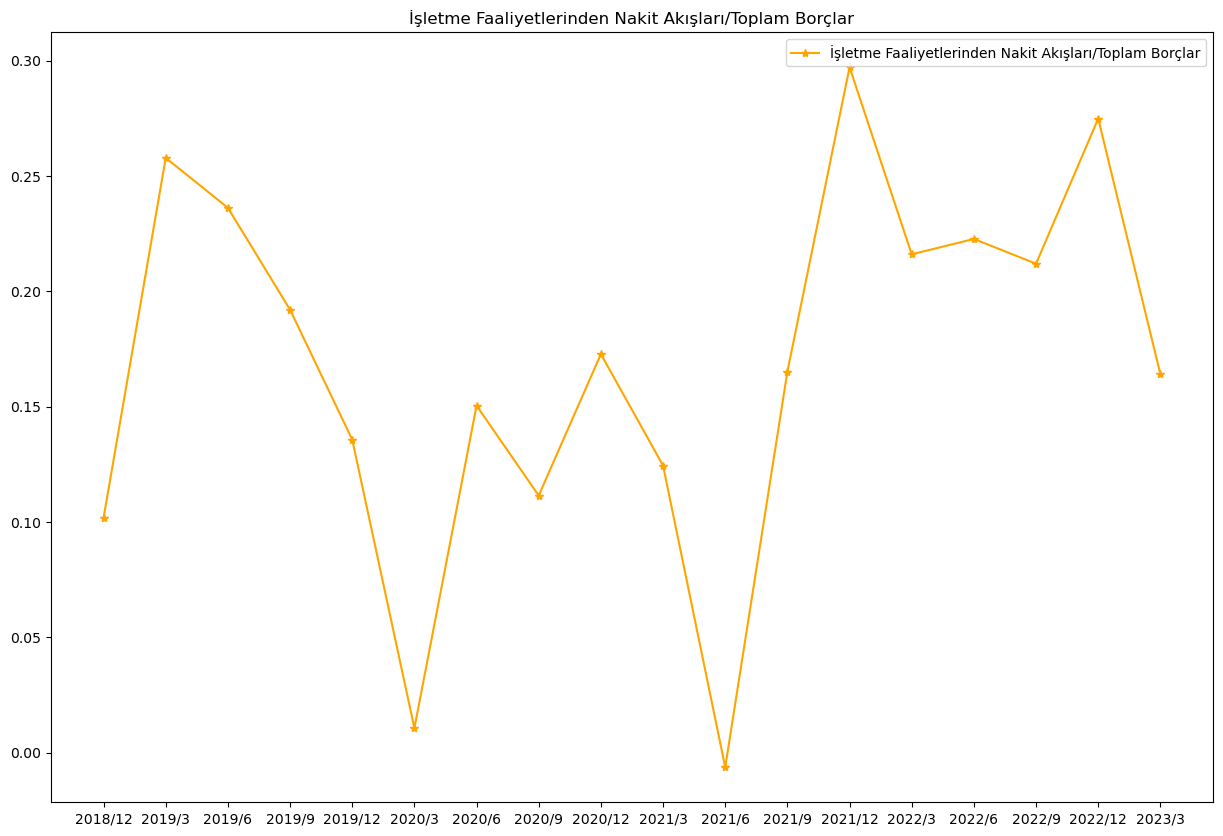

In [78]:
plt.figure(figsize=(15,10))
plt.plot(nakit_akis_oranlari.columns,nakit_akis_oranlari.loc["İşletme Faaliyetlerinden Nakit Akışları/Toplam Borçlar"],color="Orange",label="İşletme Faaliyetlerinden Nakit Akışları/Toplam Borçlar",marker="*")
plt.title("İşletme Faaliyetlerinden Nakit Akışları/Toplam Borçlar")
plt.legend()
plt.show()

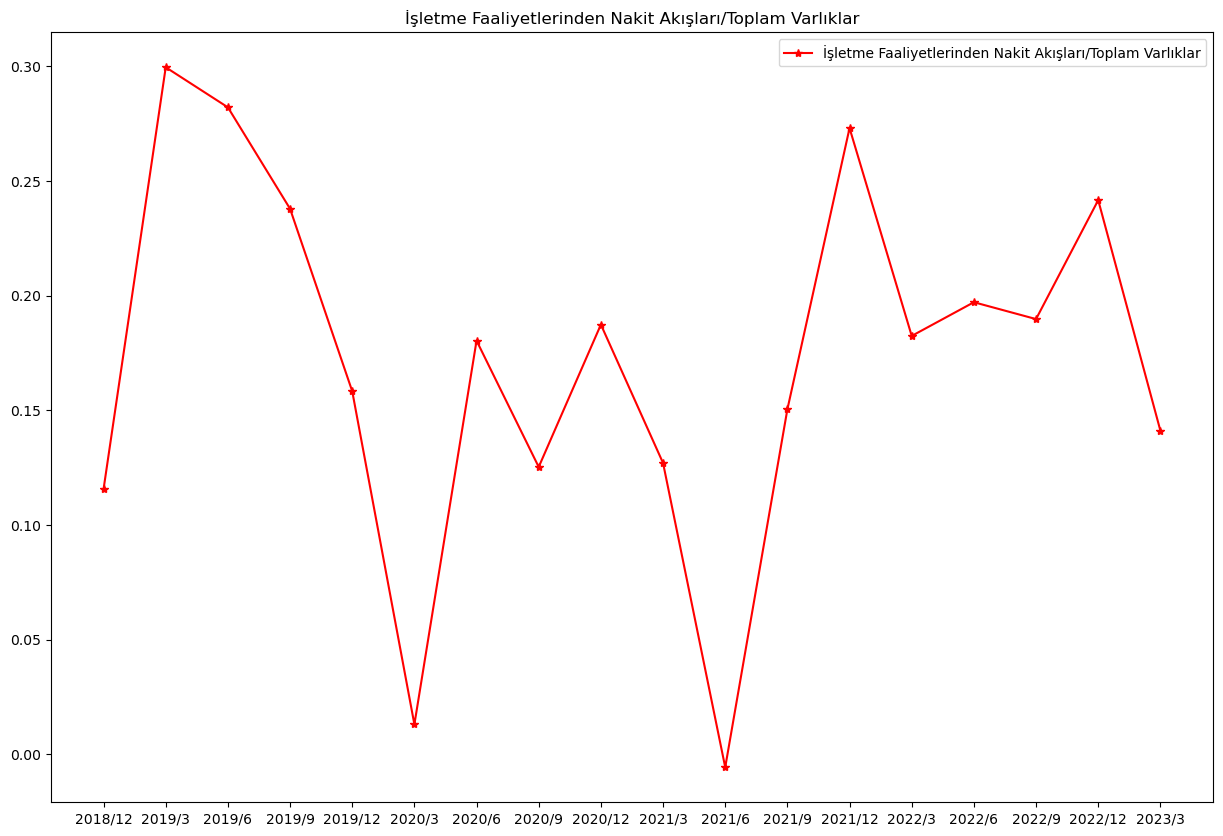

In [79]:
plt.figure(figsize=(15,10))
plt.plot(nakit_akis_oranlari.columns,nakit_akis_oranlari.loc["İşletme Faaliyetlerinden Nakit Akışları/Toplam Varlıklar"],color="Red",label="İşletme Faaliyetlerinden Nakit Akışları/Toplam Varlıklar",marker="*")
plt.title("İşletme Faaliyetlerinden Nakit Akışları/Toplam Varlıklar")
plt.legend()
plt.show()

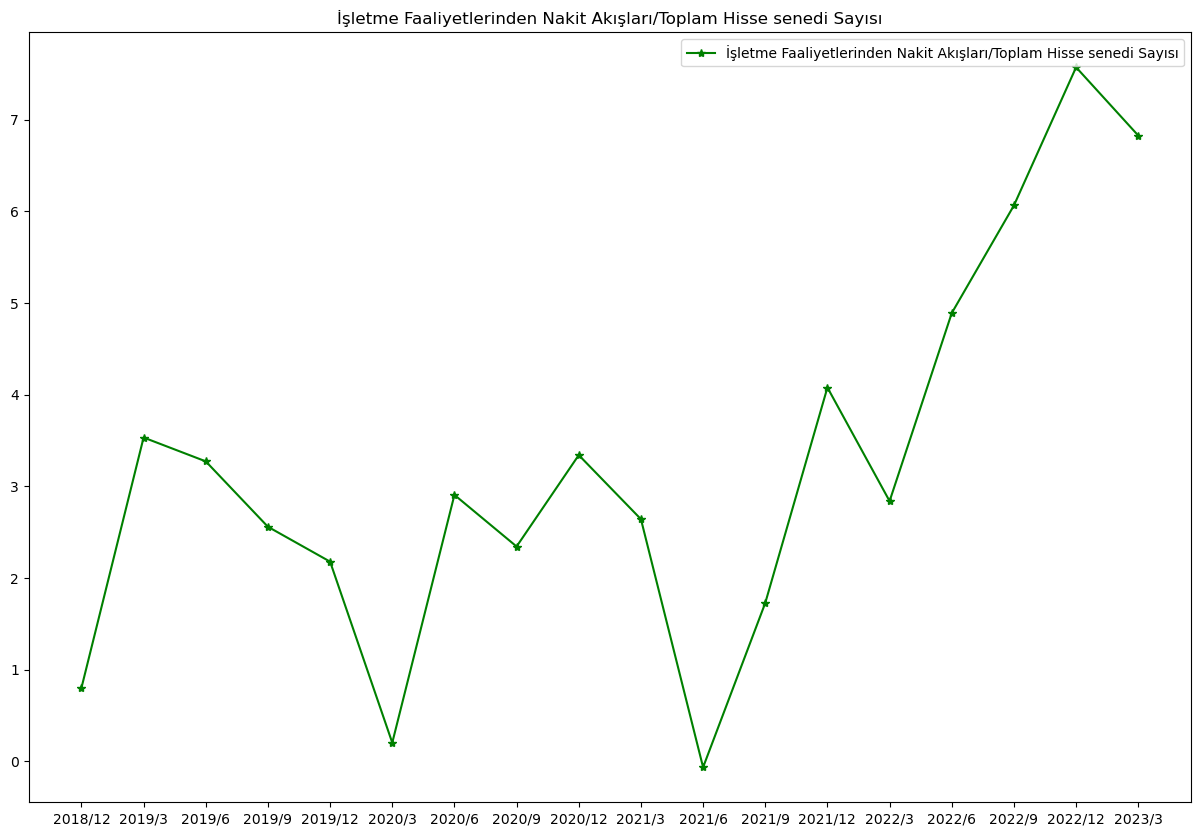

In [80]:
plt.figure(figsize=(15,10))
plt.plot(nakit_akis_oranlari.columns,nakit_akis_oranlari.loc["İşletme Faaliyetlerinden Nakit Akışları/Toplam Hisse senedi Sayısı"],color="Green",label="İşletme Faaliyetlerinden Nakit Akışları/Toplam Hisse senedi Sayısı",marker="*")
plt.title("İşletme Faaliyetlerinden Nakit Akışları/Toplam Hisse senedi Sayısı")
plt.legend()
plt.show()

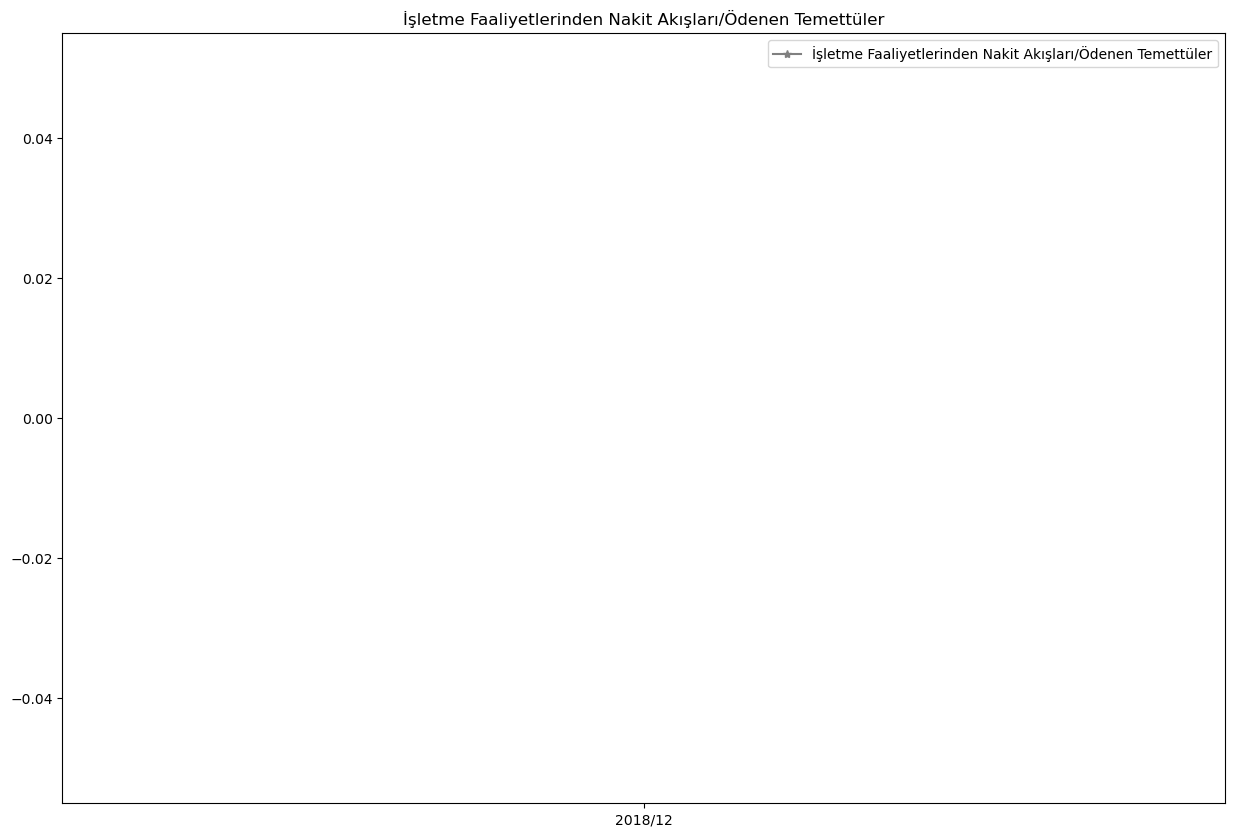

In [81]:
plt.figure(figsize=(15,10))
plt.plot(nakit_akis_oranlari.columns,nakit_akis_oranlari.loc["İşletme Faaliyetlerinden Nakit Akışları/Ödenen Temettüler"],color="Gray",label="İşletme Faaliyetlerinden Nakit Akışları/Ödenen Temettüler",marker="*")
plt.title("İşletme Faaliyetlerinden Nakit Akışları/Ödenen Temettüler")
plt.legend()
plt.show()

## Değerleme

In [82]:
fiyat=yf.download("TKNSA.IS",start="2018-12-01",interval = "1mo")["Adj Close"]
fiyat.head()

[*********************100%***********************]  1 of 1 completed


Date
2018-12-01   2.98
2019-01-01   3.30
2019-02-01   3.13
2019-03-01   2.66
2019-04-01   2.39
Name: Adj Close, dtype: float64

In [83]:
fiyat=fiyat.reset_index()
fiyat.head()

,Date,Adj Close
0,2018-12-01,2.98
1,2019-01-01,3.30
2,2019-02-01,3.13
3,2019-03-01,2.66
4,2019-04-01,2.39


In [84]:
fiyat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       56 non-null     datetime64[ns]
 1   Adj Close  56 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 KB


In [85]:
fiyat["Gün"]=fiyat["Date"].dt.day
fiyat["Ay"]=fiyat["Date"].dt.month
fiyat["Yıl"]=fiyat["Date"].dt.year
fiyat.head()

,Date,Adj Close,Gün,Ay,Yıl
0,2018-12-01,2.98,1,12,2018
1,2019-01-01,3.30,1,1,2019
2,2019-02-01,3.13,1,2,2019
3,2019-03-01,2.66,1,3,2019
4,2019-04-01,2.39,1,4,2019


In [86]:
donem=[]
for i,j in zip(fiyat["Yıl"],fiyat["Ay"]):
    donem.append(str(i)+"/"+str(j))

fiyat["Dönem"]=donem
fiyat.head()

,Date,Adj Close,Gün,Ay,Yıl,Dönem
0,2018-12-01,2.98,1,12,2018,2018/12
1,2019-01-01,3.30,1,1,2019,2019/1
2,2019-02-01,3.13,1,2,2019,2019/2
3,2019-03-01,2.66,1,3,2019,2019/3
4,2019-04-01,2.39,1,4,2019,2019/4


In [87]:
f=[]
d=[]
for i,j in enumerate(fiyat["Dönem"][:-1]):
    if "1" in j[5:]:
        if "2" not in j[6:]:
            if "1" not in j[6:]:
                f.append(round(fiyat["Adj Close"][i],2))
                d.append(fiyat["Dönem"][i])
    elif "4" in j[5:]:
        f.append(round(fiyat["Adj Close"][i],2))
        d.append(fiyat["Dönem"][i])
    elif "7" in j[5:]:
        f.append(round(fiyat["Adj Close"][i],2))
        d.append(fiyat["Dönem"][i])
    elif "10" in j[5:]:
        f.append(round(fiyat["Adj Close"][i],2))
        d.append(fiyat["Dönem"][i])
print(d)
print(f)

['2019/1', '2019/4', '2019/7', '2019/10', '2020/1', '2020/4', '2020/7', '2020/10', '2021/1', '2021/4', '2021/7', '2021/10', '2022/1', '2022/4', '2022/7', '2022/10', '2023/1', '2023/4']
[3.3, 2.39, 2.25, 2.65, 8.44, 7.17, 4.34, 5.58, 10.44, 6.85, 7.07, 6.19, 7.47, 8.02, 8.25, 18.65, 20.2, 16.39]


In [88]:
f[-1:]=round(fiyat["Adj Close"][-1:],2)
print(f)

[3.3, 2.39, 2.25, 2.65, 8.44, 7.17, 4.34, 5.58, 10.44, 6.85, 7.07, 6.19, 7.47, 8.02, 8.25, 18.65, 20.2, 21.98]


In [89]:
degerleme=yillik_veriler2.loc["  Ödenmiş Sermaye"][1:]
degerleme=pd.DataFrame(degerleme)
degerleme=degerleme.T
degerleme.loc["Fiyat"]=f[1:]
degerleme.loc["Piyasa Değeri"]=degerleme.loc["  Ödenmiş Sermaye"]*degerleme.loc["Fiyat"]
degerleme.loc["Satış Gelirleri"]=yillik_veriler2.loc["Satış Gelirleri"][1:]
degerleme.loc["Dönem Karı"]=yillik_veriler2.loc["DÖNEM KARI (ZARARI)"][1:]
degerleme.loc["Net Faaliyet Karı"]=yillik_veriler2.loc["Net Faaliyet Kar/Zararı"][1:]
degerleme.loc["Özkaynaklar"]=yillik_veriler2.loc["Özkaynaklar"][1:]
degerleme.loc["Amortisman Giderleri"]=yillik_veriler2.loc["Amortisman Giderleri"][1:]
degerleme.loc["FAVÖK"]=degerleme.loc["Net Faaliyet Karı"]+degerleme.loc["Amortisman Giderleri"]
degerleme.loc["Finansal Giderler"]=-yillik_veriler2.loc["(Esas Faaliyet Dışı) Finansal Giderler (-)"][1:]
degerleme.loc["HBK"]=round(degerleme.loc["Dönem Karı"]/degerleme.loc["  Ödenmiş Sermaye"],2)
degerleme.loc["Nakit ve Benzerleri"]=yillik_veriler2.loc["  Nakit ve Nakit Benzerleri"][1:]
degerleme.loc["Finansal Yatırımlar"]=yillik_veriler2.loc["  Finansal Yatırımlar"][1:]
degerleme.loc["KV Finansal Borç"]=yillik_veriler2.loc["  Finansal Borçlar"][1:]
degerleme.loc["UV Finansal Borç"]=yillik_veriler2.loc["Finansal Borçlar_2"][1:]
degerleme.loc["Net Borç"]=(degerleme.loc["KV Finansal Borç"]+degerleme.loc["UV Finansal Borç"])-(degerleme.loc["Nakit ve Benzerleri"]+degerleme.loc["Finansal Yatırımlar"])
degerleme.loc["Firma Değeri"]=degerleme.loc["Piyasa Değeri"]-degerleme.loc["Net Borç"]
degerleme.loc["Net Kar Marjı"]=round(degerleme.loc["Dönem Karı"]/degerleme.loc["Satış Gelirleri"],2)
degerleme.loc["FAVÖK Marjı"]=round(degerleme.loc["FAVÖK"]/degerleme.loc["Satış Gelirleri"],2)
degerleme.loc["Çeyreklik Nakit ve Benzerleri"]=ceyreklik_veriler2.loc["  Nakit ve Nakit Benzerleri","2019/3":]
degerleme.loc["Çeyreklik Finansal Yatırımlar"]=ceyreklik_veriler2.loc["  Finansal Yatırımlar","2019/3":]
degerleme.loc["Çeyreklik KV Finansal Borç"]=ceyreklik_veriler2.loc["  Finansal Borçlar","2019/3":]
degerleme.loc["Çeyreklik UV Finansal Borç"]=ceyreklik_veriler2.loc["Finansal Borçlar_2","2019/3":]
degerleme.loc["Çeyreklik Net Borç"]=(degerleme.loc["Çeyreklik KV Finansal Borç"]+degerleme.loc["Çeyreklik UV Finansal Borç"])-(degerleme.loc["Çeyreklik Nakit ve Benzerleri"]+degerleme.loc["Çeyreklik Finansal Yatırımlar"])
degerleme.loc["Çeyreklik Satışlar"]=ceyreklik_veriler2.loc["Satış Gelirleri","2019/3":]
degerleme.loc["Çeyreklik Net Kar"]=ceyreklik_veriler2.loc["DÖNEM KARI (ZARARI)","2019/3":]
degerleme.loc["Çeyreklik Özkaynaklar"]=ceyreklik_veriler2.loc["Özkaynaklar","2019/3":]
degerleme.loc["Çeyreklik Net Faaliyet Karı"]=ceyreklik_veriler2.loc["Net Faaliyet Kar/Zararı","2019/3":]
degerleme.loc["Çeyreklik Amortisman Giderleri"]=ceyreklik_veriler2.loc["Amortisman Giderleri","2019/3":]
degerleme.loc["Çeyreklik FAVÖK"]=degerleme.loc["Çeyreklik Net Faaliyet Karı"]+degerleme.loc["Çeyreklik Amortisman Giderleri"]
degerleme.loc["Net Borç/FAVÖK"]=round(degerleme.loc["Net Borç"]/degerleme.loc["FAVÖK"],2)
degerleme.loc["Faiz Karşılama Oranı"]=round(degerleme.loc["Net Faaliyet Karı"]/degerleme.loc["Finansal Giderler"],2)
degerleme.loc["F/K"]=round(degerleme.loc["Piyasa Değeri"]/degerleme.loc["Dönem Karı"],2)
degerleme.loc["PD/DD"]=round(degerleme.loc["Piyasa Değeri"]/degerleme.loc["Özkaynaklar"],2)
degerleme.loc["PD/Net Satışlar"]=round(degerleme.loc["Piyasa Değeri"]/degerleme.loc["Satış Gelirleri"],2)
degerleme.loc["FD/FAVÖK"]=round(degerleme.loc["Firma Değeri"]/degerleme.loc["FAVÖK"],2)
degerleme.loc["F/K Ortalama"]=degerleme.loc["F/K","2021/6":].mean()
degerleme.loc["F/K Medyan"]=np.median(degerleme.loc["F/K","2021/6":])
degerleme.loc["PD/DD Ortalama"]=degerleme.loc["PD/DD","2021/6":].mean()
degerleme.loc["PD/DD Medyan"]=np.median(degerleme.loc["PD/DD","2021/6":])
degerleme.loc["PD/Net Satışlar Ortalama"]=degerleme.loc["PD/Net Satışlar","2021/6":].mean()
degerleme.loc["PD/Net Satışlar Medyan"]=np.median(degerleme.loc["PD/Net Satışlar","2021/6":])
degerleme.loc["FD/FAVÖK Ortalama"]=degerleme.loc["FD/FAVÖK","2021/6":].mean()
degerleme.loc["FD/FAVÖK Medyan"]=np.median(degerleme.loc["FD/FAVÖK","2021/6":])


In [90]:
cb=[np.nan,np.nan,np.nan,np.nan]
nkb=[np.nan,np.nan,np.nan,np.nan]
hbkb=[np.nan,np.nan,np.nan,np.nan]
nbb=[np.nan,np.nan,np.nan,np.nan]

for i,j,k,k in zip(range(len(degerleme.loc["Satış Gelirleri"])-4),range(len(degerleme.loc["Dönem Karı"])-4),range(len(degerleme.loc["HBK"])-4),range(len(degerleme.loc["Net Borç"])-4)):
    cb.append(round(degerleme.loc["Satış Gelirleri"][i+4]/degerleme.loc["Satış Gelirleri"][i]-1,2))
    nkb.append(round(degerleme.loc["Dönem Karı"][j+4]/degerleme.loc["Dönem Karı"][j]-1,2))
    hbkb.append(round(degerleme.loc["HBK"][k+4]/degerleme.loc["HBK"][k]-1,2))
    nbb.append(round(degerleme.loc["Net Borç"][k+4]/degerleme.loc["Net Borç"][k]-1,2))
    
degerleme.loc["Ciro Büyüme"]=cb
degerleme.loc["Net Kar Büyüme"]=nkb
degerleme.loc["HBK Büyüme"]=hbkb
degerleme.loc["Net Borç Büyüme"]=nbb

In [91]:
ysp_2019=[]
ysp_2020=[]
ysp_2021=[]
ysp_2022=[]
ynp_2019=[]
ynp_2020=[]
ynp_2021=[]
ynp_2022=[]
yop_2019=[]
yop_2020=[]
yop_2021=[]
yop_2022=[]
yfp_2019=[]
yfp_2020=[]
yfp_2021=[]
yfp_2022=[]
nbp_2019=[]
nbp_2020=[]
nbp_2021=[]
nbp_2022=[]



for i,j,k,l in zip(range(0,4),range(4,8),range(8,12),range(12,16)):
    ysp_2019.append(round(degerleme.loc["Çeyreklik Satışlar"][i]/degerleme.loc["Satış Gelirleri"][3],2))
    ysp_2020.append(round(degerleme.loc["Çeyreklik Satışlar"][j]/degerleme.loc["Satış Gelirleri"][7],2))
    ysp_2021.append(round(degerleme.loc["Çeyreklik Satışlar"][k]/degerleme.loc["Satış Gelirleri"][11],2))
    ysp_2022.append(round(degerleme.loc["Çeyreklik Satışlar"][l]/degerleme.loc["Satış Gelirleri"][15],2))
    ynp_2019.append(round(degerleme.loc["Çeyreklik Net Kar"][i]/degerleme.loc["Dönem Karı"][3],2))
    ynp_2020.append(round(degerleme.loc["Çeyreklik Net Kar"][j]/degerleme.loc["Dönem Karı"][7],2))
    ynp_2021.append(round(degerleme.loc["Çeyreklik Net Kar"][k]/degerleme.loc["Dönem Karı"][11],2))
    ynp_2022.append(round(degerleme.loc["Çeyreklik Net Kar"][l]/degerleme.loc["Dönem Karı"][15],2))
    yop_2019.append(round(degerleme.loc["Çeyreklik Özkaynaklar"][i]/degerleme.loc["Özkaynaklar"][3],2))
    yop_2020.append(round(degerleme.loc["Çeyreklik Özkaynaklar"][j]/degerleme.loc["Özkaynaklar"][7],2))
    yop_2021.append(round(degerleme.loc["Çeyreklik Özkaynaklar"][k]/degerleme.loc["Özkaynaklar"][11],2))
    yop_2022.append(round(degerleme.loc["Çeyreklik Özkaynaklar"][l]/degerleme.loc["Özkaynaklar"][15],2))
    yfp_2019.append(round(degerleme.loc["Çeyreklik FAVÖK"][i]/degerleme.loc["FAVÖK"][3],2))
    yfp_2020.append(round(degerleme.loc["Çeyreklik FAVÖK"][j]/degerleme.loc["FAVÖK"][7],2))
    yfp_2021.append(round(degerleme.loc["Çeyreklik FAVÖK"][k]/degerleme.loc["FAVÖK"][11],2))
    yfp_2022.append(round(degerleme.loc["Çeyreklik FAVÖK"][l]/degerleme.loc["FAVÖK"][15],2))
    nbp_2019.append(round(degerleme.loc["Çeyreklik Net Borç"][i]/degerleme.loc["Net Borç"][3],2))
    nbp_2020.append(round(degerleme.loc["Çeyreklik Net Borç"][j]/degerleme.loc["Net Borç"][7],2))
    nbp_2021.append(round(degerleme.loc["Çeyreklik Net Borç"][k]/degerleme.loc["Net Borç"][11],2))
    nbp_2022.append(round(degerleme.loc["Çeyreklik Net Borç"][l]/degerleme.loc["Net Borç"][15],2))
       
ysp=ysp_2019+ysp_2020+ysp_2021+ysp_2022
ynp=ynp_2019+ynp_2020+ynp_2021+ynp_2022
yop=yop_2019+yop_2020+yop_2021+yop_2022
yfp=yfp_2019+yfp_2020+yfp_2021+yfp_2022
nbp=nbp_2019+nbp_2020+nbp_2021+nbp_2022

ysp.append(np.nan)
ynp.append(np.nan)
yop.append(np.nan)
yfp.append(np.nan)
nbp.append(np.nan)

degerleme.loc["Yıllık Satışlardaki Payları"]=ysp
degerleme.loc["Yıllık Net Kardaki Payları"]=ynp
degerleme.loc["Yıllık Öz Kaynaklardaki Payları"]=yop
degerleme.loc["Yıllık FAVÖKdeki Payları"]=yfp
degerleme.loc["Yıllık Net Borçtaki  Payları"]=nbp
           

degerleme

,2019/3,2019/6,2019/9,2019/12,2020/3,2020/6,2020/9,2020/12,2021/3,2021/6,2021/9,2021/12,2022/3,2022/6,2022/9,2022/12,2023/3
Ödenmiş Sermaye,"110,000,000.00","110,000,000.00","110,000,000.00","110,000,000.00","110,000,000.00","110,000,000.00","110,000,000.00","110,000,000.00","110,000,000.00","201,000,000.00","201,000,000.00","201,000,000.00","292,000,000.00","201,000,000.00","201,000,000.00","201,000,000.00","201,000,000.00"
Fiyat,2.39,2.25,2.65,8.44,7.17,4.34,5.58,10.44,6.85,7.07,6.19,7.47,8.02,8.25,18.65,20.20,21.98
Piyasa Değeri,"262,900,000.00","247,500,000.00","291,500,000.00","928,400,000.00","788,700,000.00","477,400,000.00","613,800,000.00","1,148,400,000.00","753,500,000.00","1,421,070,000.00","1,244,190,000.00","1,501,470,000.00","2,341,840,000.00","1,658,250,000.00","3,748,650,000.00","4,060,200,000.00","4,417,980,000.00"
Satış Gelirleri,"3,511,191,000.00","3,622,350,000.00","3,739,810,000.00","4,136,971,000.00","4,344,690,000.00","4,297,728,000.00","4,931,364,000.00","5,606,519,000.00","6,019,380,000.00","6,586,253,000.00","6,883,355,000.00","7,520,079,000.00","8,901,900,000.00","10,786,011,000.00","13,357,485,000.00","17,440,964,000.00","21,219,455,000.00"
Dönem Karı,"-112,499,000.00","-148,667,000.00","-183,940,000.00","-148,634,000.00","-127,304,000.00","-101,171,000.00","-3,359,000.00","85,296,000.00","118,556,000.00","129,207,000.00","96,076,000.00","131,464,000.00","187,138,000.00","326,078,000.00","437,187,000.00","524,927,000.00","608,884,000.00"
Net Faaliyet Karı,"111,304,000.00","132,413,000.00","131,713,000.00","175,221,000.00","193,828,000.00","162,721,000.00","256,346,000.00","351,645,000.00","418,637,000.00","485,469,000.00","487,156,000.00","538,740,000.00","626,047,000.00","821,141,000.00","1,013,489,000.00","1,230,720,000.00","1,466,166,000.00"
Özkaynaklar,"-209,908,000.00","-247,946,000.00","-282,356,000.00","-251,852,000.00","-379,840,000.00","-352,363,000.00","-255,040,000.00","-165,546,000.00","-46,454,000.00","240,371,000.00","206,188,000.00","242,982,000.00","706,656,000.00","572,304,000.00","672,445,000.00","761,219,000.00","1,359,138,000.00"
Amortisman Giderleri,"57,744,000.00","83,836,000.00","109,228,000.00","133,298,000.00","129,502,000.00","126,229,000.00","120,890,000.00","118,814,000.00","121,385,000.00","124,484,000.00","132,645,000.00","141,865,000.00","152,058,000.00","164,455,000.00","179,026,000.00","198,423,000.00","228,299,000.00"
FAVÖK,"169,048,000.00","216,249,000.00","240,941,000.00","308,519,000.00","323,330,000.00","288,950,000.00","377,236,000.00","470,459,000.00","540,022,000.00","609,953,000.00","619,801,000.00","680,605,000.00","778,105,000.00","985,596,000.00","1,192,515,000.00","1,429,143,000.00","1,694,465,000.00"
Finansal Giderler,"125,933,000.00","158,646,000.00","187,400,000.00","215,549,000.00","222,289,000.00","217,935,000.00","211,106,000.00","214,737,000.00","224,460,000.00","242,509,000.00","256,212,000.00","265,856,000.00","289,491,000.00","335,389,000.00","401,979,000.00","532,440,000.00","652,618,000.00"


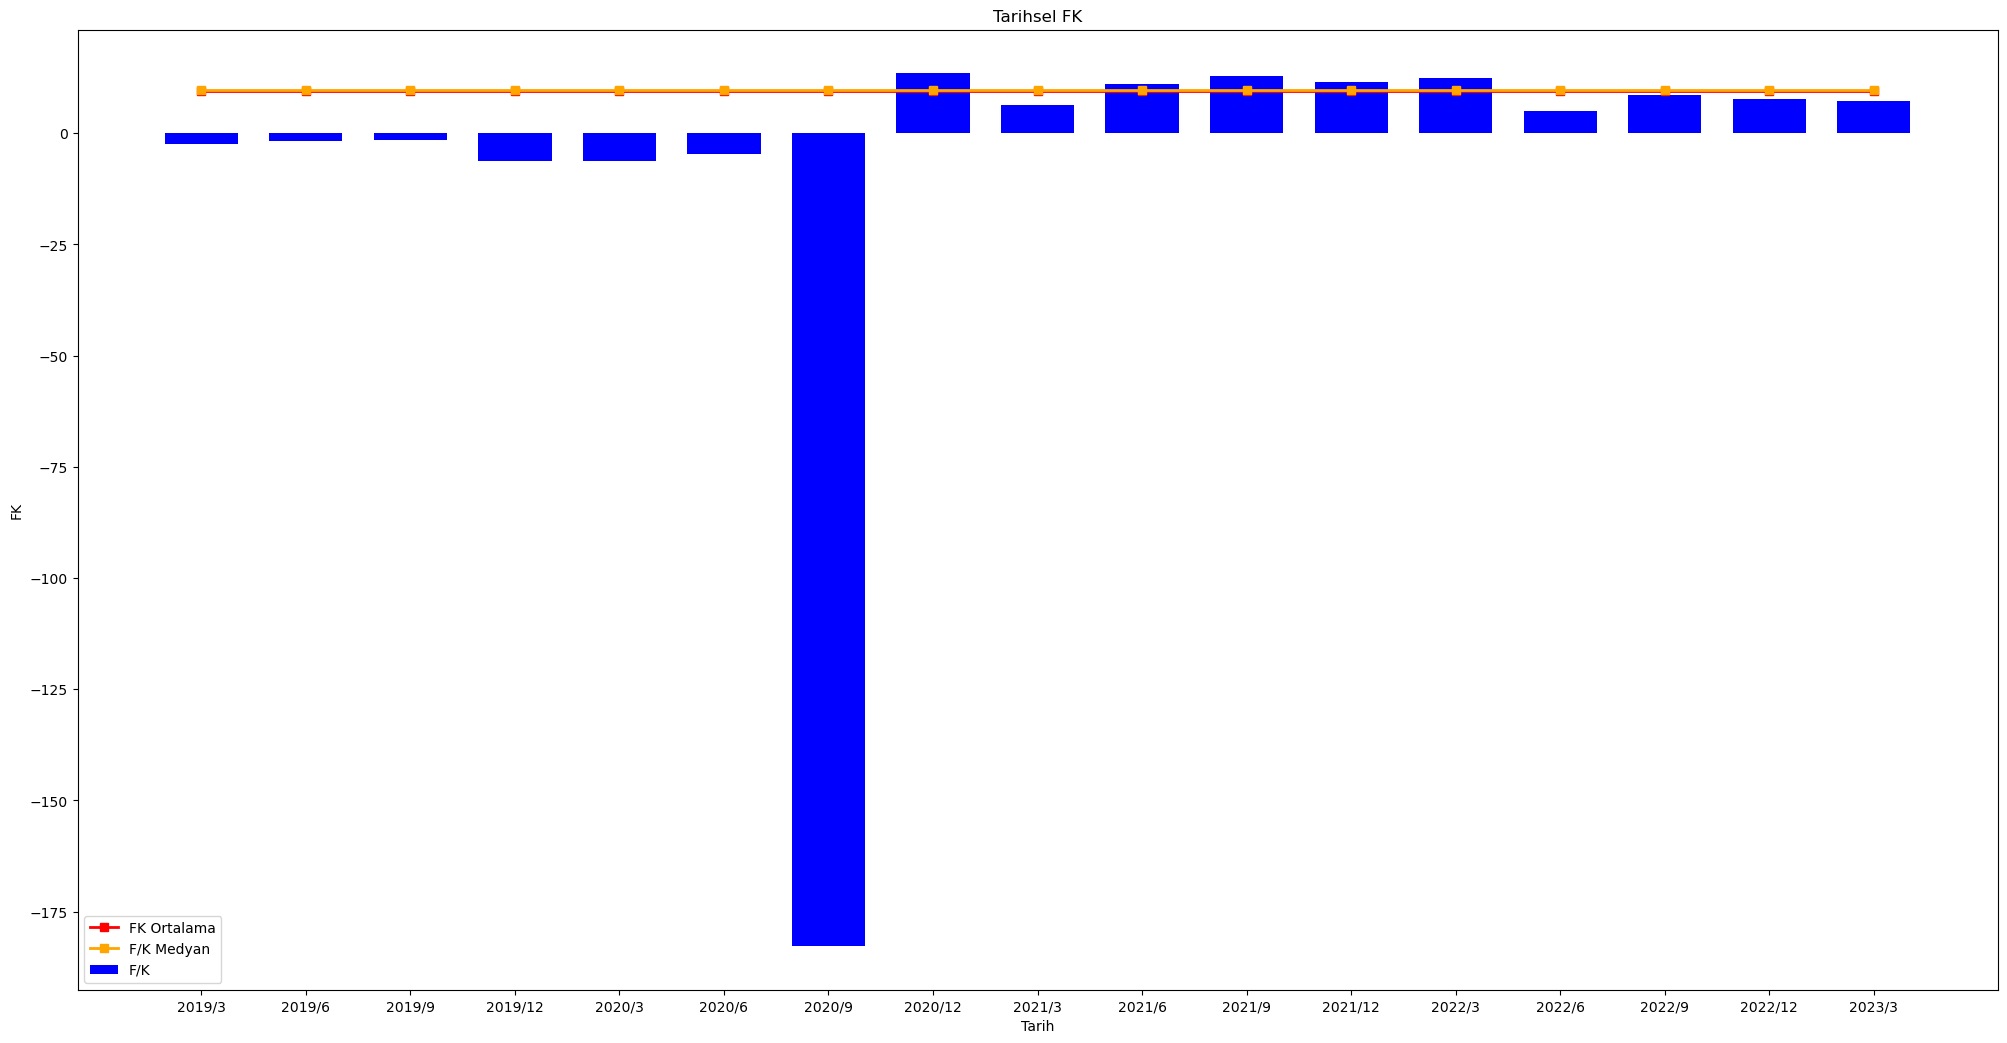

In [92]:
fig=plt.figure()
grafik=fig.add_axes([1,1,3,2])
grafik.bar(degerleme.columns,degerleme.loc["F/K"],color="blue", width=0.7, label="F/K")
grafik.plot(degerleme.columns,degerleme.loc["F/K Ortalama"],color="red", linewidth=2, marker="s", label="FK Ortalama")
grafik.plot(degerleme.columns,degerleme.loc["F/K Medyan"],color="orange", linewidth=2, marker="s", label="F/K Medyan")
grafik.set_title("Tarihsel FK")
grafik.set_xlabel("Tarih")
grafik.set_ylabel("FK")
grafik.legend()
plt.show()

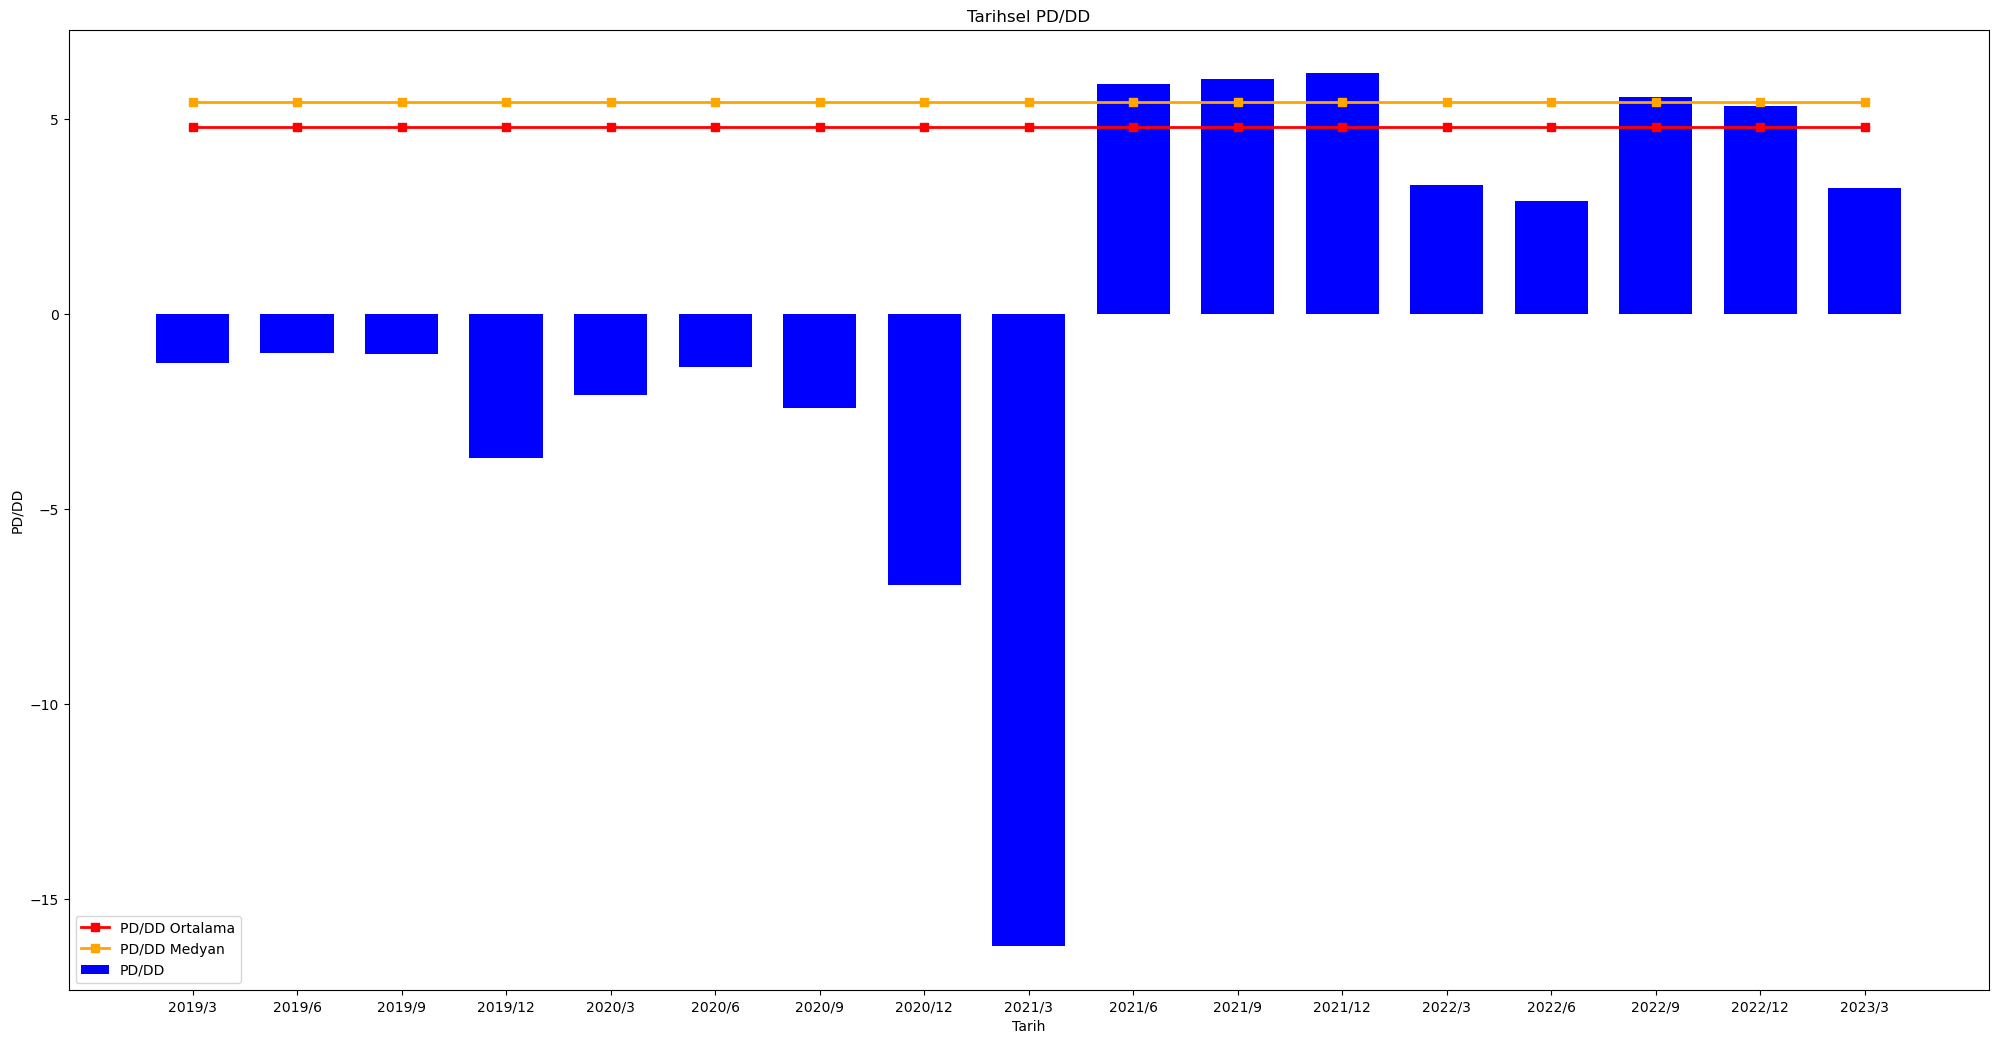

In [93]:
fig=plt.figure()
grafik=fig.add_axes([1,1,3,2])
grafik.bar(degerleme.columns,degerleme.loc["PD/DD"],color="blue", width=0.7, label="PD/DD")
grafik.plot(degerleme.columns,degerleme.loc["PD/DD Ortalama"],color="red", linewidth=2, marker="s", label="PD/DD Ortalama")
grafik.plot(degerleme.columns,degerleme.loc["PD/DD Medyan"],color="orange", linewidth=2, marker="s", label="PD/DD Medyan")
grafik.set_title("Tarihsel PD/DD")
grafik.set_xlabel("Tarih")
grafik.set_ylabel("PD/DD")
grafik.legend()
plt.show()

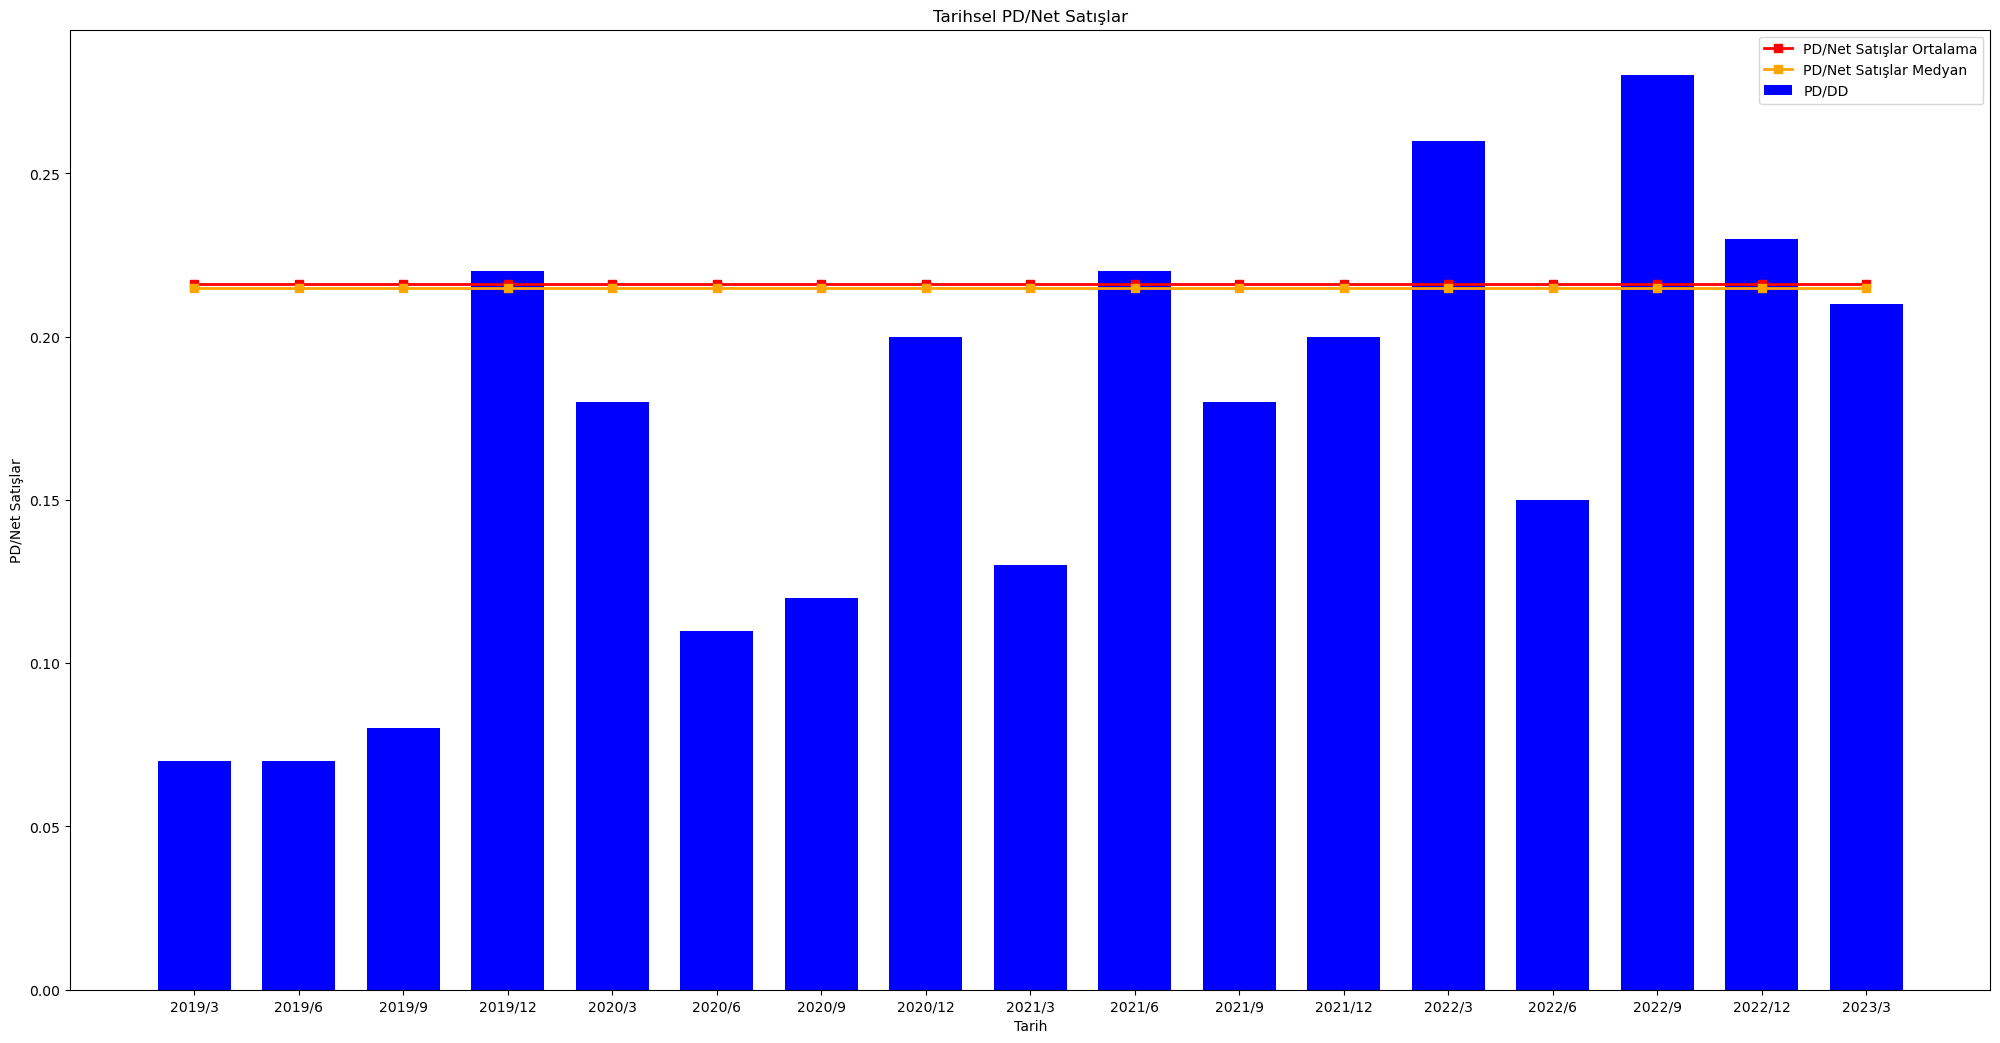

In [94]:
fig=plt.figure()
grafik=fig.add_axes([1,1,3,2])
grafik.bar(degerleme.columns,degerleme.loc["PD/Net Satışlar"],color="blue", width=0.7, label="PD/DD")
grafik.plot(degerleme.columns,degerleme.loc["PD/Net Satışlar Ortalama"],color="red", linewidth=2, marker="s", label="PD/Net Satışlar Ortalama")
grafik.plot(degerleme.columns,degerleme.loc["PD/Net Satışlar Medyan"],color="orange", linewidth=2, marker="s", label="PD/Net Satışlar Medyan")
grafik.set_title("Tarihsel PD/Net Satışlar")
grafik.set_xlabel("Tarih")
grafik.set_ylabel("PD/Net Satışlar")
grafik.legend()
plt.show()

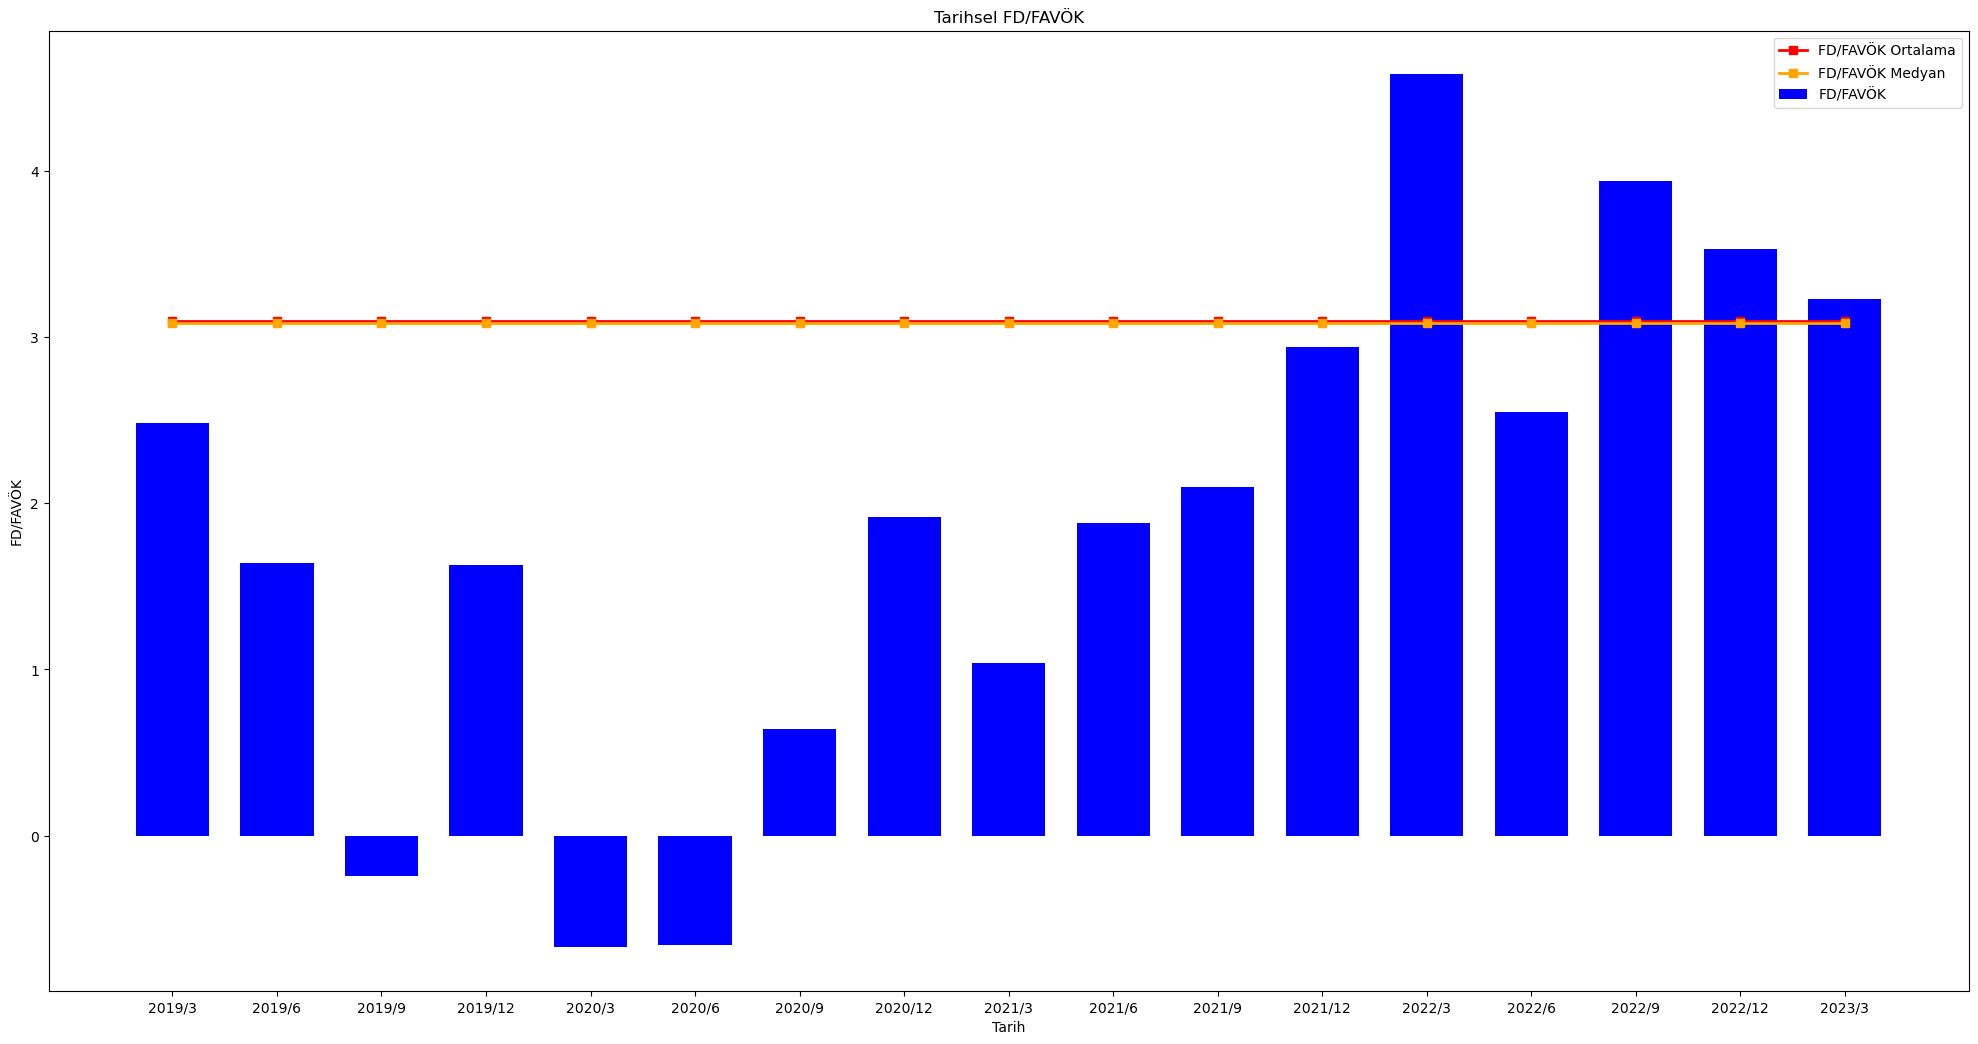

In [95]:
fig=plt.figure()
grafik=fig.add_axes([1,1,3,2])
grafik.bar(degerleme.columns,degerleme.loc["FD/FAVÖK"],color="blue", width=0.7, label="FD/FAVÖK")
grafik.plot(degerleme.columns,degerleme.loc["FD/FAVÖK Ortalama"],color="red", linewidth=2, marker="s", label="FD/FAVÖK Ortalama")
grafik.plot(degerleme.columns,degerleme.loc["FD/FAVÖK Medyan"],color="orange", linewidth=2, marker="s", label="FD/FAVÖK Medyan")
grafik.set_title("Tarihsel FD/FAVÖK")
grafik.set_xlabel("Tarih")
grafik.set_ylabel("FD/FAVÖK")
grafik.legend()
plt.show()

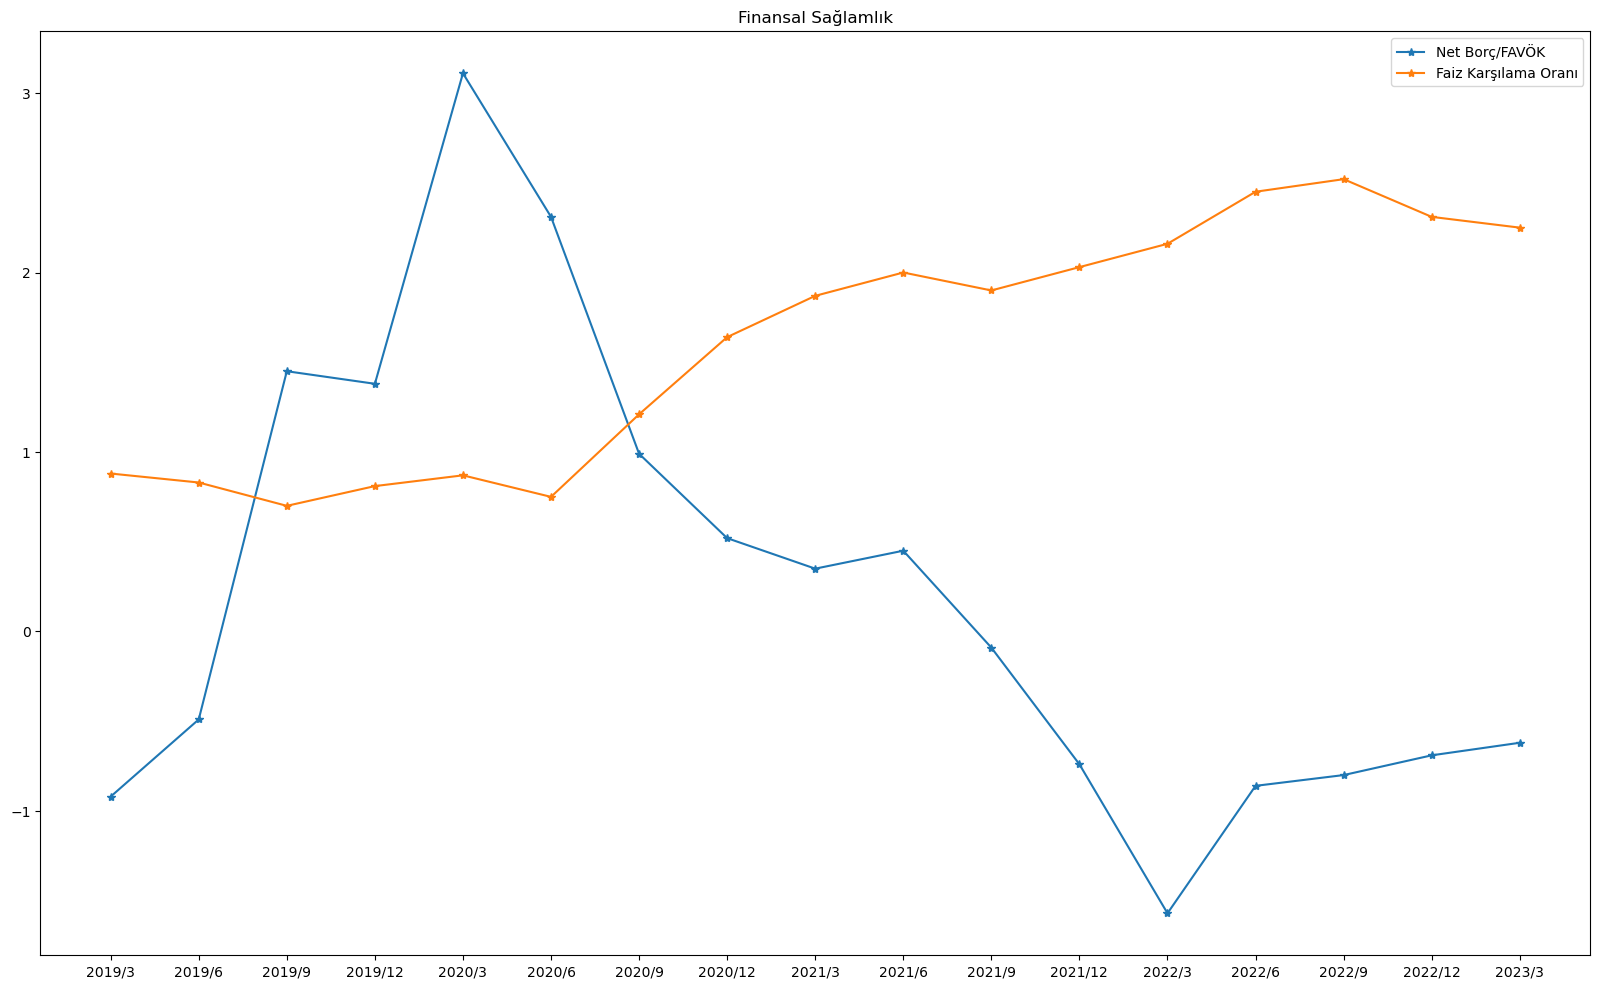

In [96]:
plt.figure(figsize=(20,12))
plt.plot(degerleme.columns,degerleme.loc["Net Borç/FAVÖK"],label="Net Borç/FAVÖK",marker="*")
plt.plot(degerleme.columns,degerleme.loc["Faiz Karşılama Oranı"],label="Faiz Karşılama Oranı",marker="*")
plt.title("Finansal Sağlamlık")
plt.legend()
plt.show()

In [97]:
tahmin_tablo=pd.DataFrame(index=["3 Yıllık Ortalama Ciro Büyüme","3 Yıllık Ortalama Net Kar Büyüme","1. Çeyrek Ciro Ortalama Pay","2. Çeyrek Ciro Ortalama Pay","3. Çeyrek Ciro Ortalama Pay","4. Çeyrek Ciro Ortalama Pay","Net Kar Marjı","1. Çeyrek Net Kar Ortalama Pay","2. Çeyrek Net Kar Ortalama Pay","3. Çeyrek Net Kar Ortalama Pay","4. Çeyrek Net Kar Ortalama Pay","1. Çeyrek Öz Kaynaklar Ortalama Pay","2. Çeyrek Öz Kaynaklar Ortalama Pay","3. Çeyrek Öz Kaynaklar Ortalama Pay","4. Çeyrek Öz Kaynaklar Ortalama Pay","Favok Marjı","1. Çeyrek FAVÖK Ortalama Pay","2. Çeyrek FAVÖK Ortalama Pay","3. Çeyrek FAVÖK Ortalama Pay","4. Çeyrek FAVÖK Ortalama Pay","1. Çeyrek Net Borç Ortalama Pay","2. Çeyrek Net Borç Ortalama Pay","3. Çeyrek Net Borç Ortalama Pay","4. Çeyrek Net Borç Ortalama Pay","Net Borç ortalama Büyüme"],
                          columns=["Ortalama","Median","Standart Sapma","Tahmin"])
tahmin_tablo.loc["3 Yıllık Ortalama Ciro Büyüme","Ortalama"]=round(degerleme.loc["Ciro Büyüme","2020/3":"2022/12"].mean(),2)
tahmin_tablo.loc["3 Yıllık Ortalama Ciro Büyüme","Median"]=round(np.median(degerleme.loc["Ciro Büyüme","2020/3":"2022/12"]),2)
tahmin_tablo.loc["3 Yıllık Ortalama Ciro Büyüme","Standart Sapma"]=round(degerleme.loc["Ciro Büyüme","2020/3":"2022/12"].std(),2)

tahmin_tablo.loc["3 Yıllık Ortalama Net Kar Büyüme","Ortalama"]=round(degerleme.loc["Net Kar Büyüme","2020/3":"2022/12"].mean(),2)
tahmin_tablo.loc["3 Yıllık Ortalama Net Kar Büyüme","Median"]=round(np.median(degerleme.loc["Net Kar Büyüme","2020/3":"2022/12"]),2)
tahmin_tablo.loc["3 Yıllık Ortalama Net Kar Büyüme","Standart Sapma"]=round(degerleme.loc["Net Kar Büyüme","2020/3":"2022/12"].std(),2)

tahmin_tablo.loc["1. Çeyrek Ciro Ortalama Pay","Ortalama"]=round((degerleme.loc["Yıllık Satışlardaki Payları","2019/3"]+
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2020/3"]+
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2021/3"]+
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2022/3"])/4,2)
tahmin_tablo.loc["1. Çeyrek Ciro Ortalama Pay","Median"]=round(np.median([degerleme.loc["Yıllık Satışlardaki Payları","2019/3"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2020/3"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2021/3"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2022/3"]]),2)
tahmin_tablo.loc["1. Çeyrek Ciro Ortalama Pay","Standart Sapma"]=round(np.std([degerleme.loc["Yıllık Satışlardaki Payları","2019/3"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2020/3"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2021/3"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2022/3"]]),2)

tahmin_tablo.loc["2. Çeyrek Ciro Ortalama Pay","Ortalama"]=round((degerleme.loc["Yıllık Satışlardaki Payları","2019/6"]+
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2020/6"]+
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2021/6"]+
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2022/6"])/4,2)
tahmin_tablo.loc["2. Çeyrek Ciro Ortalama Pay","Median"]=round(np.median([degerleme.loc["Yıllık Satışlardaki Payları","2019/6"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2020/6"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2021/6"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2022/6"]]),2)
tahmin_tablo.loc["2. Çeyrek Ciro Ortalama Pay","Standart Sapma"]=round(np.std([degerleme.loc["Yıllık Satışlardaki Payları","2019/6"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2020/6"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2021/6"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2022/6"]]),2)

tahmin_tablo.loc["3. Çeyrek Ciro Ortalama Pay","Ortalama"]=round((degerleme.loc["Yıllık Satışlardaki Payları","2019/9"]+
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2020/9"]+
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2021/9"]+
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2022/9"])/4,2)
tahmin_tablo.loc["3. Çeyrek Ciro Ortalama Pay","Median"]=round(np.median([degerleme.loc["Yıllık Satışlardaki Payları","2019/9"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2020/9"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2021/9"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2022/9"]]),2)
tahmin_tablo.loc["3. Çeyrek Ciro Ortalama Pay","Standart Sapma"]=round(np.std([degerleme.loc["Yıllık Satışlardaki Payları","2019/9"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2020/9"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2021/9"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2022/9"]]),2)

tahmin_tablo.loc["4. Çeyrek Ciro Ortalama Pay","Ortalama"]=round((degerleme.loc["Yıllık Satışlardaki Payları","2019/12"]+
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2020/12"]+
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2021/12"]+
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2022/12"])/4,2)
tahmin_tablo.loc["4. Çeyrek Ciro Ortalama Pay","Median"]=round(np.median([degerleme.loc["Yıllık Satışlardaki Payları","2019/12"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2020/12"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2021/12"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2022/12"]]),2)
tahmin_tablo.loc["4. Çeyrek Ciro Ortalama Pay","Standart Sapma"]=round(np.std([degerleme.loc["Yıllık Satışlardaki Payları","2019/12"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2020/12"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2021/12"],
                                                                 degerleme.loc["Yıllık Satışlardaki Payları","2022/12"]]),2)

tahmin_tablo.loc["Net Kar Marjı","Tahmin"]=0.03
tahmin_tablo.loc["1. Çeyrek Net Kar Ortalama Pay","Ortalama"]=round((degerleme.loc["Yıllık Net Kardaki Payları","2019/3"]+
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2020/3"]+
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2021/3"]+
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2022/3"])/4,2)
tahmin_tablo.loc["1. Çeyrek Net Kar Ortalama Pay","Median"]=round(np.median([degerleme.loc["Yıllık Net Kardaki Payları","2019/3"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2020/3"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2021/3"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2022/3"]]),2)
tahmin_tablo.loc["1. Çeyrek Net Kar Ortalama Pay","Standart Sapma"]=round(np.std([degerleme.loc["Yıllık Net Kardaki Payları","2019/3"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2020/3"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2021/3"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2022/3"]]),2)



tahmin_tablo.loc["2. Çeyrek Net Kar Ortalama Pay","Ortalama"]=round((degerleme.loc["Yıllık Net Kardaki Payları","2019/6"]+
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2020/6"]+
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2021/6"]+
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2022/6"])/4,2)
tahmin_tablo.loc["2. Çeyrek Net Kar Ortalama Pay","Median"]=round(np.median([degerleme.loc["Yıllık Net Kardaki Payları","2019/6"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2020/6"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2021/6"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2022/6"]]),2)
tahmin_tablo.loc["2. Çeyrek Net Kar Ortalama Pay","Standart Sapma"]=round(np.std([degerleme.loc["Yıllık Net Kardaki Payları","2019/6"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2020/6"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2021/6"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2022/6"]]),2)

tahmin_tablo.loc["3. Çeyrek Net Kar Ortalama Pay","Ortalama"]=round((degerleme.loc["Yıllık Net Kardaki Payları","2019/9"]+
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2020/9"]+
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2021/9"]+
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2022/9"])/4,2)
tahmin_tablo.loc["3. Çeyrek Net Kar Ortalama Pay","Median"]=round(np.median([degerleme.loc["Yıllık Net Kardaki Payları","2019/9"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2020/9"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2021/9"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2022/9"]]),2)
tahmin_tablo.loc["3. Çeyrek Net Kar Ortalama Pay","Standart Sapma"]=round(np.std([degerleme.loc["Yıllık Net Kardaki Payları","2019/9"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2020/9"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2021/9"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2022/9"]]),2)

tahmin_tablo.loc["4. Çeyrek Net Kar Ortalama Pay","Ortalama"]=round((degerleme.loc["Yıllık Net Kardaki Payları","2019/12"]+
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2020/12"]+
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2021/12"]+
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2022/12"])/4,2)
tahmin_tablo.loc["4. Çeyrek Net Kar Ortalama Pay","Median"]=round(np.median([degerleme.loc["Yıllık Net Kardaki Payları","2019/12"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2020/12"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2021/12"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2022/12"]]),2)
tahmin_tablo.loc["4. Çeyrek Net Kar Ortalama Pay","Standart Sapma"]=round(np.std([degerleme.loc["Yıllık Net Kardaki Payları","2019/12"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2020/12"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2021/12"],
                                                                 degerleme.loc["Yıllık Net Kardaki Payları","2022/12"]]),2)

tahmin_tablo.loc["1. Çeyrek Öz Kaynaklar Ortalama Pay","Ortalama"]=round((degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2019/3"]+
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2020/3"]+
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2021/3"]+
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2022/3"])/4,2)
tahmin_tablo.loc["1. Çeyrek Öz Kaynaklar Ortalama Pay","Median"]=round(np.median([degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2019/3"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2020/3"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2021/3"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2022/3"]]),2)
tahmin_tablo.loc["1. Çeyrek Öz Kaynaklar Ortalama Pay","Standart Sapma"]=round(np.std([degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2019/3"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2020/3"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2021/3"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2022/3"]]),2)

tahmin_tablo.loc["2. Çeyrek Öz Kaynaklar Ortalama Pay","Ortalama"]=round((degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2019/6"]+
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2020/6"]+
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2021/6"]+
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2022/6"])/4,2)
tahmin_tablo.loc["2. Çeyrek Öz Kaynaklar Ortalama Pay","Median"]=round(np.median([degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2019/6"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2020/6"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2021/6"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2022/6"]]),2)
tahmin_tablo.loc["2. Çeyrek Öz Kaynaklar Ortalama Pay","Standart Sapma"]=round(np.std([degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2019/6"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2020/6"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2021/6"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2022/6"]]),2)


tahmin_tablo.loc["3. Çeyrek Öz Kaynaklar Ortalama Pay","Ortalama"]=round((degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2019/9"]+
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2020/9"]+
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2021/9"]+
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2022/9"])/4,2)
tahmin_tablo.loc["3. Çeyrek Öz Kaynaklar Ortalama Pay","Median"]=round(np.median([degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2019/9"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2020/9"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2021/9"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2022/9"]]),2)
tahmin_tablo.loc["3. Çeyrek Öz Kaynaklar Ortalama Pay","Standart Sapma"]=round(np.std([degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2019/9"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2020/9"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2021/9"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2022/9"]]),2)

tahmin_tablo.loc["4. Çeyrek Öz Kaynaklar Ortalama Pay","Ortalama"]=round((degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2019/12"]+
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2020/12"]+
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2021/12"]+
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2022/12"])/4,2)
tahmin_tablo.loc["4. Çeyrek Öz Kaynaklar Ortalama Pay","Median"]=round(np.median([degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2019/12"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2020/12"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2021/12"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2022/12"]]),2)
tahmin_tablo.loc["4. Çeyrek Öz Kaynaklar Ortalama Pay","Standart Sapma"]=round(np.std([degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2019/12"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2020/12"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2021/12"],
                                                                 degerleme.loc["Yıllık Öz Kaynaklardaki Payları","2022/12"]]),2)

tahmin_tablo.loc["Favok Marjı","Tahmin"]=0.08

tahmin_tablo.loc["1. Çeyrek FAVÖK Ortalama Pay","Ortalama"]=round((degerleme.loc["Yıllık FAVÖKdeki Payları","2019/3"]+
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2020/3"]+
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2021/3"]+
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2022/3"])/4,2)
tahmin_tablo.loc["1. Çeyrek FAVÖK Ortalama Pay","Median"]=round(np.median([degerleme.loc["Yıllık FAVÖKdeki Payları","2019/3"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2020/3"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2021/3"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2022/3"]]),2)
tahmin_tablo.loc["1. Çeyrek FAVÖK Ortalama Pay","Standart Sapma"]=round(np.std([degerleme.loc["Yıllık FAVÖKdeki Payları","2019/3"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2020/3"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2021/3"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2022/3"]]),2)

tahmin_tablo.loc["2. Çeyrek FAVÖK Ortalama Pay","Ortalama"]=round((degerleme.loc["Yıllık FAVÖKdeki Payları","2019/6"]+
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2020/6"]+
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2021/6"]+
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2022/6"])/4,2)
tahmin_tablo.loc["2. Çeyrek FAVÖK Ortalama Pay","Median"]=round(np.median([degerleme.loc["Yıllık FAVÖKdeki Payları","2019/6"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2020/6"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2021/6"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2022/6"]]),2)
tahmin_tablo.loc["2. Çeyrek FAVÖK Ortalama Pay","Standart Sapma"]=round(np.std([degerleme.loc["Yıllık FAVÖKdeki Payları","2019/6"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2020/6"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2021/6"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2022/6"]]),2)

tahmin_tablo.loc["3. Çeyrek FAVÖK Ortalama Pay","Ortalama"]=round((degerleme.loc["Yıllık FAVÖKdeki Payları","2019/9"]+
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2020/9"]+
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2021/9"]+
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2022/9"])/4,2)
tahmin_tablo.loc["3. Çeyrek FAVÖK Ortalama Pay","Median"]=round(np.median([degerleme.loc["Yıllık FAVÖKdeki Payları","2019/9"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2020/9"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2021/9"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2022/9"]]),2)
tahmin_tablo.loc["3. Çeyrek FAVÖK Ortalama Pay","Standart Sapma"]=round(np.std([degerleme.loc["Yıllık FAVÖKdeki Payları","2019/9"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2020/9"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2021/9"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2022/9"]]),2)

tahmin_tablo.loc["4. Çeyrek FAVÖK Ortalama Pay","Ortalama"]=round((degerleme.loc["Yıllık FAVÖKdeki Payları","2019/12"]+
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2020/12"]+
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2021/12"]+
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2022/12"])/4,2)
tahmin_tablo.loc["4. Çeyrek FAVÖK Ortalama Pay","Median"]=round(np.median([degerleme.loc["Yıllık FAVÖKdeki Payları","2019/12"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2020/12"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2021/12"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2022/12"]]),2)
tahmin_tablo.loc["4. Çeyrek FAVÖK Ortalama Pay","Standart Sapma"]=round(np.std([degerleme.loc["Yıllık FAVÖKdeki Payları","2019/12"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2020/12"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2021/12"],
                                                                 degerleme.loc["Yıllık FAVÖKdeki Payları","2022/12"]]),2)

tahmin_tablo.loc["1. Çeyrek Net Borç Ortalama Pay","Ortalama"]=round((degerleme.loc["Yıllık Net Borçtaki  Payları","2019/3"]+
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2020/3"]+
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2021/3"]+
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2022/3"])/4,2)
tahmin_tablo.loc["1. Çeyrek Net Borç Ortalama Pay","Median"]=round(np.median([degerleme.loc["Yıllık Net Borçtaki  Payları","2019/3"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2020/3"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2021/3"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2022/3"]]),2)
tahmin_tablo.loc["1. Çeyrek Net Borç Ortalama Pay","Standart Sapma"]=round(np.std([degerleme.loc["Yıllık Net Borçtaki  Payları","2019/3"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2020/3"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2021/3"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2022/3"]]),2)

tahmin_tablo.loc["2. Çeyrek Net Borç Ortalama Pay","Ortalama"]=round((degerleme.loc["Yıllık Net Borçtaki  Payları","2019/6"]+
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2020/6"]+
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2021/6"]+
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2022/6"])/4,2)
tahmin_tablo.loc["2. Çeyrek Net Borç Ortalama Pay","Median"]=round(np.median([degerleme.loc["Yıllık Net Borçtaki  Payları","2019/6"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2020/6"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2021/6"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2022/6"]]),2)
tahmin_tablo.loc["2. Çeyrek Net Borç Ortalama Pay","Standart Sapma"]=round(np.std([degerleme.loc["Yıllık Net Borçtaki  Payları","2019/6"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2020/6"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2021/6"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2022/6"]]),2)

tahmin_tablo.loc["3. Çeyrek Net Borç Ortalama Pay","Ortalama"]=round((degerleme.loc["Yıllık Net Borçtaki  Payları","2019/9"]+
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2020/9"]+
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2021/9"]+
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2022/9"])/4,2)
tahmin_tablo.loc["3. Çeyrek Net Borç Ortalama Pay","Median"]=round(np.median([degerleme.loc["Yıllık Net Borçtaki  Payları","2019/9"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2020/9"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2021/9"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2022/9"]]),2)
tahmin_tablo.loc["3. Çeyrek Net Borç Ortalama Pay","Standart Sapma"]=round(np.std([degerleme.loc["Yıllık Net Borçtaki  Payları","2019/9"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2020/9"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2021/9"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2022/9"]]),2)

tahmin_tablo.loc["4. Çeyrek Net Borç Ortalama Pay","Ortalama"]=round((degerleme.loc["Yıllık Net Borçtaki  Payları","2019/12"]+
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2020/12"]+
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2021/12"]+
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2022/12"])/4,2)
tahmin_tablo.loc["4. Çeyrek Net Borç Ortalama Pay","Median"]=round(np.median([degerleme.loc["Yıllık Net Borçtaki  Payları","2019/12"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2020/12"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2021/12"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2022/12"]]),2)
tahmin_tablo.loc["4. Çeyrek Net Borç Ortalama Pay","Standart Sapma"]=round(np.std([degerleme.loc["Yıllık Net Borçtaki  Payları","2019/12"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2020/12"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2021/12"],
                                                                 degerleme.loc["Yıllık Net Borçtaki  Payları","2022/12"]]),2)

tahmin_tablo.loc["Net Borç ortalama Büyüme","Ortalama"]=round(degerleme.loc["Net Borç Büyüme","2020/3":"2022/12"].mean(),2)
tahmin_tablo.loc["Net Borç ortalama Büyüme","Median"]=round(np.median(degerleme.loc["Net Borç Büyüme","2020/3":"2022/12"]),2)
tahmin_tablo.loc["Net Borç ortalama Büyüme","Standart Sapma"]=round(degerleme.loc["Net Borç Büyüme","2020/3":"2022/12"].std(),2)
tahmin_tablo

,Ortalama,Median,Standart Sapma,Tahmin
3 Yıllık Ortalama Ciro Büyüme,0.51,0.40,0.32,NaN
3 Yıllık Ortalama Net Kar Büyüme,-2.28,-0.10,8.79,NaN
1. Çeyrek Ciro Ortalama Pay,0.19,0.19,0.02,NaN
2. Çeyrek Ciro Ortalama Pay,0.20,0.20,0.02,NaN
3. Çeyrek Ciro Ortalama Pay,0.27,0.26,0.02,NaN
4. Çeyrek Ciro Ortalama Pay,0.34,0.34,0.03,NaN
Net Kar Marjı,NaN,NaN,NaN,0.03
1. Çeyrek Net Kar Ortalama Pay,0.03,0.06,0.26,NaN
2. Çeyrek Net Kar Ortalama Pay,0.08,0.10,0.20,NaN
3. Çeyrek Net Kar Ortalama Pay,0.36,0.26,0.21,NaN


In [98]:
kredi_borcu=yillik_veriler2.loc["  Finansal Borçlar","2023/3"]+yillik_veriler2.loc["Finansal Borçlar_2","2023/3"]
nakit_guncel=yillik_veriler2.loc["  Nakit ve Nakit Benzerleri","2023/3"]
fark=kredi_borcu-nakit_guncel
fark

-1047953000

In [99]:
nakit=list(yillik_veriler2.loc["  Nakit ve Nakit Benzerleri"])
nakit_oran=[]
donem=[]
for i,j in zip(range(len(nakit)-4),yillik_veriler2.columns[5:]):
    nakit_oran.append(round((nakit[i+4]-nakit[i])/nakit[i],2))
    donem.append(j)
print(donem)
print(nakit_oran)

['2020/3', '2020/6', '2020/9', '2020/12', '2021/3', '2021/6', '2021/9', '2021/12', '2022/3', '2022/6', '2022/9', '2022/12', '2023/3']
[0.38, -0.11, 4.99, 24.61, 9.52, 7.65, -0.58, -0.12, 0.81, 2.3, 7.81, 4.79, 1.26]


In [100]:
nakit_buyume=pd.DataFrame(nakit_oran)
nakit_buyume=nakit_buyume.T
nakit_buyume.columns=donem
nakit_buyume

,2020/3,2020/6,2020/9,2020/12,2021/3,2021/6,2021/9,2021/12,2022/3,2022/6,2022/9,2022/12,2023/3
0,0.38,-0.11,4.99,24.61,9.52,7.65,-0.58,-0.12,0.81,2.30,7.81,4.79,1.26


In [101]:
ort_yillik_nakit_buyume=np.median([nakit_buyume["2020/12"],nakit_buyume["2021/12"],nakit_buyume["2022/12"]])

In [102]:
tahmin_tablo2=pd.DataFrame(index=["Satış Gelirleri","Net Kar","Öz Kaynaklar","FAVÖK","Net Borç"],
                          columns=["Q1","Q2","Q3","Q4","Total"])
tahmin_tablo2.loc["Satış Gelirleri","Q1"]=degerleme.loc["Çeyreklik Satışlar","2023/3"]
tahmin_tablo2.loc["Net Kar","Q1"]=degerleme.loc["Çeyreklik Net Kar","2023/3"]
tahmin_tablo2.loc["Öz Kaynaklar","Q1"]=degerleme.loc["Çeyreklik Özkaynaklar","2023/3"]
tahmin_tablo2.loc["FAVÖK","Q1"]=degerleme.loc["Çeyreklik FAVÖK","2023/3"]
tahmin_tablo2.loc["Net Borç","Q1"]=degerleme.loc["Çeyreklik Net Borç","2023/3"]
tahmin_tablo2.loc["Satış Gelirleri","Total"]=tahmin_tablo2.loc["Satış Gelirleri","Q1"]*(1/tahmin_tablo.loc["1. Çeyrek Ciro Ortalama Pay","Ortalama"])
tahmin_tablo2.loc["Net Kar","Total"]=tahmin_tablo2.loc["Satış Gelirleri","Total"]*tahmin_tablo.loc["Net Kar Marjı","Tahmin"]
tahmin_tablo2.loc["Öz Kaynaklar","Total"]=degerleme.loc["Özkaynaklar","2022/12"]+tahmin_tablo2.loc["Net Kar","Total"]
tahmin_tablo2.loc["FAVÖK","Total"]=tahmin_tablo2.loc["Satış Gelirleri","Total"]*tahmin_tablo.loc["Favok Marjı","Tahmin"]
tahmin_tablo2.loc["Net Borç","Total"]=((yillik_veriler2.loc["  Nakit ve Nakit Benzerleri","2022/12"]*ort_yillik_nakit_buyume))-kredi_borcu


tahmin_tablo2

,Q1,Q2,Q3,Q4,Total
Satış Gelirleri,"6,621,574,000.00",NaN,NaN,NaN,"34,850,389,473.68"
Net Kar,"141,991,000.00",NaN,NaN,NaN,"1,045,511,684.21"
Öz Kaynaklar,"898,407,000.00",NaN,NaN,NaN,"1,806,730,684.21"
FAVÖK,"492,486,000.00",NaN,NaN,NaN,"2,788,031,157.89"
Net Borç,"-209,127,000.00",NaN,NaN,NaN,"6,722,440,410.00"


In [103]:
with pd.ExcelWriter("C:/Users/okand/Desktop/Mali Tablolar Analizi/python_ciktilari/degerleme.xlsx") as writer:
    degerleme.to_excel(writer,sheet_name="Değerleme Tablosu",index=True)
    tahmin_tablo.to_excel(writer,sheet_name="Ortalama Paylar Tablosu",index=True)
    tahmin_tablo2.to_excel(writer,sheet_name="Tahmin Tablosu",index=True)

## FK'ya göre Değerleme

In [104]:
hbk=round(tahmin_tablo2.loc["Net Kar","Total"]/degerleme.loc["  Ödenmiş Sermaye","2023/3"],2)
fk_ort=degerleme.loc["F/K","2021/6":].mean()
tahmini_fiyat_fk=round(hbk*fk_ort,2)
tahmini_fiyat_fk

49.74

## PD/DD'ye göre Değerleme

In [105]:
ozkaynak_tahmini_2023=tahmin_tablo2.loc["Öz Kaynaklar","Total"]
pddd_ort=fk_ort=degerleme.loc["PD/DD","2021/6":].mean()
odenmis_sermaye=degerleme.loc["  Ödenmiş Sermaye","2023/3"]
tahmini_fiyat_pddd=round((ozkaynak_tahmini_2023*pddd_ort)/odenmis_sermaye,2)
tahmini_fiyat_pddd

43.24

## PD/NS'ye göre Değerleme

In [106]:
pdns_ort=degerleme.loc["PD/Net Satışlar","2021/6":].mean()
tahmini_fiyat_pdns=round((tahmin_tablo2.loc["Satış Gelirleri","Total"]*pdns_ort)/odenmis_sermaye,2)
tahmini_fiyat_pdns

37.49

## FD/FAVÖK'e göre Değerleme

In [107]:
fdfavok_ort=degerleme.loc["FD/FAVÖK","2021/6":].mean()
beklenen_fd=round(tahmin_tablo2.loc["FAVÖK","Total"]*fdfavok_ort,2)
beklenen_pd=round(beklenen_fd+tahmin_tablo2.loc["Net Borç","Total"])
tahmini_fiyat_fdfavok=round(beklenen_pd/odenmis_sermaye,2)
tahmini_fiyat_fdfavok

76.36

In [108]:
tahmini_fiyat=(tahmini_fiyat_fk+tahmini_fiyat_pddd+tahmini_fiyat_pdns+tahmini_fiyat_fdfavok)/4
tahmini_fiyat

51.707499999999996

# INA Değerleme

In [109]:
yillik_veriler2.head()

,2018/12,2019/3,2019/6,2019/9,2019/12,2020/3,2020/6,2020/9,2020/12,2021/3,2021/6,2021/9,2021/12,2022/3,2022/6,2022/9,2022/12,2023/3
Bilanço,,,,,,,,,,,,,,,,,,
Dönen Varlıklar,592569000,737901000,729962000,655174000,994466000,1268078000,1355165000,1648520000,1565441000,1976696000,2023694000,1973804000,2623534000,4184523000,4421936000,5739685000,5438562000,8229945000
Nakit ve Nakit Benzerleri,26987000,48674000,52135000,10909000,37267000,43238000,312398000,279387000,392201000,373799000,132190000,246207000,709408000,1232091000,1165192000,1425453000,1604179000,2009530000
Finansal Yatırımlar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Ticari Alacaklar,65775000,62743000,58047000,55596000,66362000,66274000,66080000,78924000,103297000,148836000,145559000,140084000,155925000,235840000,290048000,340887000,441042000,782545000
Finans Sektörü Faaliyetlerinden Alacaklar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [110]:
sna_tablo=yillik_veriler2.loc["Satış Gelirleri",["2019/12","2020/12","2021/12","2022/12"]]
sna_tablo=pd.DataFrame(sna_tablo)
sna_tablo=sna_tablo.T
sna_tablo.loc["Maliyetler",:]=yillik_veriler2.loc["Satışların Maliyeti (-)",["2019/12","2020/12","2021/12","2022/12"]]
sna_tablo.loc["Brüt Kar",:]=yillik_veriler2.loc["BRÜT KAR (ZARAR)",["2019/12","2020/12","2021/12","2022/12"]]
sna_tablo.loc["PSDG",:]=yillik_veriler2.loc["Pazarlama, Satış ve Dağıtım Giderleri (-)",["2019/12","2020/12","2021/12","2022/12"]]
sna_tablo.loc["GYG",:]=yillik_veriler2.loc["Genel Yönetim Giderleri (-)",["2019/12","2020/12","2021/12","2022/12"]]
sna_tablo.loc["Arge",:]=yillik_veriler2.loc["Araştırma ve Geliştirme Giderleri (-)",["2019/12","2020/12","2021/12","2022/12"]]
sna_tablo.loc["Faaliyet Giderleri",:]=sna_tablo.loc["PSDG",:]+sna_tablo.loc["GYG",:]+sna_tablo.loc["Arge",:]
sna_tablo.loc["Faaliyet Karı",:]=sna_tablo.loc["Brüt Kar",:]+sna_tablo.loc["Faaliyet Giderleri",:]
sna_tablo.loc["Vergi",:]=yillik_veriler2.loc["Sürdürülen Faaliyetler Vergi Geliri (Gideri)",["2019/12","2020/12","2021/12","2022/12"]]
sna_tablo.loc["Amortismanlar",:]=yillik_veriler2.loc["Amortisman Giderleri",["2019/12","2020/12","2021/12","2022/12"]]
sna_tablo.loc["Sermaye Harcamaları",:]=yillik_veriler2.loc["  Sabit Sermaye Yatırımları",["2019/12","2020/12","2021/12","2022/12"]]
sna_tablo.loc["Ticari Alacaklar",:]=yillik_veriler2.loc["  Ticari Alacaklar",["2019/12","2020/12","2021/12","2022/12"]]
sna_tablo.loc["Stoklar",:]=yillik_veriler2.loc["  Stoklar",["2019/12","2020/12","2021/12","2022/12"]]
sna_tablo.loc["Ticari Borç",:]=yillik_veriler2.loc["  Ticari Borçlar",["2019/12","2020/12","2021/12","2022/12"]]
sna_tablo.loc["Net İşletme Sermayesi",:]=sna_tablo.loc["Ticari Alacaklar",:]+sna_tablo.loc["Stoklar",:]-sna_tablo.loc["Ticari Borç",:]

nis_deg=[]
nis_deg.append(0)

for i in range(len(sna_tablo.columns[1:])):
    nis_deg.append(sna_tablo.loc["Net İşletme Sermayesi"][i+1]-sna_tablo.loc["Net İşletme Sermayesi"][i])

sna_tablo.loc["Nis Değişim",:]=nis_deg
sna_tablo.loc["Serbest Nakit Akımı",:]=(sna_tablo.loc["Faaliyet Karı",:]-sna_tablo.loc["Vergi",:]+
                                       sna_tablo.loc["Amortismanlar",:]-sna_tablo.loc["Sermaye Harcamaları",:]-
                                       sna_tablo.loc["Nis Değişim",:])

sna_tablo.loc["Serbest Nakit Akımı","2019/12"]=np.nan
sna_tablo


,2019/12,2020/12,2021/12,2022/12
Satış Gelirleri,"4,136,971,000.00","5,606,519,000.00","7,520,079,000.00","17,440,964,000.00"
Maliyetler,"-3,422,374,000.00","-4,675,836,000.00","-6,253,253,000.00","-14,536,722,000.00"
Brüt Kar,"714,597,000.00","930,683,000.00","1,266,826,000.00","2,904,242,000.00"
PSDG,"-482,266,000.00","-512,128,000.00","-642,973,000.00","-1,470,415,000.00"
GYG,"-57,110,000.00","-66,910,000.00","-85,113,000.00","-203,107,000.00"
Arge,0.00,0.00,0.00,0.00
Faaliyet Giderleri,"-539,376,000.00","-579,038,000.00","-728,086,000.00","-1,673,522,000.00"
Faaliyet Karı,"175,221,000.00","351,645,000.00","538,740,000.00","1,230,720,000.00"
Vergi,"29,253,000.00","-25,912,000.00","-7,942,000.00","-76,360,000.00"
Amortismanlar,"133,298,000.00","118,814,000.00","141,865,000.00","198,423,000.00"


* 5 yıllık tahvil faizi: http://www.worldgovernmentbonds.com/bond-historical-data/turkey/5-years/#:~:text=The%20Turkey%205%20Years%20Government,%3A15%20GMT%2B0).

* Ülke riski : http://www.worldgovernmentbonds.com/cds-historical-data/turkey/5-year/#:~:text=The%20Turkey%205%20Year%20CDS,a%2040%25%20recovery%20rate%20supposed.

* Şirket ödememe riski: https://analiz101.com/agirlikli-ortalama-sermaye-maliyeti-nasil-hesaplanir

* Beta: https://tr.investing.com/equities/teknosa-ic-ve-dis-ticaret-as

* Piyasa Riski: Piyasadan ne kadar getiri etmek bizi tatmin eder?

* Büyüklük riski: batma ihtimali

* Kurumlar Vergisi: https://www.pkfistanbul.com/kurumlar-vergisi-orani/#:~:text=Buna%20g%C3%B6re%20Kurumlar%20Vergisi%20Kanunu,i%C3%A7in%20ise%20%20%20oran%C4%B1nda%20uygulanacakt%C4%B1r.

In [111]:
aosm_tablo=pd.DataFrame(columns=["Değerler"])
aosm_tablo.loc["5 Yıllık Tahvil Faizi",:]=0.1648
aosm_tablo.loc["Ülke Riski",:]=0.05112
aosm_tablo.loc["Risksiz Faiz Oranı",:]=aosm_tablo.loc["5 Yıllık Tahvil Faizi",:]-aosm_tablo.loc["Ülke Riski",:]
aosm_tablo.loc["Faiz Karşılama Oranı",:]=degerleme.loc["Faiz Karşılama Oranı","2022/12"]
# faiz karşılama oranı 2.25 tabloya göre BB %2.0
aosm_tablo.loc["Şirket Riski",:]=0.02
aosm_tablo.loc["Borçlanma Maliyeti",:]=aosm_tablo.loc["Risksiz Faiz Oranı",:]+aosm_tablo.loc["Ülke Riski",:]+aosm_tablo.loc["Şirket Riski",:]
aosm_tablo.loc["Beta",:]=0.601
aosm_tablo.loc["Piyasa Riski",:]=0.1
aosm_tablo.loc["Büyüklük Riski",:]=0.01
aosm_tablo.loc["Borç Oranı",:]=finansal_performans.loc["Finansal Kaldıraç Oranı","2022/12"]
aosm_tablo.loc["Öz Sermaye Oranı",:]=1-aosm_tablo.loc["Borç Oranı",:]
aosm_tablo.loc["Kurumlar Vergisi",:]=0.20
aosm_tablo.loc["Özsermaye Maliyeti",:]=aosm_tablo.loc["Risksiz Faiz Oranı",:]+aosm_tablo.loc["Beta",:]*aosm_tablo.loc["Piyasa Riski",:]+aosm_tablo.loc["Büyüklük Riski",:]
aosm_tablo.loc["AOSM",:]=aosm_tablo.loc["Borçlanma Maliyeti",:]*(1-aosm_tablo.loc["Kurumlar Vergisi",:])*aosm_tablo.loc["Borç Oranı",:]+aosm_tablo.loc["Özsermaye Maliyeti",:]*aosm_tablo.loc["Öz Sermaye Oranı",:]
aosm_tablo

,Değerler
5 Yıllık Tahvil Faizi,0.16
Ülke Riski,0.05
Risksiz Faiz Oranı,0.11
Faiz Karşılama Oranı,2.31
Şirket Riski,0.02
Borçlanma Maliyeti,0.18
Beta,0.60
Piyasa Riski,0.10
Büyüklük Riski,0.01
Borç Oranı,0.88


In [112]:
iskonto_oranlari=[]

for i in range(1,5):
    iskonto_oranlari.append(1/(1+aosm_tablo.loc["AOSM",:][0])**i)
iskonto_oranlari

[0.8679404329009137, 0.7533205950642257, 0.6538374033932179, 0.567491918947919]

In [113]:
satis_buyume=[]
satis_buyume.append(0)

for i in range(len(sna_tablo.columns)-1):
    satis_buyume.append((sna_tablo.loc["Satış Gelirleri"][i+1]-sna_tablo.loc["Satış Gelirleri"][i])/sna_tablo.loc["Satış Gelirleri"][i])

sna_tablo.loc["Satış Büyüme(%)",:]=satis_buyume
bilesik_satis_buyume=(sna_tablo.loc["Satış Gelirleri"][3]/sna_tablo.loc["Satış Gelirleri"][0])**(1/3)-1
sna_tablo.loc["Bileşik Satış Büyümesi(%)","2022/12"]=bilesik_satis_buyume
sna_tablo.loc["Satış Büyüme Ortalama","2022/12"]=np.mean([sna_tablo.loc["Satış Büyüme(%)"][1],sna_tablo.loc["Satış Büyüme(%)"][2],sna_tablo.loc["Satış Büyüme(%)"][3]])
sna_tablo.loc["Maliyet/Satış",:]=round(sna_tablo.loc["Maliyetler",:]/sna_tablo.loc["Satış Gelirleri",:],2)
sna_tablo.loc["Maliyet/Satış Ortalama","2022/12"]=np.mean([sna_tablo.loc["Maliyet/Satış",:]])
sna_tablo.loc["Faaliyet Gideri/Satış",:]=round(sna_tablo.loc["Faaliyet Giderleri",:]/sna_tablo.loc["Satış Gelirleri",:],2)
sna_tablo.loc["Faaliyet Gideri/Satış Ortalama","2022/12"]=np.mean([sna_tablo.loc["Faaliyet Gideri/Satış",:]])
sna_tablo.loc["Faaliyet Karı/Satış",:]=round(sna_tablo.loc["Faaliyet Karı",:]/sna_tablo.loc["Satış Gelirleri",:],2)
sna_tablo.loc["Faaliyet Karı/Satış Ortalama","2022/12"]=np.mean([sna_tablo.loc["Faaliyet Karı/Satış",:]])
sna_tablo.loc["Vergi/Faaliyet Karı",:]=round(sna_tablo.loc["Vergi",:]/sna_tablo.loc["Faaliyet Karı",:],2)
sna_tablo.loc["Vergi/Faaliyet Karı Ortalama","2022/12"]=np.mean([sna_tablo.loc["Vergi/Faaliyet Karı",:]])
sna_tablo.loc["Amortisman/Satış",:]=round(sna_tablo.loc["Amortismanlar",:]/sna_tablo.loc["Satış Gelirleri",:],2)
sna_tablo.loc["Amortisman/Satış Ortalama","2022/12"]=np.mean([sna_tablo.loc["Amortisman/Satış",:]])
sna_tablo.loc["Sermaye Harcaması/Satış",:]=round(sna_tablo.loc["Sermaye Harcamaları",:]/sna_tablo.loc["Satış Gelirleri",:],2)
sna_tablo.loc["Sermaye Harcaması/Satış Ortalama","2022/12"]=np.mean([sna_tablo.loc["Sermaye Harcaması/Satış",:]])
sna_tablo.loc["Net İşletme Sermayesi/Satış",:]=round(sna_tablo.loc["Net İşletme Sermayesi",:]/sna_tablo.loc["Satış Gelirleri",:],2)
sna_tablo.loc["Net İşletme Sermayesi/Satış Ortalama","2022/12"]=np.mean([sna_tablo.loc["Net İşletme Sermayesi/Satış",:]])
sna_tablo


,2019/12,2020/12,2021/12,2022/12
Satış Gelirleri,"4,136,971,000.00","5,606,519,000.00","7,520,079,000.00","17,440,964,000.00"
Maliyetler,"-3,422,374,000.00","-4,675,836,000.00","-6,253,253,000.00","-14,536,722,000.00"
Brüt Kar,"714,597,000.00","930,683,000.00","1,266,826,000.00","2,904,242,000.00"
PSDG,"-482,266,000.00","-512,128,000.00","-642,973,000.00","-1,470,415,000.00"
GYG,"-57,110,000.00","-66,910,000.00","-85,113,000.00","-203,107,000.00"
Arge,0.00,0.00,0.00,0.00
Faaliyet Giderleri,"-539,376,000.00","-579,038,000.00","-728,086,000.00","-1,673,522,000.00"
Faaliyet Karı,"175,221,000.00","351,645,000.00","538,740,000.00","1,230,720,000.00"
Vergi,"29,253,000.00","-25,912,000.00","-7,942,000.00","-76,360,000.00"
Amortismanlar,"133,298,000.00","118,814,000.00","141,865,000.00","198,423,000.00"


In [114]:
tahmin_tablo

,Ortalama,Median,Standart Sapma,Tahmin
3 Yıllık Ortalama Ciro Büyüme,0.51,0.40,0.32,NaN
3 Yıllık Ortalama Net Kar Büyüme,-2.28,-0.10,8.79,NaN
1. Çeyrek Ciro Ortalama Pay,0.19,0.19,0.02,NaN
2. Çeyrek Ciro Ortalama Pay,0.20,0.20,0.02,NaN
3. Çeyrek Ciro Ortalama Pay,0.27,0.26,0.02,NaN
4. Çeyrek Ciro Ortalama Pay,0.34,0.34,0.03,NaN
Net Kar Marjı,NaN,NaN,NaN,0.03
1. Çeyrek Net Kar Ortalama Pay,0.03,0.06,0.26,NaN
2. Çeyrek Net Kar Ortalama Pay,0.08,0.10,0.20,NaN
3. Çeyrek Net Kar Ortalama Pay,0.36,0.26,0.21,NaN


In [115]:
tahmin_tablo2.loc["Satış Gelirleri","Total"]/sna_tablo.loc["Satış Gelirleri","2022/12"]-1

0.9981916982160053

In [116]:
tahmin2=pd.DataFrame(columns=["2023","2024","2025","2026"])
tahmin2.loc["Tahmini Satış Büyüme (%)",:]=[0.99,0.55,0.35,0.3]
tahmin2.loc["Tahmini Satışlar","2023"]=sna_tablo.loc["Satış Gelirleri","2022/12"]+sna_tablo.loc["Satış Gelirleri","2022/12"]*tahmin2.loc["Tahmini Satış Büyüme (%)","2023"]
tahmin2.loc["Tahmini Satışlar","2024"]=tahmin2.loc["Tahmini Satışlar","2023"]+tahmin2.loc["Tahmini Satışlar","2023"]*tahmin2.loc["Tahmini Satış Büyüme (%)","2024"]
tahmin2.loc["Tahmini Satışlar","2025"]=tahmin2.loc["Tahmini Satışlar","2024"]+tahmin2.loc["Tahmini Satışlar","2024"]*tahmin2.loc["Tahmini Satış Büyüme (%)","2025"]
tahmin2.loc["Tahmini Satışlar","2026"]=tahmin2.loc["Tahmini Satışlar","2025"]+tahmin2.loc["Tahmini Satışlar","2025"]*tahmin2.loc["Tahmini Satış Büyüme (%)","2026"]
tahmin2.loc["Tahmini Maliyet/Satışlar",:]=[-0.84,-0.85,-0.86,-0.86]
tahmin2.loc["Tahmini Maliyet",:]=tahmin2.loc["Tahmini Satışlar",:]*tahmin2.loc["Tahmini Maliyet/Satışlar",:]
tahmin2.loc["Tahmini Brüt Kar",:]=tahmin2.loc["Tahmini Satışlar",:]+tahmin2.loc["Tahmini Maliyet",:]
tahmin2.loc["Tahmini Faaliyet Giderleri/Satışlar",:]=[-0.10,-0.11,-0.11,-0.12]
tahmin2.loc["Tahmini Faaliyet Giderleri",:]=tahmin2.loc["Tahmini Satışlar",:]*tahmin2.loc["Tahmini Faaliyet Giderleri/Satışlar",:]
tahmin2.loc["Tahmini Faaliyet Karı",:]=tahmin2.loc["Tahmini Brüt Kar",:]+tahmin2.loc["Tahmini Faaliyet Giderleri",:]
tahmin2.loc["Tahmini Vergi/Faaliyet Karı",:]=[-0.08,-0.10,-0.10,-0.12]
tahmin2.loc["Tahmini Vergi",:]=tahmin2.loc["Tahmini Faaliyet Karı",:]*tahmin2.loc["Tahmini Vergi/Faaliyet Karı",:]
tahmin2.loc["Tahmini Amortisman/Satış",:]=[0.01,0.01,0.01,0.01]
tahmin2.loc["Tahmini Amortisman",:]=tahmin2.loc["Tahmini Satışlar",:]*tahmin2.loc["Tahmini Amortisman/Satış",:]
tahmin2.loc["Tahmini Sermaye Harcaması/Satış",:]=[-0.01,-0.01,-0.01,-0.01]
tahmin2.loc["Tahmini Sermaye Harcaması",:]=tahmin2.loc["Tahmini Satışlar",:]*tahmin2.loc["Tahmini Sermaye Harcaması/Satış",:]
tahmin2.loc["Tahmini NİS/Satış",:]=[-0.05,-0.05,-0.06,-0.06]
tahmin2.loc["Tahmini Net İşletme Sermayesi",:]=tahmin2.loc["Tahmini Satışlar",:]*tahmin2.loc["Tahmini NİS/Satış",:]
tahmin2.loc["Tahmini Net İşletme Sermayesi Değişimi","2023"]=tahmin2.loc["Tahmini Net İşletme Sermayesi","2023"]-sna_tablo.loc["Net İşletme Sermayesi","2022/12"]
tahmin2.loc["Tahmini Net İşletme Sermayesi Değişimi","2024"]=tahmin2.loc["Tahmini Net İşletme Sermayesi","2024"]-tahmin2.loc["Tahmini Net İşletme Sermayesi","2023"]
tahmin2.loc["Tahmini Net İşletme Sermayesi Değişimi","2025"]=tahmin2.loc["Tahmini Net İşletme Sermayesi","2025"]-tahmin2.loc["Tahmini Net İşletme Sermayesi","2024"]
tahmin2.loc["Tahmini Net İşletme Sermayesi Değişimi","2026"]=tahmin2.loc["Tahmini Net İşletme Sermayesi","2026"]-tahmin2.loc["Tahmini Net İşletme Sermayesi","2025"]
tahmin2.loc["Tahmini Serbest Nakit Akımı",:]=tahmin2.loc["Tahmini Faaliyet Karı",:]-tahmin2.loc["Tahmini Vergi",:]+tahmin2.loc["Tahmini Amortisman",:]-tahmin2.loc["Tahmini Sermaye Harcaması",:]-tahmin2.loc["Tahmini Net İşletme Sermayesi Değişimi",:]
tahmin2.loc["İskonto Oranları",:]=iskonto_oranlari
tahmin2.loc["Bugünkü Değer",:]=tahmin2.loc["Tahmini Serbest Nakit Akımı",:]*tahmin2.loc["İskonto Oranları",:]
tahmin2.loc["Sabit Büyüme Oranı","2023"]=0.07
tahmin2.loc["Artık Değer","2026"]=((tahmin2.loc["Tahmini Serbest Nakit Akımı","2026"]*(1+tahmin2.loc["Sabit Büyüme Oranı","2023"]))/(aosm_tablo.loc["AOSM",:][0]-tahmin2.loc["Sabit Büyüme Oranı","2023"]))*tahmin2.loc["İskonto Oranları","2026"]
tahmin2.loc["FD/FAVOK","2026"]=3.01
tahmin2.loc["Artık Değer2","2026"]=((tahmin2.loc["Tahmini Faaliyet Karı","2026"]+tahmin2.loc["Tahmini Amortisman","2026"])*tahmin2.loc["FD/FAVOK","2026"])*tahmin2.loc["İskonto Oranları","2026"]
tahmin2.loc["Firma Değeri","2026"]=sum(tahmin2.loc["Bugünkü Değer",:])+tahmin2.loc["Artık Değer","2026"]
tahmin2.loc["Firma Değeri2","2026"]=sum(tahmin2.loc["Bugünkü Değer",:])+tahmin2.loc["Artık Değer2","2026"]
tahmin2.loc["Finansal Borçlar","2026"]=yillik_veriler.loc["  Finansal Borçlar","2022/12"]+yillik_veriler.loc["Finansal Borçlar_2","2022/12"]
tahmin2.loc["Nakit ve Benzerleri","2026"]=yillik_veriler.loc["  Nakit ve Nakit Benzerleri","2022/12"]
tahmin2.loc["Yatırım Amaçlı Gayrimenkuller","2026"]=yillik_veriler.loc["  Yatırım Amaçlı Gayrimenkuller","2022/12"]
tahmin2.loc["Finansal Yatırımlar","2026"]=yillik_veriler.loc["  Finansal Yatırımlar","2022/12"]+yillik_veriler.loc["Finansal Yatırımlar_2","2022/12"]
tahmin2.loc["Özkaynak ydy","2026"]=yillik_veriler.loc["  Özkaynak Yöntemiyle Değerlenen Yatırımlar","2022/12"]
tahmin2.loc["Özkaynak pd","2026"]=(tahmin2.loc["Firma Değeri","2026"]-tahmin2.loc["Finansal Borçlar","2026"]+
                                   tahmin2.loc["Nakit ve Benzerleri","2026"]+tahmin2.loc["Yatırım Amaçlı Gayrimenkuller","2026"]+
                                   tahmin2.loc["Finansal Yatırımlar","2026"]+tahmin2.loc["Özkaynak ydy","2026"])

tahmin2.loc["Özkaynak pd2","2026"]=(tahmin2.loc["Firma Değeri2","2026"]-tahmin2.loc["Finansal Borçlar","2026"]+
                                   tahmin2.loc["Nakit ve Benzerleri","2026"]+tahmin2.loc["Yatırım Amaçlı Gayrimenkuller","2026"]+
                                   tahmin2.loc["Finansal Yatırımlar","2026"]+tahmin2.loc["Özkaynak ydy","2026"])

tahmin2.loc["Ödenmiş Sermaye","2026"]=yillik_veriler.loc["  Ödenmiş Sermaye","2022/12"]

tahmin2.loc["Hisse Fiyatı","2026"]=tahmin2.loc["Özkaynak pd","2026"]/tahmin2.loc["Ödenmiş Sermaye","2026"]
tahmin2.loc["Hisse Fiyatı2","2026"]=tahmin2.loc["Özkaynak pd2","2026"]/tahmin2.loc["Ödenmiş Sermaye","2026"]
tahmin2



,2023,2024,2025,2026
Tahmini Satış Büyüme (%),0.99,0.55,0.35,0.30
Tahmini Satışlar,"34,707,518,360.00","53,796,653,458.00","72,625,482,168.30","94,413,126,818.79"
Tahmini Maliyet/Satışlar,-0.84,-0.85,-0.86,-0.86
Tahmini Maliyet,"-29,154,315,422.40","-45,727,155,439.30","-62,457,914,664.74","-81,195,289,064.16"
Tahmini Brüt Kar,"5,553,202,937.60","8,069,498,018.70","10,167,567,503.56","13,217,837,754.63"
Tahmini Faaliyet Giderleri/Satışlar,-0.10,-0.11,-0.11,-0.12
Tahmini Faaliyet Giderleri,"-3,470,751,836.00","-5,917,631,880.38","-7,988,803,038.51","-11,329,575,218.25"
Tahmini Faaliyet Karı,"2,082,451,101.60","2,151,866,138.32","2,178,764,465.05","1,888,262,536.38"
Tahmini Vergi/Faaliyet Karı,-0.08,-0.10,-0.10,-0.12
Tahmini Vergi,"-166,596,088.13","-215,186,613.83","-217,876,446.50","-226,591,504.37"
